# Import and I/O

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set option so that e.g. df.head() will show all columns and none are omitted 
pd.set_option('display.max_columns', None)

import os
print("Current working directory: ", os.getcwd())

# Specify the year
year = "2010-2015"  # Change this to the desired year

# Define file paths based on the year
csv_file_path = f"..\\Data\\EU\\EU {year}.csv"
parquet_file_path = f"..\\Data\\EU\\EU {year}_dtypes.parquet"
parquet_nanplaceholder_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder.parquet"
parquet_dupecounts_reduced_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder_dupecounts_reduced.parquet"
parquet_EU_shared = f"..\\..\\data\\EU\\EU all_dtypes_Tan_NaN_float32_Int64.parquet"

Current working directory:  c:\Users\onepl\Desktop\Finanzen Behörden etc - Copy\Bewerbung\Fortbildungen\DS Bootcamp\Project Co2 git\aug24_bds_int---co2\notebooks\Andreas


## read and write

In [2]:
df = pd.read_parquet(parquet_EU_shared)

In [200]:
df.to_parquet("..\\Data\\EU\\EU all_dtypes_Tan_NaN_float32_cleanup_beforeFt.parquet")

In [216]:
df.to_parquet("..\\Data\\EU\\EU all_dtypes_Tan_NaN_float32_cleanup_after Country_tvv.parquet")

In [5]:
df = pd.read_parquet("..\\Data\\EU\\EU all_dtypes_Tan_NaN_float32_cleanup_after Country_tvv.parquet")

In [6]:
df = pd.read_parquet("..\\..\\data\\EU\\EU all_current_shared.parquet")

In [2]:
df = pd.read_parquet("..\\..\\data\\EU\\EU all_dtypes.parquet")

# Plots

## f: histplot per year

### early version

In [ ]:
# define fuction to plot histograms per year (early version)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def min_max_normalization(column):
    """
    Custom min-max normalization that sets the minimum to 0 and excludes outliers (values > 1.5*IQR).
    NaN values are left as-is, and the rest of the column is normalized between 0 and 1.
    
    Parameters:
    - column: A pandas Series (column) to normalize.
    
    Returns:
    - A pandas Series with normalized values (0 to 1), NaN values remain unchanged, outliers set to NaN.
    """
    # Remove NaNs for processing
    non_nan_values = column.dropna()
    
    # Set minimum to 0
    col_min = 0
    
    # Calculate IQR (Interquartile Range)
    q1 = np.percentile(non_nan_values, 25)
    q3 = np.percentile(non_nan_values, 75)
    iqr = q3 - q1
    
    # Define upper bound for outliers (1.5 * IQR)
    upper_bound = q3 + 1.5 * iqr
    
    # Normalize the column, leaving NaNs unchanged
    normalized_column = (column - col_min) / (upper_bound - col_min)
    
    # Set any value beyond the upper bound to NaN
    normalized_column[column > upper_bound] = np.nan
    
    return normalized_column


def plot_normalized_histograms(df, attributes, row_var, col_wrap=5, height=3, aspect=1.5):
    """
    Plots multiple normalized histograms on the same subplot with colors from the magma palette.
    
    Parameters:
    - df: The DataFrame containing the data.
    - attributes: A list of column names (attributes) to plot.
    - row_var: The column used to facet the data (e.g., 'year').
    - col_wrap: Number of columns per row in the grid (default is 5).
    - height: Height of each subplot (default is 3).
    - aspect: Aspect ratio of each subplot (default is 1.5).
    """
    
    # Create a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    
    # Normalize each attribute manually
    for attribute in attributes:
        df_copy[attribute + "_norm"] = min_max_normalization(df_copy[attribute])
    
    # Get a color palette from the magma palette
    #palette = sns.color_palette("tab20", len(attributes))
    
    # or use custom palette 
    palette = ["magenta", "teal"]  
    
    # Create the FacetGrid
    g = sns.FacetGrid(df_copy, col=row_var, col_wrap=col_wrap, height=height, aspect=aspect)
    
    # Plot each normalized attribute on the same graph with different colors from the palette
    for attribute, color in zip(attributes, palette):
        g.map(sns.histplot, attribute + "_norm", color=color, label=attribute, alpha=0.5)
    
    # Add a legend to each subplot
    for ax in g.axes.flat:
        ax.legend()

    # Show the plot
    plt.show()



### more sophisticated version

In [ ]:
# plot histograms per year more sophisticated version (added parameters for palette, norm = True, iqrfactor, ylimfactor)


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_normalized_histograms(df, attributes, row_var, col_wrap=5, height=3, aspect=1.5, bins=10, palette=None, norm=True, iqrfactor = 1.5, ylimfactor = 1):
    """
    Plots multiple histograms on the same subplot with consistent bin widths and y-limits.
    If norm is True, data is normalized between the minimum and Q3 + 1.5*IQR.
    Zeros and outliers (values > Q3 + 1.5*IQR) are excluded in both cases.

    Parameters:
    - df: The DataFrame containing the data.
    - attributes: A list of column names (attributes) to plot.
    - row_var: The column used to facet the data (e.g., 'year').
    - col_wrap: Number of columns per row in the grid (default is 5).
    - height: Height of each subplot (default is 3).
    - aspect: Aspect ratio of each subplot (default is 1.5).
    - bins: Number of bins in the visible part of the distributions.
    - palette: Palette the attribute colors are chosen from.
    - norm: Boolean indicating whether to normalize the data or not.
    - iqrfactor: attribute values(outliers) are cut at Q3 + IQR * iqrfactor (default = 1.5)
    - ylimfactor: Factor to multiply ylim of all graphs with (default = 1)
    """
    # Create a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    
    # Prepare dictionaries to store processed data and bin edges
    data_dict = {}
    
    # Exclude zeros and outliers, normalize if required
    for attribute in attributes:
        column = df_copy[attribute]
        # Replace zeros with NaN
        column = column.replace(0, np.nan)
        # Remove NaNs for processing
        non_nan_values = column.dropna()
        
        # Calculate IQR (Interquartile Range)
        q1 = np.percentile(non_nan_values, 25)
        q3 = np.percentile(non_nan_values, 75)
        iqr = q3 - q1
        
        # Define upper bound for outliers
        upper_bound = q3 + iqrfactor * iqr
        
        # Exclude outliers
        column[column > upper_bound] = np.nan
        
        # Optionally normalize the data
        if norm:
            lower_bound = non_nan_values.min()
            normalized_column = (column - lower_bound) / (upper_bound - lower_bound)
            data_dict[attribute] = normalized_column
        else:
            # Use original data within bounds
            data_dict[attribute] = column
        
    # Combine all processed data to find common min and max
    all_values = []
    for attribute in attributes:
        all_values.extend(data_dict[attribute].dropna().values)
    all_values = np.array(all_values)
    
    # Compute common min and max for bin edges
    data_min = np.nanmin(all_values)
    data_max = np.nanmax(all_values)
    
    # Create common bin edges
    bin_edges = np.linspace(data_min, data_max, bins + 1)
    
    # Get a color palette if none is passed
    if palette is None:
        palette = sns.color_palette("tab10", len(attributes))
       
    # Get unique values of row_var to create facets
    facet_values = df_copy[row_var].unique()
    n_facets = len(facet_values)
    n_cols = col_wrap
    n_rows = int(np.ceil(n_facets / n_cols))
    
    # Create the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * aspect * height, n_rows * height))
    axes = axes.flatten()
    
    # Initialize a variable to store maximum y-value
    max_count = 0
    
    # For each facet (e.g., year), compute the histogram counts and plot
    for i, (facet_value, ax) in enumerate(zip(facet_values, axes)):
        # Subset the data for this facet
        df_facet = df_copy[df_copy[row_var] == facet_value]
        
        # Plot histograms for each attribute
        for attribute, color in zip(attributes, palette):
            data = data_dict[attribute][df_facet.index].dropna()
            counts, _ = np.histogram(data, bins=bin_edges)
            # Smooth counts using a simple moving average to reduce the impact of outliers
            counts_smooth = np.convolve(counts, np.ones(3)/3, mode='same')
            # Update max_count with the smoothed counts
            max_count = max(max_count, counts_smooth.max())
            # Plot the histogram
            ax.hist(data, bins=bin_edges, color=color, edgecolor='black', alpha=0.5, label=attribute, density=False)
        
        ax.set_title(f"{row_var}: {facet_value}")
        ax.legend()
        # Set xlim
        ax.set_xlim(data_min, data_max)
    
    # Set y-limits for all axes based on the maximum smoothed count
    for ax in axes:
        ax.set_ylim(0, max_count * 1.1 * ylimfactor)
        ax.set_xlim(data_min, data_max)
        ax.set_xlabel('Normalized Value' if norm else 'Value')
    
    # Remove unused subplots if any
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


### even more sophisticated

In [8]:
# plot histograms per year even more sophisticated version (with lineplot)


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_normalized_histograms(
    df,
    attributes,
    row_var,
    col_wrap=5,
    height=3,
    aspect=1.5,
    bins=10,
    palette=None,
    norm=True,
    iqrfactor=1.5,
    ylimfactor=1,
    plot_type='histogram'
):
    """
    Plots multiple histograms on the same subplot with consistent bin widths and y-limits.
    If norm is True, data is normalized between the minimum and Q3 + iqrfactor * IQR.
    Zeros and outliers (values > Q3 + iqrfactor * IQR) are excluded in both cases.

    Parameters:
    - df: The DataFrame containing the data.
    - attributes: A list of column names (attributes) to plot.
    - row_var: The column used to facet the data (e.g., 'year').
    - col_wrap: Number of columns per row in the grid (default is 5).
    - height: Height of each subplot (default is 3).
    - aspect: Aspect ratio of each subplot (default is 1.5).
    - bins: Number of bins in the visible part of the distributions.
    - palette: Palette the attribute colors are chosen from.
    - norm: Boolean indicating whether to normalize the data or not.
    - iqrfactor: Attribute values (outliers) are cut at Q3 + IQR * iqrfactor (default = 1.5)
    - ylimfactor: Factor to multiply ylim of all graphs with (default = 1)
    - plot_type: 'histogram', 'line', or 'both' to choose the plot type (default='histogram')
    """
    # Create a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    
    # Prepare dictionaries to store processed data
    data_dict = {}
    data_min_list = []
    data_max_list = []
    
    # Exclude zeros and outliers, normalize if required
    for attribute in attributes:
        column = df_copy[attribute]
        # Replace zeros with NaN
        column = column.replace(0, np.nan)
        # Remove NaNs for processing
        non_nan_values = column.dropna()
        
        # Check if non_nan_values is empty
        if non_nan_values.empty:
            print(f"No valid data for attribute '{attribute}' after excluding zeros and NaNs.")
            continue
        
        # Calculate IQR (Interquartile Range)
        q1 = np.percentile(non_nan_values, 25)
        q3 = np.percentile(non_nan_values, 75)
        iqr = q3 - q1
        
        # Define upper bound for outliers
        upper_bound = q3 + iqrfactor * iqr
        
        # Exclude outliers
        column[column > upper_bound] = np.nan
        
        # Optionally normalize the data
        if norm:
            lower_bound = non_nan_values.min()
            # Avoid division by zero
            if upper_bound - lower_bound == 0:
                print(f"Cannot normalize attribute '{attribute}' because upper_bound equals lower_bound.")
                normalized_column = pd.Series(np.nan, index=column.index)
            else:
                normalized_column = (column - lower_bound) / (upper_bound - lower_bound)
            data_dict[attribute] = normalized_column
        else:
            # Use original data within bounds
            data_dict[attribute] = column
        
        # Collect min and max values
        data_min_list.append(data_dict[attribute].min())
        data_max_list.append(data_dict[attribute].max())
    
    # Check if data_dict is empty
    if not data_dict:
        print("No valid data available for plotting after preprocessing.")
        return
    
    # Compute common min and max for bin edges
    data_min = np.nanmin(data_min_list)
    data_max = np.nanmax(data_max_list)
    
    # Handle case where data_min == data_max
    if data_min == data_max:
        print("All data points have the same value. Adjusting data_min and data_max for binning.")
        data_min -= 0.5
        data_max += 0.5
    
    # Create common bin edges
    bin_edges = np.linspace(data_min, data_max, bins + 1)
    
    # Get a color palette if none is passed
    if palette is None:
        palette = sns.color_palette("tab10", len(attributes))
           
    # Get unique values of row_var to create facets
    facet_values = df_copy[row_var].unique()
    n_facets = len(facet_values)
    n_cols = col_wrap
    n_rows = int(np.ceil(n_facets / n_cols))
    
    # Create the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * aspect * height, n_rows * height))
    axes = axes.flatten()
    
    # Initialize a variable to store maximum y-value
    max_count = 0
    
    # For each facet (e.g., year), compute the histogram counts and plot
    for i, (facet_value, ax) in enumerate(zip(facet_values, axes)):
        # Subset the data for this facet
        df_facet = df_copy[df_copy[row_var] == facet_value]
        
        # Flag to check if any data was plotted
        plotted = False
        
        # Plot histograms for each attribute
        for attribute, color in zip(attributes, palette):
            if attribute not in data_dict:
                continue  # Skip if no valid data for this attribute
            
            data = data_dict[attribute][df_facet.index].dropna()
            if data.empty:
                continue  # Skip if no data to plot
            
            # Calculate histogram counts
            counts, _ = np.histogram(data, bins=bin_edges)
            # Calculate bin centers
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            # Smooth counts using a simple moving average to reduce the impact of outliers
            counts_smooth = np.convolve(counts, np.ones(3)/3, mode='same')
            # Update max_count with the smoothed counts
            max_count = max(max_count, counts_smooth.max())
            
            # Plot according to plot_type
            if plot_type == 'histogram':
                # Plot histogram bars
                ax.hist(
                    data,
                    bins=bin_edges,
                    color=color,
                    edgecolor='black',
                    alpha=0.5,
                    label=attribute,
                    density=False
                )
            elif plot_type == 'line':
                # Plot line of counts
                ax.plot(
                    bin_centers,
                    counts_smooth,
                    color=color,
                    label=attribute
                )
            elif plot_type == 'both':
                # Plot histogram bars
                ax.hist(
                    data,
                    bins=bin_edges,
                    color=color,
                    edgecolor='black',
                    alpha=0.5,
                    label=attribute,
                    density=False
                )
                # Plot line of counts
                ax.plot(
                    bin_centers,
                    counts_smooth,
                    color=color,
                    label=f"{attribute} (line)"
                )
            else:
                raise ValueError("Invalid plot_type. Choose 'histogram', 'line', or 'both'.")
            
            plotted = True
        
        if plotted:
            ax.set_title(f"{row_var}: {facet_value}")
            ax.legend()
            # Set xlim
            ax.set_xlim(data_min, data_max)
        else:
            ax.set_visible(False)  # Hide the subplot if nothing was plotted
    
    # Set y-limits for all axes based on the maximum smoothed count
    for ax in axes:
        if ax.get_visible():
            ax.set_ylim(0, max_count * 1.1 * ylimfactor)
            ax.set_xlim(data_min, data_max)
            ax.set_xlabel('Normalized Value' if norm else 'Value')
    
    # Remove unused subplots if any
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


## Target Variables

### TVs first plots w/o function

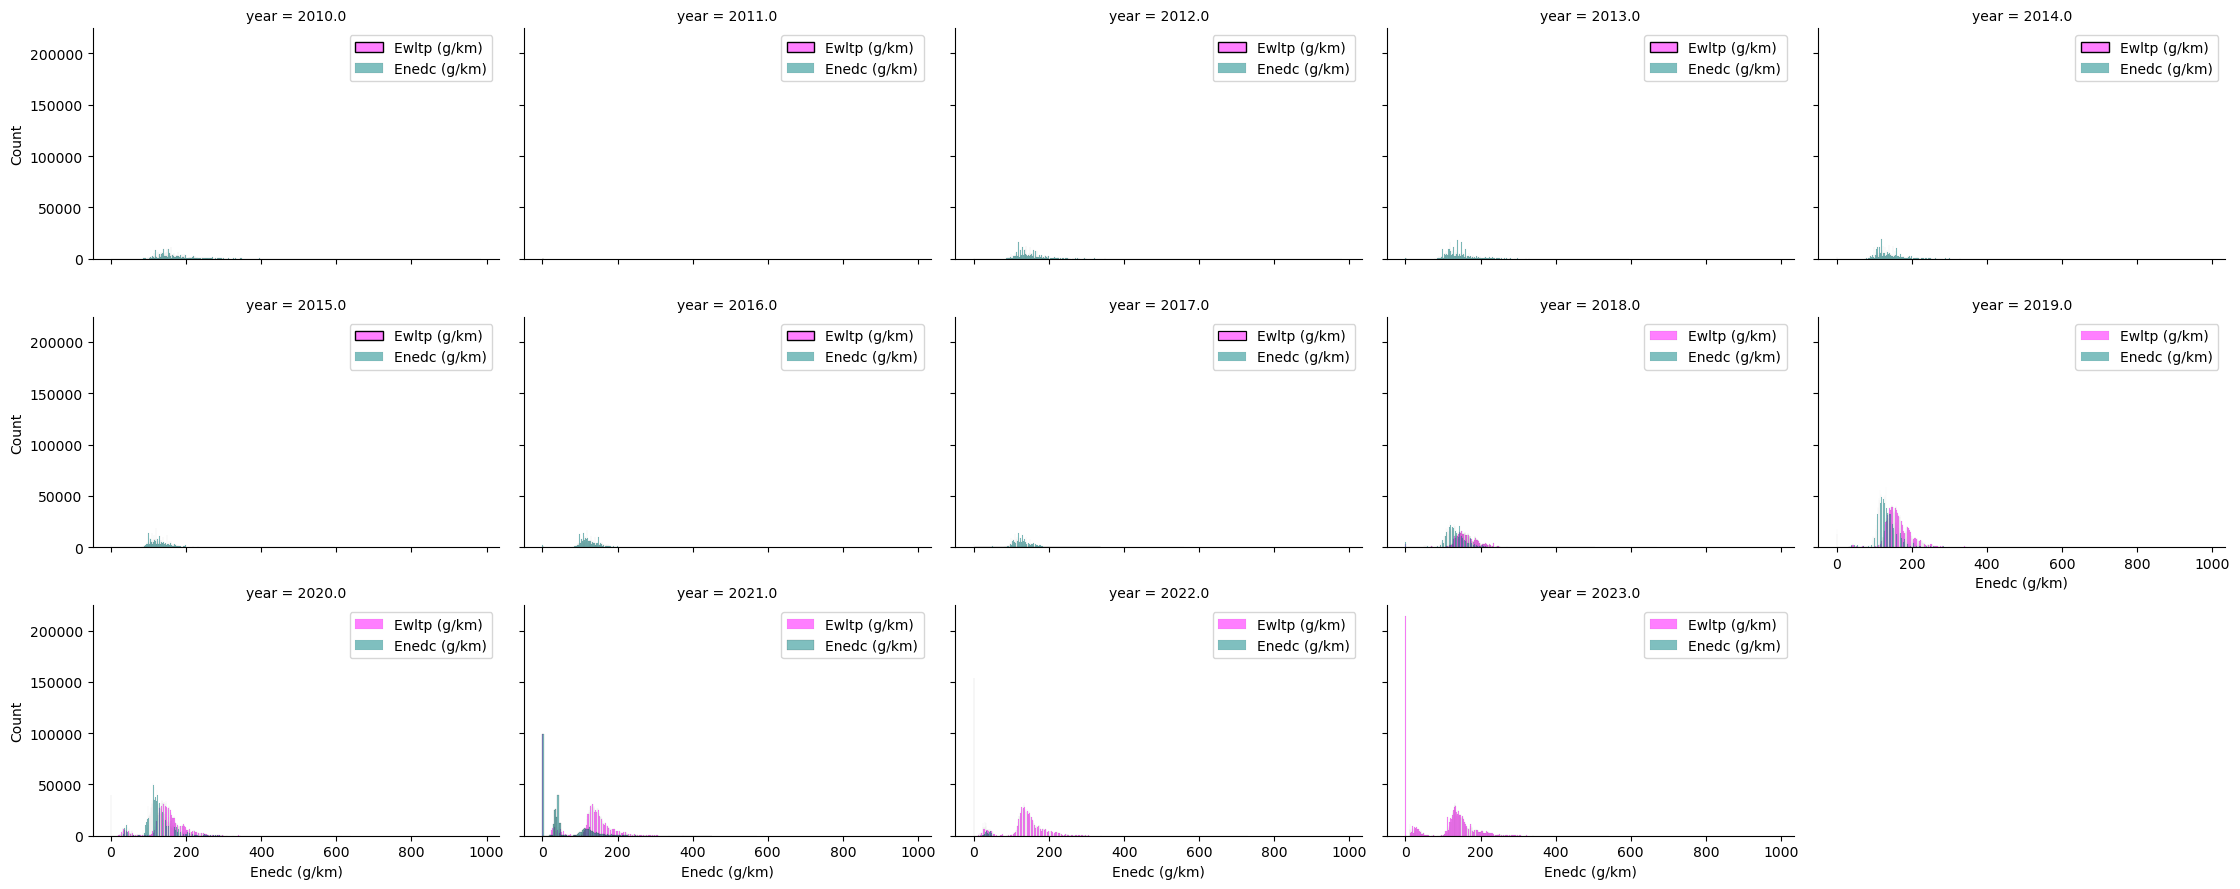

In [49]:
#First version of yearplot w/o function definition

# Create a FacetGrid with 3 rows and 5 columns
g = sns.FacetGrid(df, col="year", col_wrap=5, height=3, aspect=1.5)

# Map both histograms onto the grid
g.map(sns.histplot, "Ewltp (g/km)", color="magenta", label="Ewltp (g/km)", alpha=0.5)
g.map(sns.histplot, "Enedc (g/km)", color="teal", label="Enedc (g/km)", alpha=0.5)

# Add legend to each subplot
for ax in g.axes.flat:
    ax.legend()

# Show the plot
plt.show()

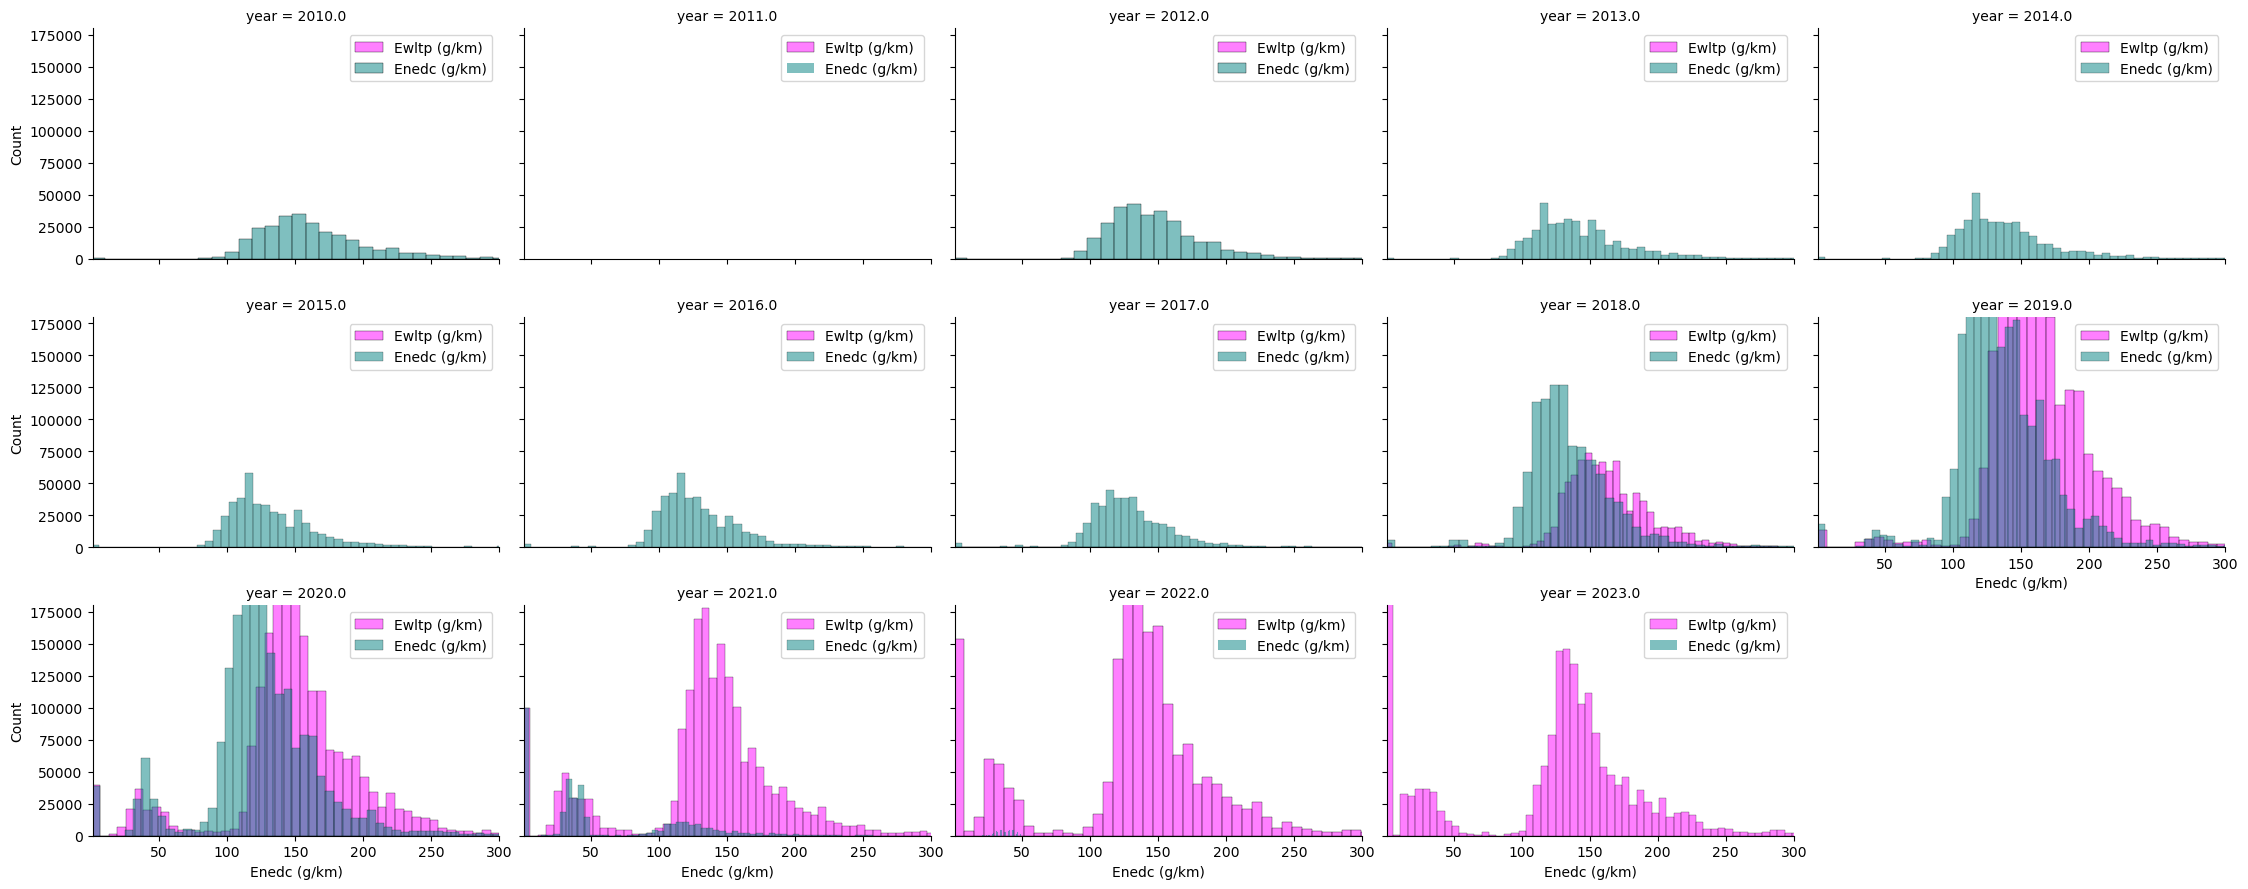

In [177]:
# 2nd, manually refined version (whole df)

# Create a FacetGrid with 3 rows and 5 columns
g = sns.FacetGrid(df, col="year", col_wrap=5, height=3, aspect=1.5)

# Map both histograms onto the grid
g.map(sns.histplot, "Ewltp (g/km)", color="magenta", label="Ewltp (g/km)", bins = 100, kde = False, alpha=0.5)
g.map(sns.histplot, "Enedc (g/km)", color="teal", label="Enedc (g/km)", bins = 100, kde = False, alpha=0.5)

# Add legend and set x-axis limits for each subplot
for ax in g.axes.flat:
    ax.legend()
    ax.set_xlim(1, 300)  # Set x-axis range from 1 to 300
    ax.set_ylim(0, 180000)  # Set y-axis range from 0 to 300

# Show the plot
plt.show()


### TV plots with function

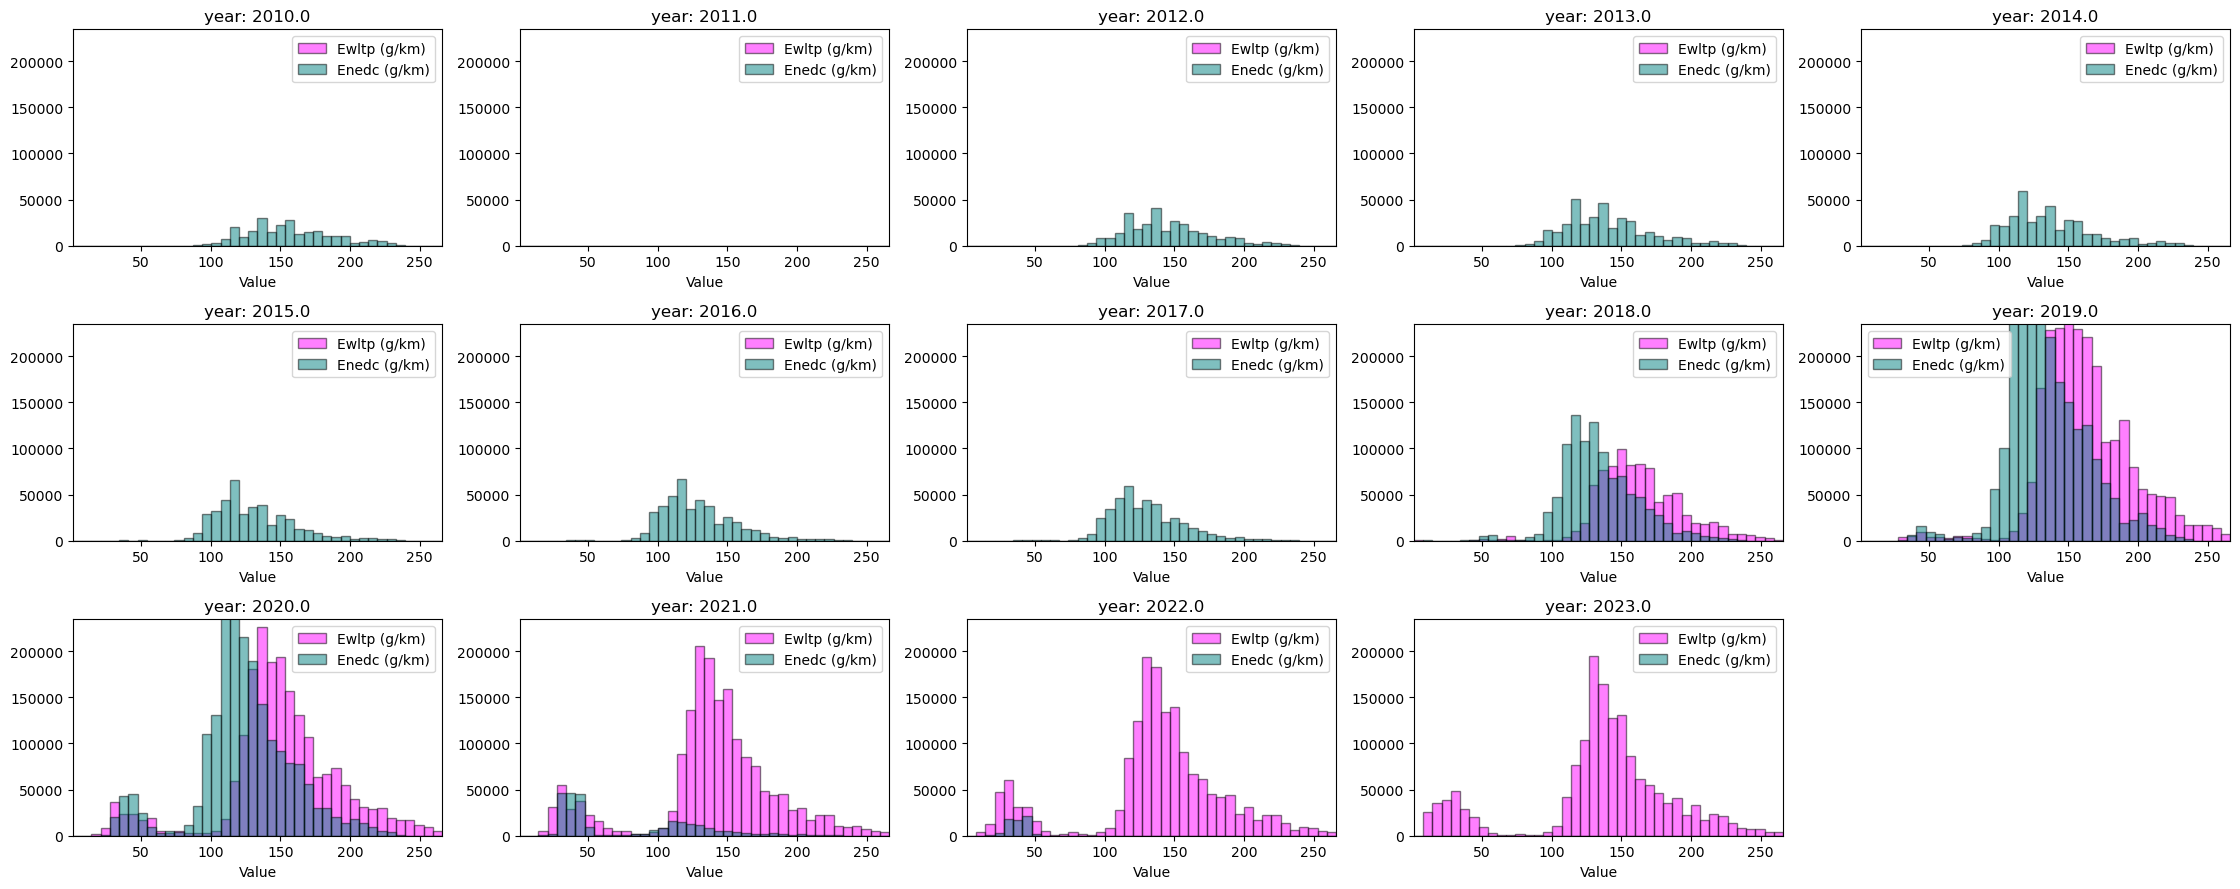

In [59]:
# Generate list of attributes
#excluded_cols = ["ID", "r", "year", "#identical occurences"]
#all_nan_cols = df_combustion.columns[df_combustion.isna().all()].tolist()
attributes =["Ewltp (g/km)", "Enedc (g/km)"]
#attributes = [col for col in df_combustion.select_dtypes(include=['number']).columns 
#              if (col not in excluded_cols) and (col not in all_nan_cols)]

# Call the function with dataframe, attributes, and facet by year
plot_normalized_histograms(df, attributes, row_var="year", bins = 40, palette = ("magenta", "teal"),
                           norm = False, iqrfactor = 2.3, ylimfactor = 0.7)

## Explanatory Variables

### Histplots all years

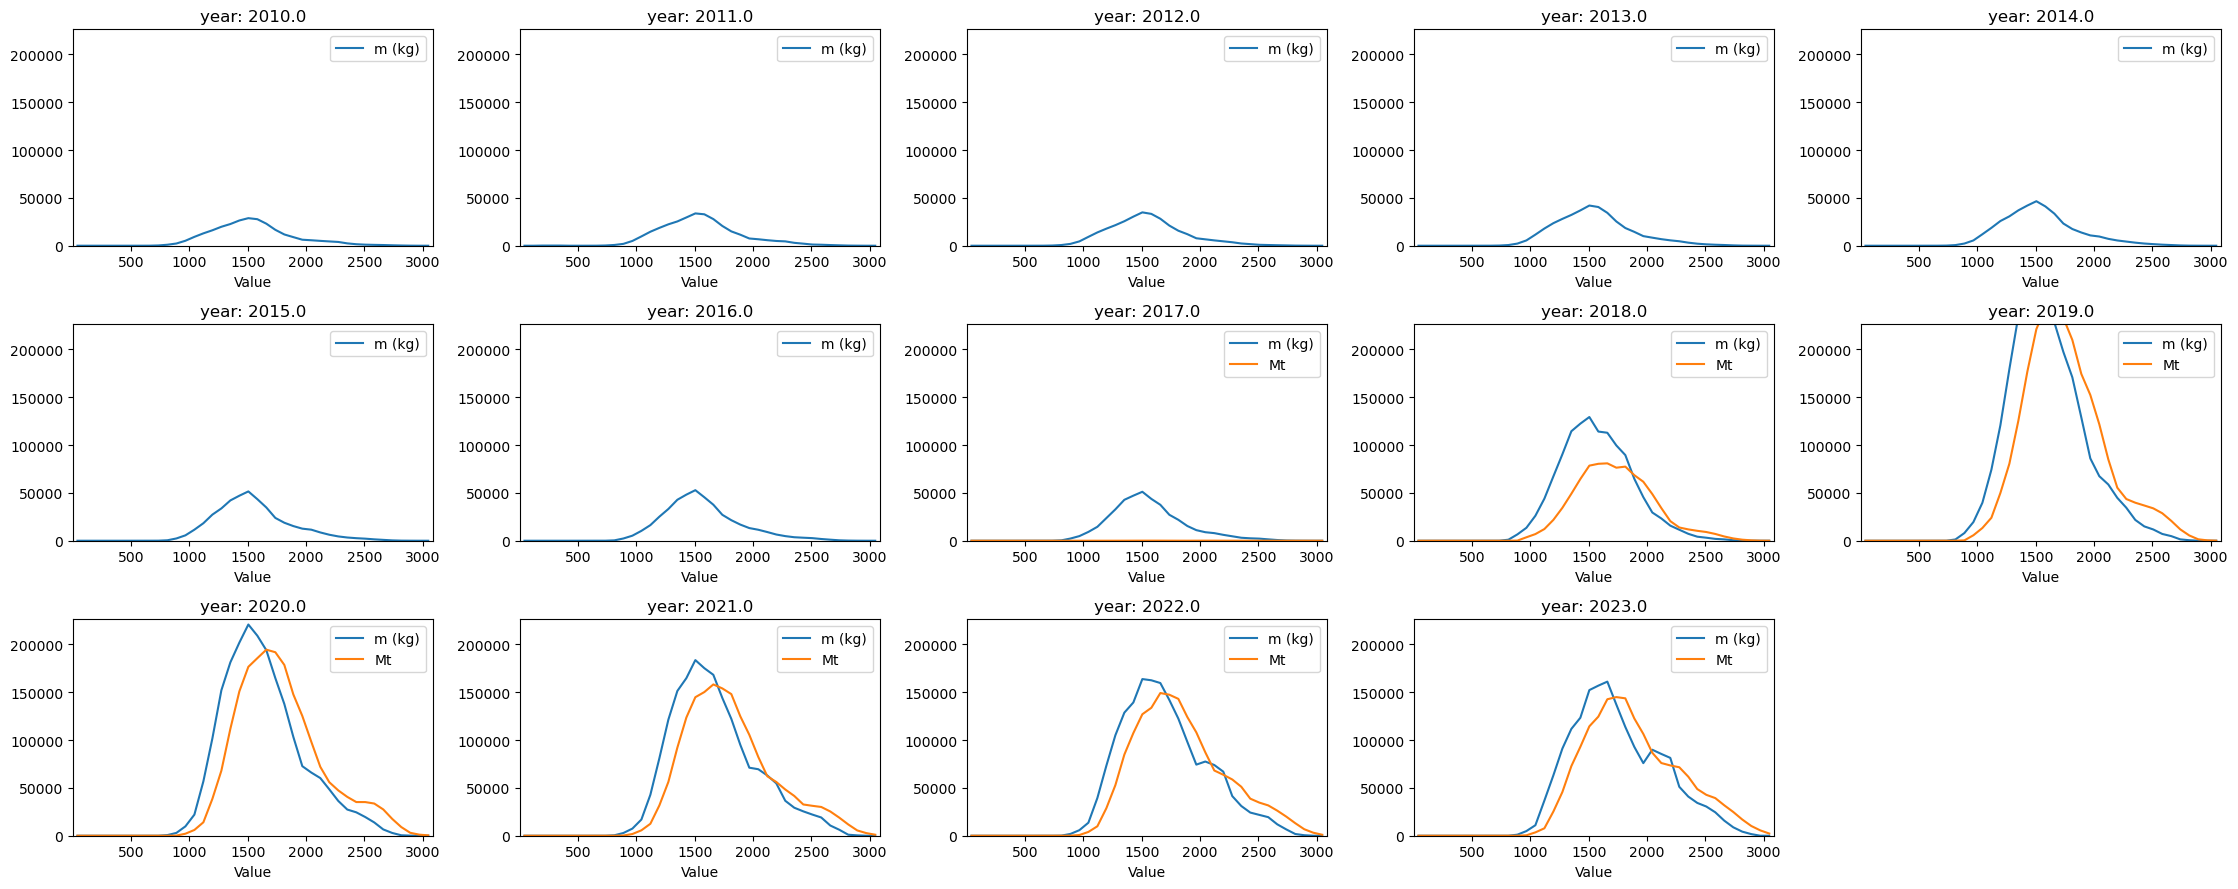

In [70]:
# Generate list of attributes
excluded_cols = ["ID", "r", "year", "#identical occurences"]
all_nan_cols = df.columns[df.isna().all()].tolist()
include_cols =['m (kg)',
 'Mt',
 #'W (mm)',
 #'At1 (mm)',
 #'At2 (mm)',
 #'ec (cm3)',
 #'ep (KW)',
 #'z (Wh/km)'
 ]

attributes = [col for col in include_cols if (col not in excluded_cols) and (col not in all_nan_cols)]

# Call the function with dataframe, attributes, and facet by year
plot_normalized_histograms(df, attributes, row_var="year", bins = 40, norm = False, iqrfactor = 2.3, ylimfactor = 0.7, plot_type="line")

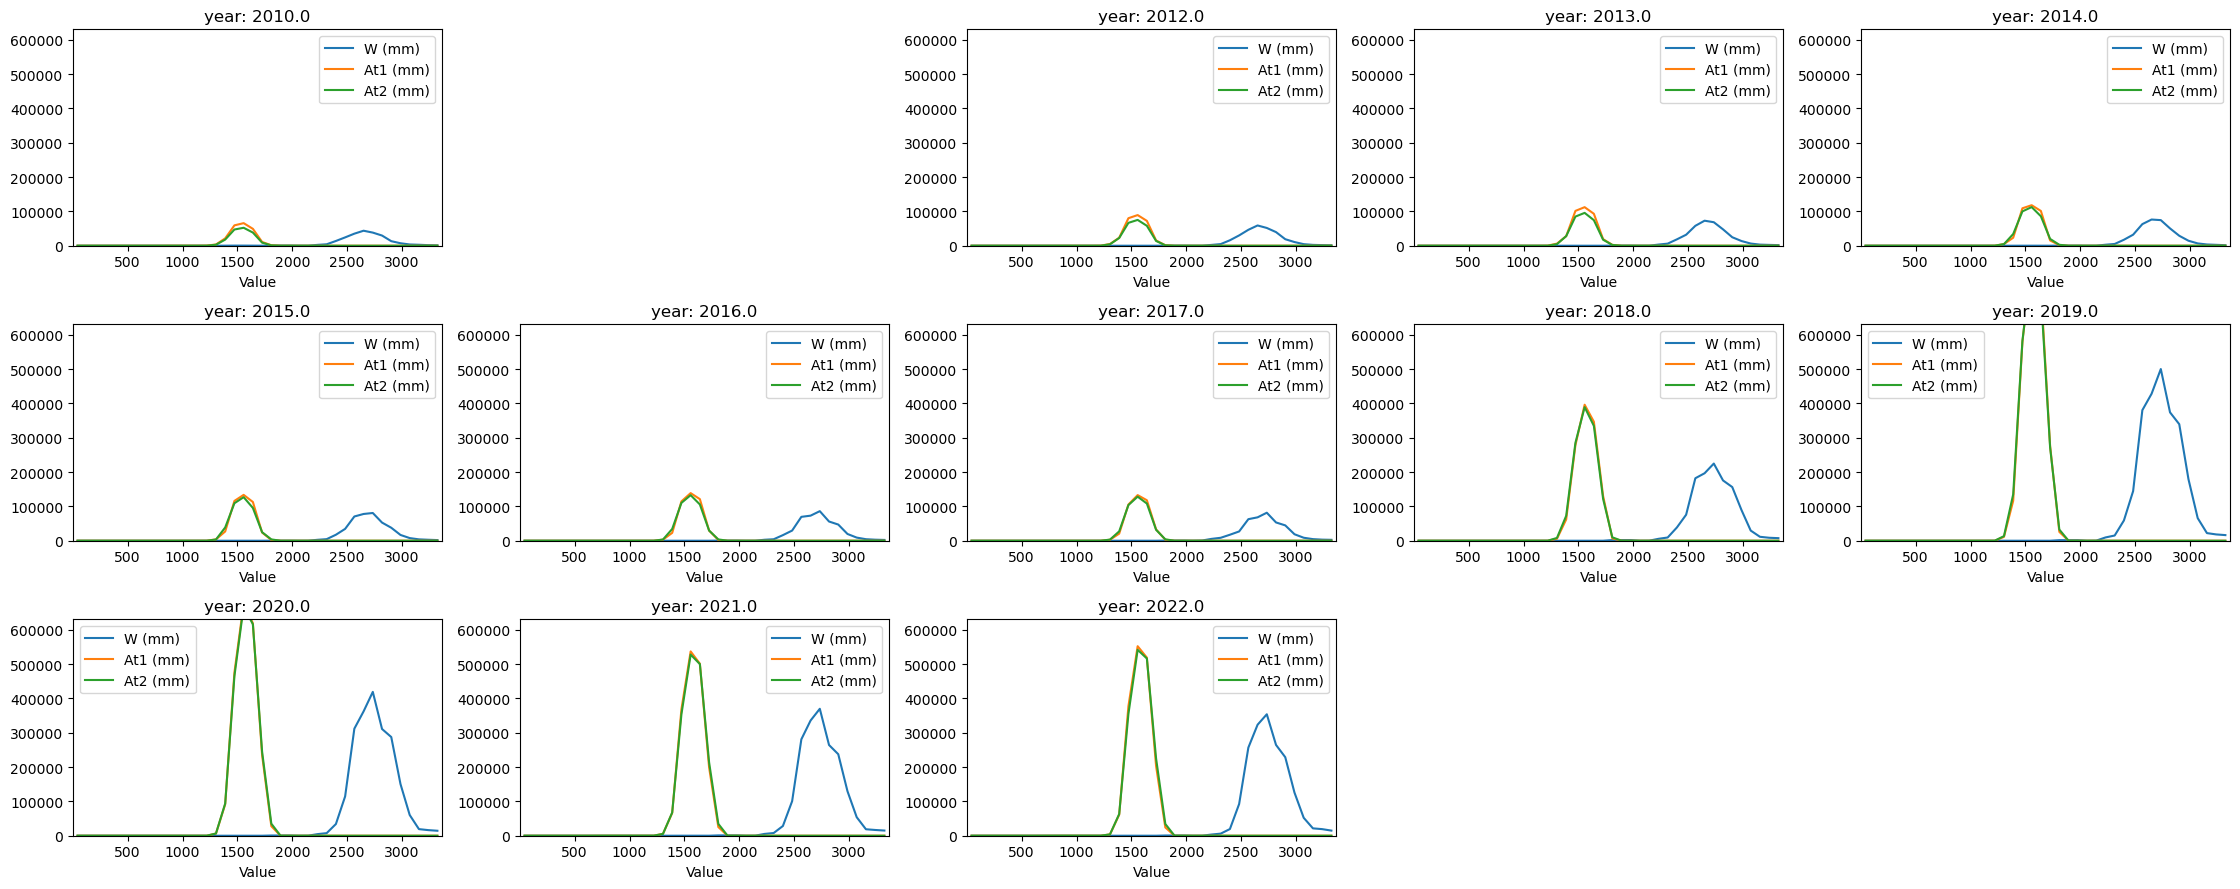

In [71]:
# Generate list of attributes
excluded_cols = ["ID", "r", "year", "#identical occurences"]
all_nan_cols = df.columns[df.isna().all()].tolist()
include_cols =[#'m (kg)',
 #'Mt',
 'W (mm)',
 'At1 (mm)',
 'At2 (mm)',
 #'ec (cm3)',
 #'ep (KW)',
 #'z (Wh/km)'
 ]

attributes = [col for col in include_cols if (col not in excluded_cols) and (col not in all_nan_cols)]

# Call the function with dataframe, attributes, and facet by year
plot_normalized_histograms(df, attributes, row_var="year", bins = 40, norm = False, iqrfactor = 2.3, ylimfactor = 0.7, plot_type="line")

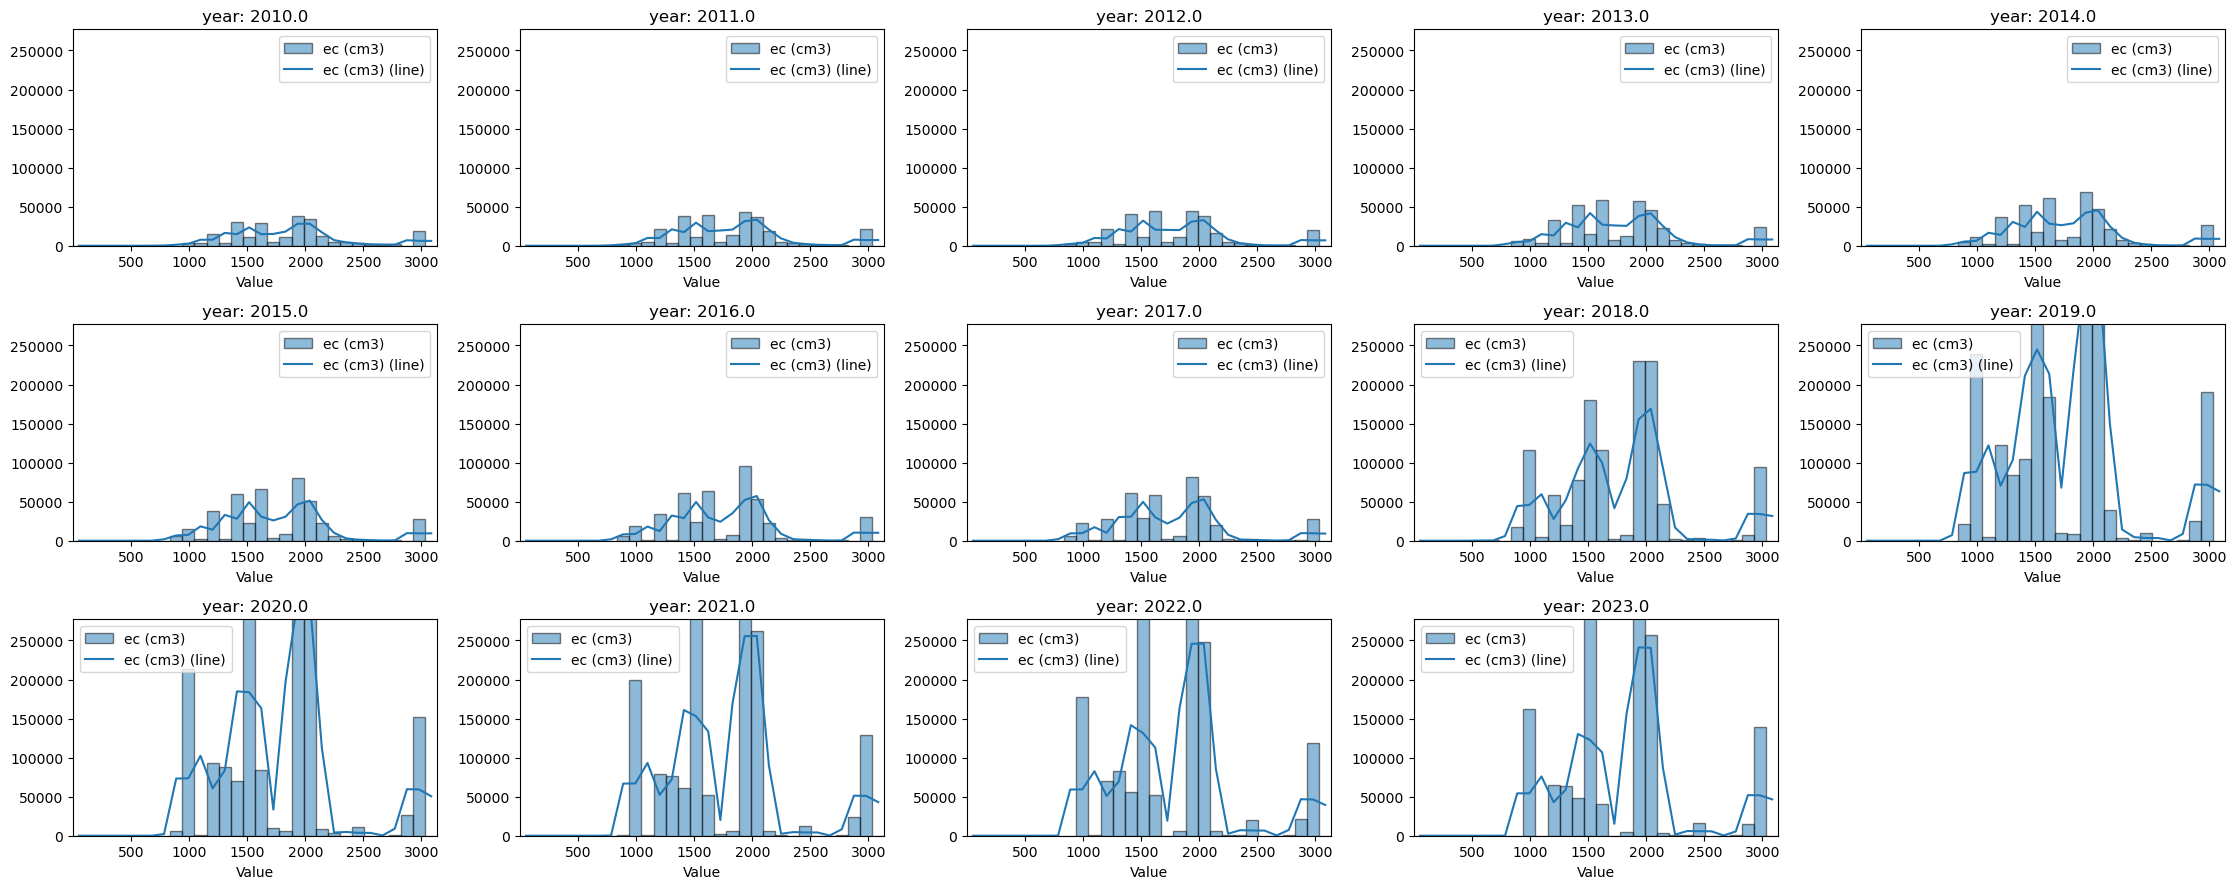

In [26]:
# Generate list of attributes
excluded_cols = ["ID", "r", "year", "#identical occurences"]
all_nan_cols = df.columns[df.isna().all()].tolist()
include_cols =[#'m (kg)',
 #'Mt',
 #'W (mm)',
 #'At1 (mm)',
 #'At2 (mm)',
 'ec (cm3)',
 #'ep (KW)',
 #'z (Wh/km)'
 ]

attributes = [col for col in include_cols if (col not in excluded_cols) and (col not in all_nan_cols)]

# Call the function with dataframe, attributes, and facet by year
plot_normalized_histograms(df, attributes, row_var="year", bins = 30, norm = False, iqrfactor = 2.3, ylimfactor = 0.7, plot_type="both")

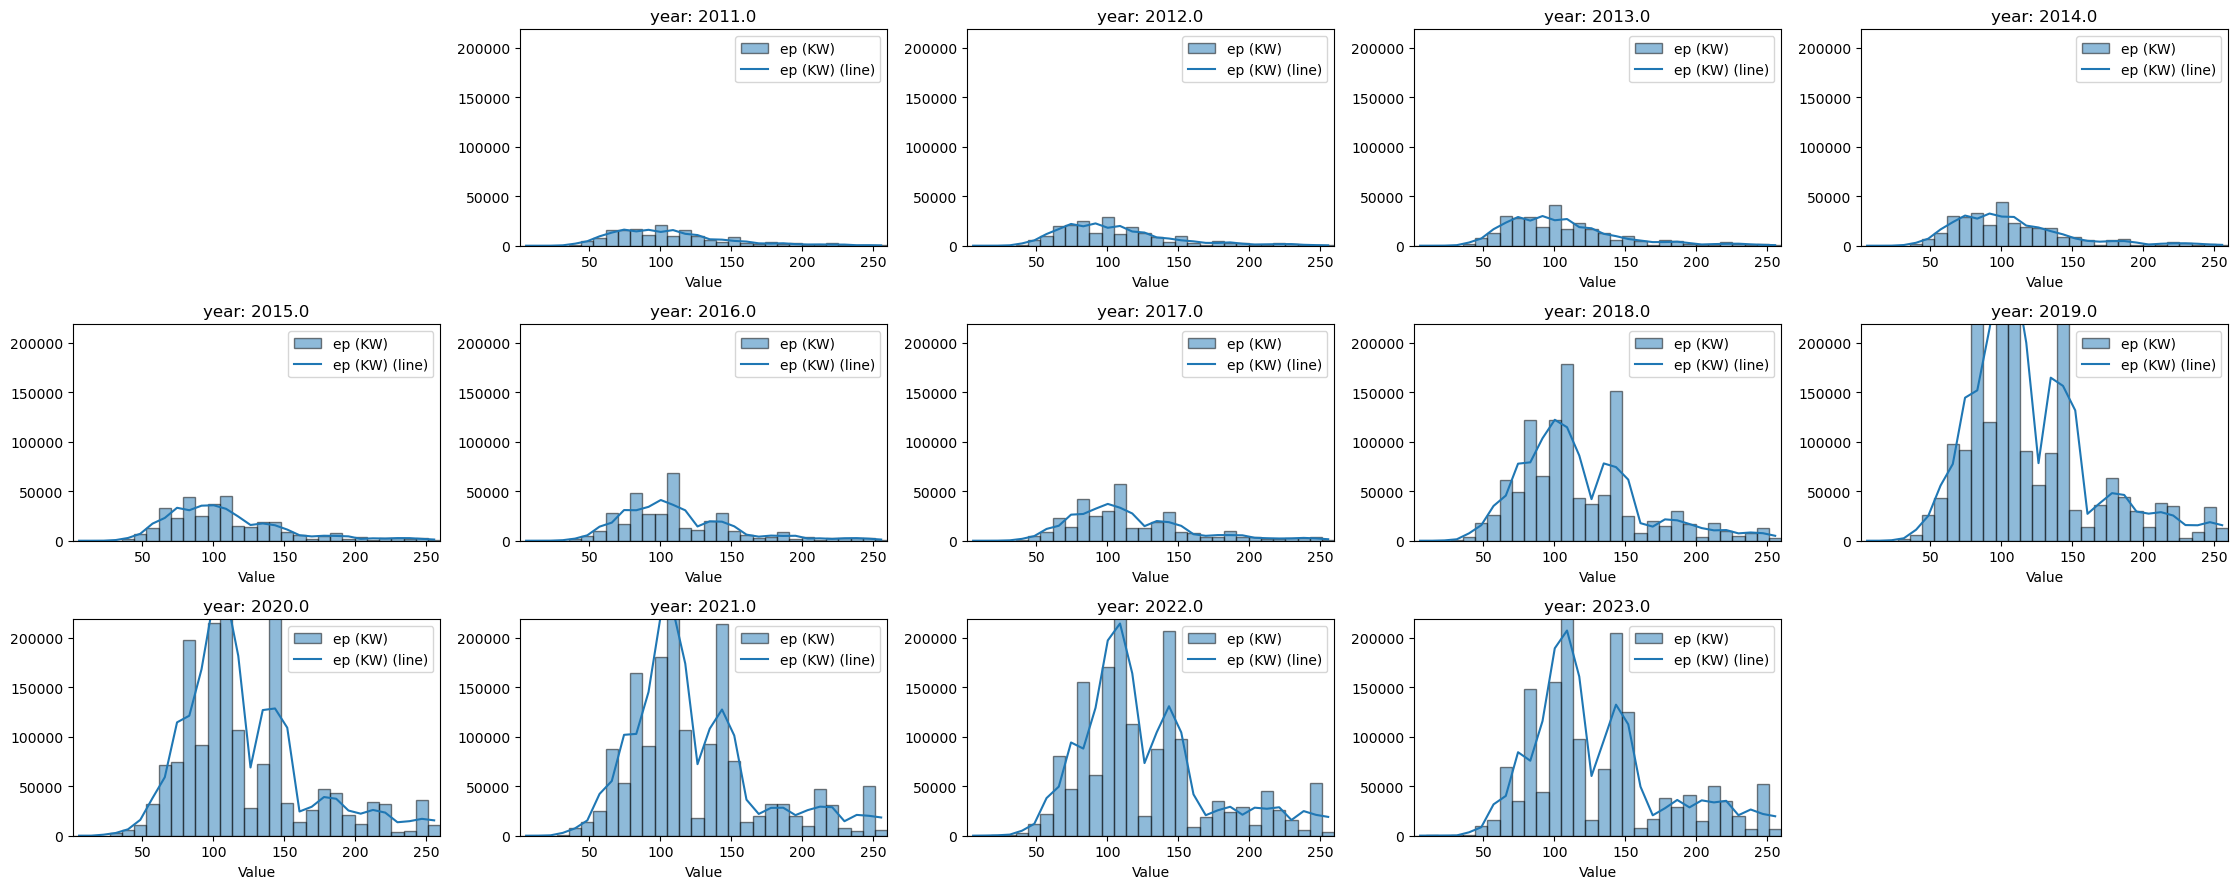

In [27]:
# Generate list of attributes
excluded_cols = ["ID", "r", "year", "#identical occurences"]
all_nan_cols = df.columns[df.isna().all()].tolist()
include_cols =[#'m (kg)',
 #'Mt',
 #'W (mm)',
 #'At1 (mm)',
 #'At2 (mm)',
 #'ec (cm3)',
 'ep (KW)',
 #'z (Wh/km)'
 ]

attributes = [col for col in include_cols if (col not in excluded_cols) and (col not in all_nan_cols)]

# Call the function with dataframe, attributes, and facet by year
plot_normalized_histograms(df, attributes, row_var="year", bins = 30, norm = False, iqrfactor = 2.3, ylimfactor = 0.7, plot_type="both")

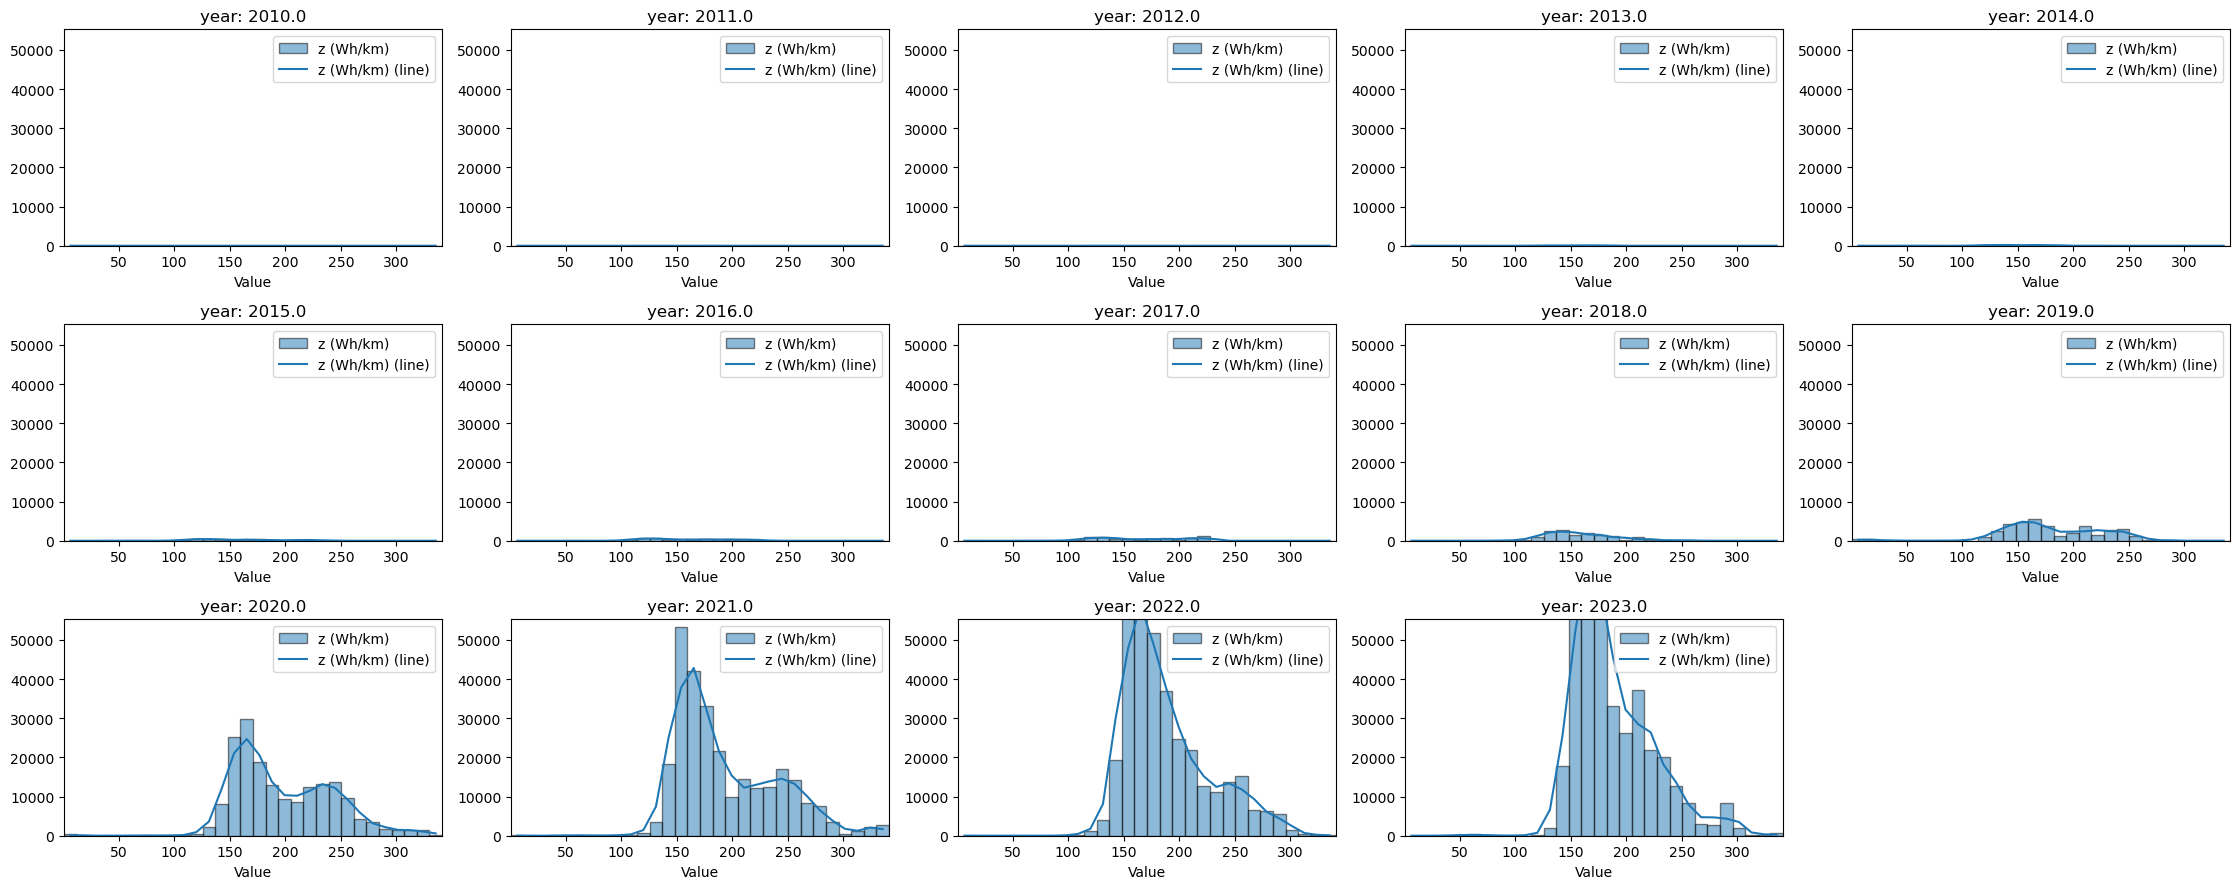

In [28]:
# Generate list of attributes
excluded_cols = ["ID", "r", "year", "#identical occurences"]
all_nan_cols = df.columns[df.isna().all()].tolist()
include_cols =[#'m (kg)',
 #'Mt',
 #'W (mm)',
 #'At1 (mm)',
 #'At2 (mm)',
 #'ec (cm3)',
 #'ep (KW)',
 'z (Wh/km)'
 ]

attributes = [col for col in include_cols if (col not in excluded_cols) and (col not in all_nan_cols)]

# Call the function with dataframe, attributes, and facet by year
plot_normalized_histograms(df, attributes, row_var="year", bins = 30, norm = False, iqrfactor = 2.3, ylimfactor = 0.7, plot_type="both")

### f: count missing values

In [4]:
import pandas as pd
import numpy as np

def count_missing_values(df):
    missing_counts = {}
    
    for col in df.columns:
        # Count pd.NA and np.nan separately
        pd_na_count = df[col].isna().sum() if df[col].dtype.name == 'category' else 0
        np_nan_count = df[col].isna().sum() if df[col].dtype.name == 'float32' else 0
        
        # Store the results
        missing_counts[col] = {'pd.NA': pd_na_count,
                               'np.nan': np_nan_count,
                               'Dtype': df[col].dtype.name,
                               'Percent Missing': f"{df[col].isna().sum() / len(df[col]) * 100:.2f}%"
}

    
    # Convert the results to a DataFrame for easier viewing
    result_df = pd.DataFrame(missing_counts).T
    return result_df

#### execute f: count missing 

In [5]:
# Count and display the missing values
result = count_missing_values(df)
print(result)


                          pd.NA    np.nan     Dtype Percent Missing
ID                            0         0     Int64           0.00%
Country                       0         0  category           0.00%
VFN                     6022343         0  category          41.70%
Mp                      2467065         0  category          17.08%
Mh                         3756         0  category           0.03%
Man                      310768         0  category           2.15%
MMS                     6048284         0  category          41.88%
Tan                      490543         0  category           3.40%
T                         62037         0  category           0.43%
Va                       100484         0  category           0.70%
Ve                       225223         0  category           1.56%
Mk                        42908         0  category           0.30%
Cn                        49370         0  category           0.34%
Ct                        24710         0  categ

### f: barchart non_nan_counts 

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_non_nan_counts(df, attributes, row_var, col_wrap=5, height=3, aspect=1.5):
    """
    Plots multiple bar charts showing the count of non-NaN values for each attribute per year.
    
    Parameters:
    - df: The DataFrame containing the data.
    - attributes: A list of column names (attributes) to plot.
    - row_var: The column used to facet the data (e.g., 'year').
    - col_wrap: Number of columns per row in the grid (default is 5).
    - height: Height of each subplot (default is 3).
    - aspect: Aspect ratio of each subplot (default is 1.5).
    """
    
    # Melt the dataframe to long format for easy aggregation and plotting
    df_long = df.melt(id_vars=[row_var], value_vars=attributes, var_name='attribute', value_name='value')
    
    # Group by the row_var (e.g., 'year') and attribute, then count non-NaN values
    df_counts = df_long.groupby([row_var, 'attribute']).value.count().reset_index()
    df_counts.rename(columns={'value': 'non_nan_count'}, inplace=True)
    
    # Define the order of attributes for consistency
    attribute_order = sorted(attributes)
    
    # Create the FacetGrid with hue set to 'attribute' and assign the palette accordingly
    g = sns.FacetGrid(
        df_counts,
        col=row_var,
        hue='attribute',
        col_wrap=col_wrap,
        height=height,
        aspect=aspect,
        palette='tab20',   # other good ones :tab20 (for good discernability)
        sharey=False
    )
    
    # Map the barplot onto the FacetGrid
    g.map_dataframe(
        sns.barplot,
        x='attribute',
        y='non_nan_count',
        order=attribute_order,
        dodge=False
    )
    
    # Add numerical labels and legend to each subplot
    #for ax in g.axes.flat:
    #    for container in ax.containers:
    #        ax.bar_label(container, fmt='%d', label_type='edge')
    #    ax.legend(title='Attribute', frameon=True)
    
    # Remove x-axis labels and tick labels for all plots since we have a legend
    for ax in g.axes.flat:
        ax.set_xlabel('')            # Remove x-axis label
        ax.set_xticklabels([])       # Remove x-axis tick labels

    
    # Extract handles and labels from the first Axes
    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    
    # Add a single, consolidated legend to the figure in the lower right corner with a frame
    g.figure.legend(handles, labels, title='Attribute', loc='lower right', frameon=True)
    
    # Adjust layout to make room for the legend
    g.figure.subplots_adjust(right=0.85)
    
    # Improve layout spacing
    plt.tight_layout()
    
    # Display the plot
    plt.show()

#### plot barchart(s)

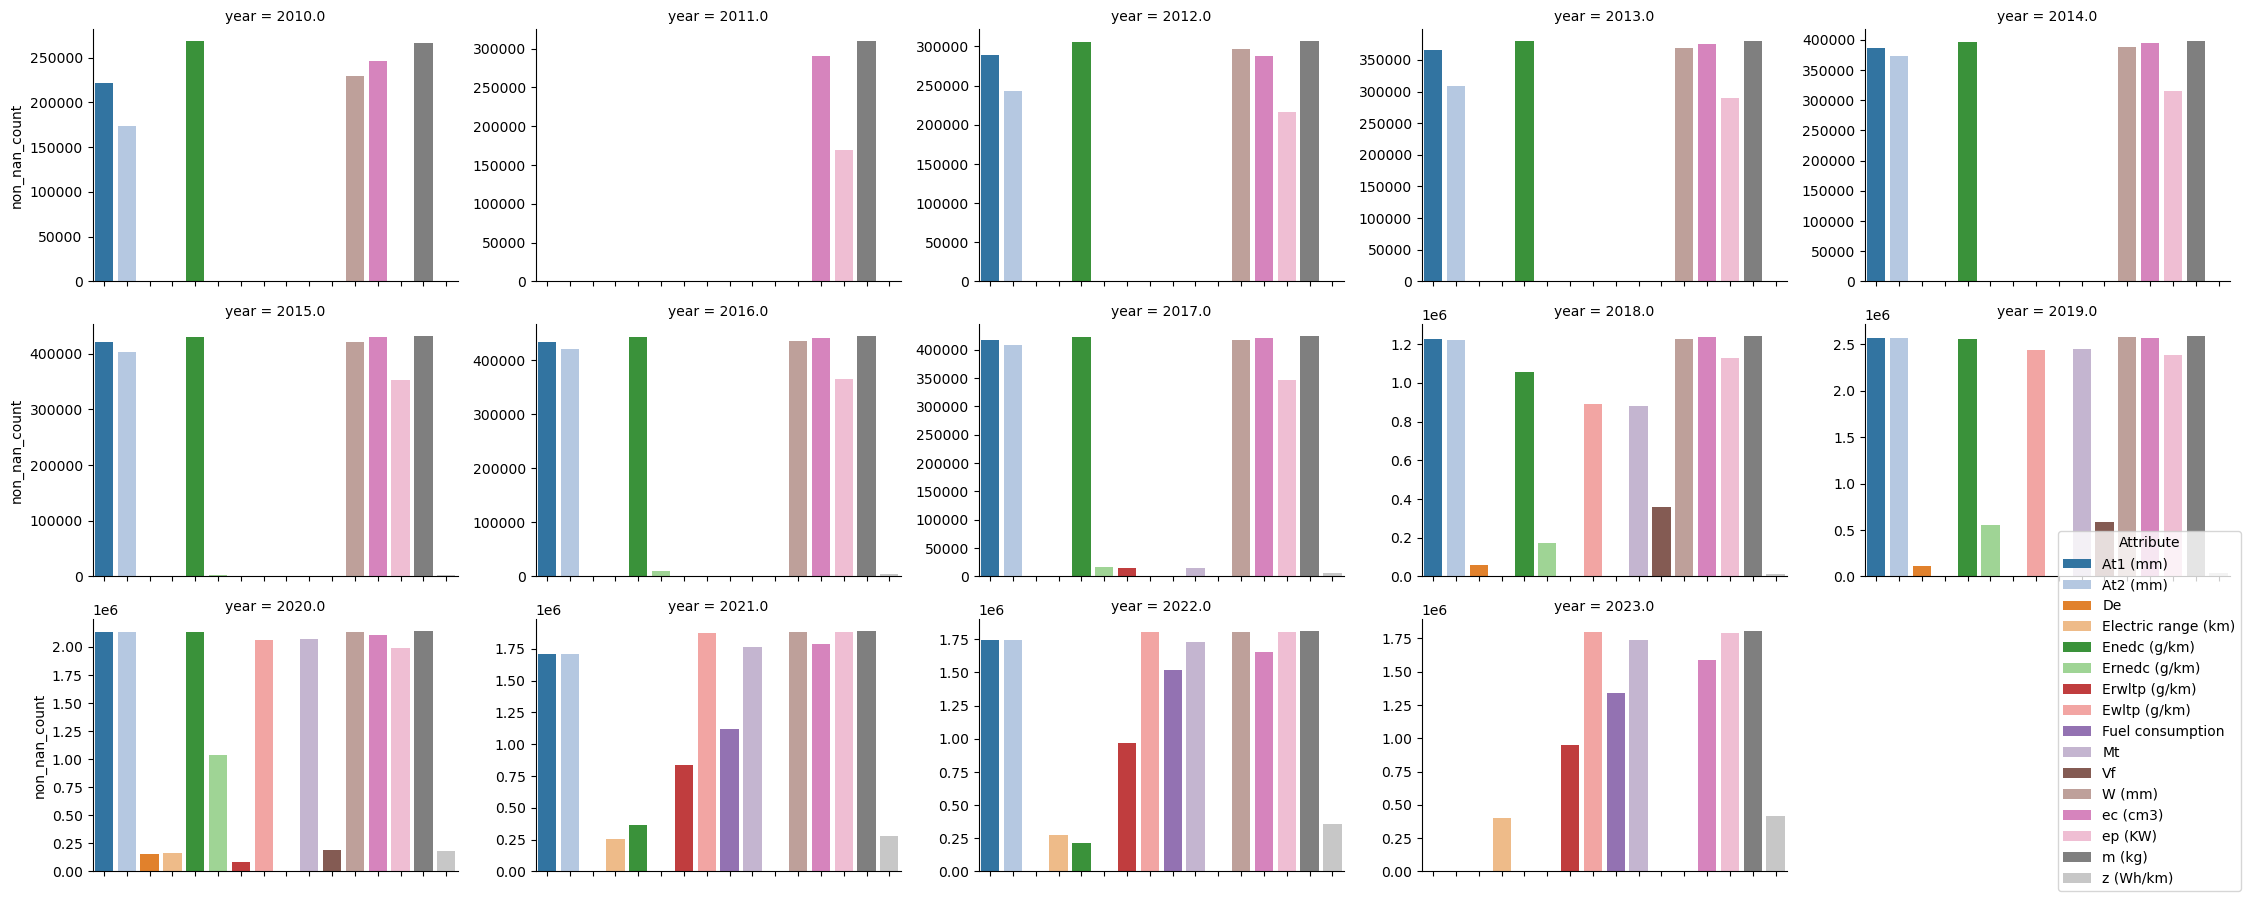

In [48]:
excluded_cols = ["ID", "r", "year", "#identical occurences"]
all_nan_cols = df.columns[df.isna().all()].tolist()
attributes = [col for col in df.select_dtypes(include=['number']).columns 
              if (col not in excluded_cols) and (col not in all_nan_cols)]

# For demonstration, using the provided attributes
#attributes = ["Ewltp (g/km)", "Enedc (g/km)"]

# Call the function with dataframe, attributes, and facet by year
# Ensure that df_combustion and "year" column exist in your DataFrame
plot_non_nan_counts(df, attributes, row_var="year")

# Cleaning Columns

### Read previously shared DataFrame

In [ ]:
df = pd.read_parquet(parquet_EU_shared)

In [3]:
# First, inspect the unique categories in each categorical column
for col in df.select_dtypes(include=['category']):
    num_categories = df[col].nunique(dropna=False)
    print(f"Column '{col}' has {num_categories} unique categorical values (including NaN).")

Column 'Country' has 31 unique categorical values (including NaN).
Column 'VFN' has 29049 unique categorical values (including NaN).
Column 'Mp' has 47 unique categorical values (including NaN).
Column 'Mh' has 261 unique categorical values (including NaN).
Column 'Man' has 478 unique categorical values (including NaN).
Column 'MMS' has 11562 unique categorical values (including NaN).
Column 'Tan' has 49910 unique categorical values (including NaN).
Column 'T' has 26612 unique categorical values (including NaN).
Column 'Va' has 72534 unique categorical values (including NaN).
Column 'Ve' has 182641 unique categorical values (including NaN).
Column 'Mk' has 1746 unique categorical values (including NaN).
Column 'Cn' has 80815 unique categorical values (including NaN).
Column 'Ct' has 17 unique categorical values (including NaN).
Column 'Cr' has 9 unique categorical values (including NaN).
Column 'Ft' has 55 unique categorical values (including NaN).
Column 'Fm' has 15 unique categorical

### f: rename categorical values

In [3]:
# Function to rename categorical values using mappings
def rename_catval(df, attribute, mappings):
    """
    Rename categorical values in a DataFrame column based on provided mappings.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to be renamed.
    attribute (str): The name of the column to be renamed.
    mappings (list of tuples): Each tuple contains a list of aliases and the target name.
                               Example: [ (['old_name1', 'old_name2'], 'new_name'), ... ]
    """
    # Convert the column to a non-categorical type (e.g., string)
    df[attribute] = df[attribute].astype('string')

    # Build a rename dictionary from the mappings
    rename_dict = {}
    for aliases, target_name in mappings:
        for alias in aliases:
            rename_dict[alias] = target_name

    # Replace values
    df[attribute] = df[attribute].replace(rename_dict)

    # Convert the column back to categorical
    df[attribute] = df[attribute].astype('category')

### **Ct Column (Category of the vehicle type approved)**

In [5]:
# Inspect the categories and value counts of 'Ct'
print(df.Ct.cat.categories)
df.Ct.value_counts()

Index([' ', '  ', 'M1', 'M1 ', 'M1  ', 'M1G', 'M1G ', 'M2 ', 'N1', 'N1 ',
       'N1G', 'N2', 'N2G', 'N3', 'N3G', 'm1'],
      dtype='object')


M1      13191645
M1G       988772
M1        189244
M1         20165
m1         15709
N1          7752
M1G         4550
N1G          114
N2            73
N1            27
              20
N3            19
N2G           10
               1
M2             1
N3G            1
Name: Ct, dtype: int64

In [6]:
df[df.Ct == 'm1'].year.value_counts()

2017    15705
2021        4
Name: year, dtype: Int64

In [7]:
df[df["year"] == 2017].Ct.value_counts()

M1      395054
m1       15705
M1G       9261
M1        4077
N1          35
N2           9
N1G          2
             0
             0
M1           0
M1G          0
M2           0
N1           0
N2G          0
N3           0
N3G          0
Name: Ct, dtype: int64

as it appears basically only in one year, "m1" seems to be a misspelling as well ==> rename to "M1"

In [8]:
# Define mappings for 'Ct'
mappings_ct = [
    ([' ', '  '], pd.NA),
    (['M1 ', 'M1  ', 'm1'], 'M1'),
    (['M1G '], 'M1G'),
    (['M2 '], 'M2'),
    (['N1 '], 'N1'),
]

# Apply the renaming to the 'Ct' column
rename_catval(df, "Ct", mappings_ct)
print(df.Ct.cat.categories)
df.Ct.value_counts()

Index(['M1', 'M1G', 'M2', 'N1', 'N1G', 'N2', 'N2G', 'N3', 'N3G'], dtype='string')


M1     13416763
M1G      993322
N1         7779
N1G         114
N2           73
N3           19
N2G          10
M2            1
N3G           1
Name: Ct, dtype: int64

### **Cr Column (Category of the vehicle registered)**

In [9]:
# Inspect the categories and value counts of 'Cr'
print(df.Cr.cat.categories)
df.Cr.value_counts()
df[df.Cr == 'm1'].year.value_counts()

Index([' ', 'M1', 'M1 ', 'M1  ', 'M1G', 'M1G ', 'M1S', 'm1'], dtype='object')


2019    236
2021      5
2018      2
Name: year, dtype: Int64

In [10]:
df[df.Cr == 'M1S'].year.value_counts()

2022    19
Name: year, dtype: Int64

only one year ==> probably misspelling of "M1G"

In [11]:
# Define mappings for 'Cr'
mappings_cr = [
    ([' ', '  '], pd.NA),
    (['M1 ', 'M1  ', 'm1'], 'M1'),
    (['M1G ', 'M1S'], 'M1G'),
]

# Apply the renaming to the 'Cr' column
rename_catval(df, "Cr", mappings_cr)
print(df.Cr.cat.categories)
df.Cr.value_counts()

Index(['M1', 'M1G'], dtype='string')


M1     10687330
M1G      928709
Name: Cr, dtype: int64

### **Fm (Fuel Mode) Column**

In [12]:
# Inspect the categories and value counts of 'Fm'
print(df.Fm.cat.categories)
df.Fm.value_counts()

Index(['2', 'Alimentazione Sconosciuta', 'B', 'E', 'F', 'F  ', 'H', 'M', 'M  ',
       'P', 'h', 'm', 'na', 'p'],
      dtype='object')


M                            11486700
H                             1370724
P                              886030
E                              538105
B                               65385
F                                7513
na                               5194
M                                2229
m                                 188
F                                  18
p                                  17
2                                   7
h                                   3
Alimentazione Sconosciuta           1
Name: Fm, dtype: int64

In [13]:
df[df.Fm == 'na'].Country.value_counts()

NL    5059
IT      95
DE      32
MT       5
RO       2
FI       1
AT       0
SK       0
SI       0
SE       0
PT       0
PL       0
NO       0
LV       0
LU       0
LT       0
IE       0
IS       0
BE       0
HU       0
HR       0
GR       0
GB       0
FR       0
ES       0
EE       0
DK       0
CZ       0
CY       0
BG       0
UK       0
Name: Country, dtype: int64

In [14]:
df[df["Fm"].isna()]["Country"].value_counts()

NL    44926
ES    29351
MT     2886
BG     2717
PL      528
BE      129
DE       89
UK       11
FI       10
RO        6
CY        6
SK        5
LU        4
IT        3
GB        2
PT        2
DK        1
GR        1
SE        1
SI        0
NO        0
AT        0
LV        0
LT        0
IS        0
HU        0
HR        0
FR        0
EE        0
CZ        0
IE        0
Name: Country, dtype: int64

"na"concentrated in the Netherlands where there is a lot of pd.NA ==> treat "na" as pd.NA

In [15]:
# Define mappings for 'Fm'
mappings_fm = [
    (['na', 'Alimentazione Sconosciuta', '2'], pd.NA),
    (['F  '], 'F'),
    (['M  ', 'm'], 'M'),
    (['h'], 'H'),
    (['p'], 'P'),
]

# Apply the renaming to the 'Fm' column
rename_catval(df, "Fm", mappings_fm)
print(df.Fm.cat.categories)
df.Fm.value_counts()

Index(['B', 'E', 'F', 'H', 'M', 'P'], dtype='string')


M    11489117
H     1370727
P      886047
E      538105
B       65385
F        7531
Name: Fm, dtype: int64

### **Ft (Fuel Type) Column**

In [16]:
# Inspect the categories and value counts of 'Ft'
print(df.Ft.cat.categories)
df.Ft.value_counts()

Index([' ', 'BIODIESEL', 'Biodiesel', 'DIESEL', 'DIESEL                   ',
       'DIESEL-ELECTRIC', 'DIESEL/ELECTRIC', 'Diesel', 'Diesel-Electric',
       'Diesel-electric', 'Diesel/Electric', 'Diesel/electric', 'E85',
       'ELECTRIC', 'Electric', 'Electric                 ', 'HYDROGEN',
       'Hydrogen', 'LPG', 'LPG                      ', 'NG', 'NG-BIOMETHANE',
       'NG-Biomethane', 'NG-biomethane', 'NG-biomethane            ',
       'NG_biomethane', 'OTHER', 'Other', 'PETROL', 'PETROL ',
       'PETROL                   ', 'PETROL-ELECTRIC', 'PETROL/ELECTRIC',
       'Petrol', 'Petrol ', 'Petrol-Electric', 'Petrol-Gas', 'Petrol-electric',
       'Petrol/Electric', 'UNKNOWN', 'diesel', 'diesel-electric',
       'diesel/electric', 'e85', 'electric', 'hydrogen', 'lpg', 'ng',
       'ng-biomethane', 'petrol', 'petrol ', 'petrol-electric',
       'petrol/electric', 'unknown'],
      dtype='object')


PETROL                       3322376
DIESEL                       2945617
petrol                       2228168
diesel                       2003718
Diesel                       1320232
Petrol                       1006352
PETROL/ELECTRIC               550171
ELECTRIC                      296497
petrol/electric               266837
electric                      233016
DIESEL/ELECTRIC                53038
LPG                            40570
diesel/electric                25681
NG                             18718
                               16995
lpg                            14985
Petrol/Electric                14454
DIESEL                         12494
Electric                       11011
E85                             8766
NG-biomethane                   8720
ng                              8593
NG-BIOMETHANE                   6440
PETROL                          6059
ng-biomethane                   4058
Petrol-electric                 3371
e85                             2391
p

In [17]:
# Define mappings for 'Ft'
mappings_ft = [
    # Map 'PETROL' variants
    ([
        'PETROL', 'PETROL ', 'PETROL                   ', 'Petrol', 'Petrol ', 'petrol', 'petrol ', 'Petrol-Gas'
    ], 'PETROL'),
    # Map 'DIESEL' variants
    ([
        'DIESEL', 'DIESEL                   ', 'Diesel', 'diesel'
    ], 'DIESEL'),
    # Map 'PETROL/ELECTRIC' variants
    ([
        'PETROL-ELECTRIC', 'PETROL/ELECTRIC', 'Petrol-Electric', 'Petrol-electric',
        'Petrol/Electric', 'petrol-electric', 'petrol/electric'
    ], 'PETROL/ELECTRIC'),
    # Map 'DIESEL/ELECTRIC' variants
    ([
        'DIESEL-ELECTRIC', 'DIESEL/ELECTRIC', 'Diesel-Electric', 'Diesel-electric',
        'Diesel/Electric', 'Diesel/electric', 'diesel-electric', 'diesel/electric'
    ], 'DIESEL/ELECTRIC'),
    # Map 'ELECTRIC' variants
    ([
        'ELECTRIC', 'Electric', 'Electric                 ', 'electric'
    ], 'ELECTRIC'),
    # Map 'LPG' variants
    ([
        'LPG', 'LPG                      ', 'lpg'
    ], 'LPG'),
    # Map 'NG-BIOMETHANE' variants
    ([
        'NG-BIOMETHANE', 'NG-Biomethane', 'NG-biomethane', 'NG-biomethane            ',
        'NG_biomethane', 'ng-biomethane', 'NG', 'ng'
    ], 'NG-BIOMETHANE'),
    # Map 'HYDROGEN' variants
    ([
        'HYDROGEN', 'Hydrogen', 'hydrogen'
    ], 'HYDROGEN'),
    # Map 'E85' variants
    ([
        'E85', 'e85'
    ], 'E85'),
    # Map 'BIODIESEL' variants
    ([
        'BIODIESEL', 'Biodiesel'
    ], 'BIODIESEL'),
    # Map 'OTHER' variants
    ([
        'OTHER', 'Other'
    ], 'OTHER'),
    # Map unknown variants to pd.NA
    ([
        'UNKNOWN', 'unknown', ' '
    ], pd.NA),
]

# Apply the renaming to the 'Ft' column
rename_catval(df, "Ft", mappings_ft)
print(df.Ft.cat.categories)
df.Ft.value_counts(dropna=False)

Index(['BIODIESEL', 'DIESEL', 'DIESEL/ELECTRIC', 'E85', 'ELECTRIC', 'HYDROGEN',
       'LPG', 'NG-BIOMETHANE', 'OTHER', 'PETROL', 'PETROL/ELECTRIC'],
      dtype='string')


PETROL             6563371
DIESEL             6282061
PETROL/ELECTRIC     837545
ELECTRIC            540712
DIESEL/ELECTRIC      80397
LPG                  55900
NG-BIOMETHANE        46859
NaN                  24373
E85                  11157
HYDROGEN               314
BIODIESEL               94
OTHER                    9
Name: Ft, dtype: int64

### **Country Column**

In [18]:
# Inspect the categories and value counts of 'Country'
print(df.Country.cat.categories)
df.Country.value_counts(dropna=False)

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB',
       'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO',
       'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'UK'],
      dtype='object')


DE    4543321
FR    1205514
IT    1015799
BE     953725
GB     806369
AT     740210
PL     706497
ES     705075
NL     453097
SE     400220
CZ     382540
LU     261769
SK     258416
HU     225802
DK     218723
PT     211956
FI     206949
RO     189734
SI     154920
GR     140088
IE     108558
BG      91622
LT      74733
EE      71633
HR      69821
UK      60569
NO      57066
LV      56635
MT      37243
CY      25292
IS       8896
Name: Country, dtype: int64

In [19]:
# Check GB and UK
print("UK:", df[df.Country == "UK"].year.value_counts())
print("GB:", df[df.Country == "GB"].year.value_counts())

UK: 2010    60569
Name: year, dtype: Int64
GB: 2019    203328
2020    147335
2018    107083
2011     59294
2012     58269
2016     48916
2017     48504
2013     45627
2014     44746
2015     43267
Name: year, dtype: Int64


GB and UK are complementary ==> rename all to UK

In [20]:
# Define mappings for 'Country'
mappings_country = [
    (['GB'], 'UK'),
]

# Apply the renaming to the 'Country' column
rename_catval(df, "Country", mappings_country)
print(df.Country.cat.categories)
df.Country.value_counts()

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO', 'PL',
       'PT', 'RO', 'SE', 'SI', 'SK', 'UK'],
      dtype='string')


DE    4543321
FR    1205514
IT    1015799
BE     953725
UK     866938
AT     740210
PL     706497
ES     705075
NL     453097
SE     400220
CZ     382540
LU     261769
SK     258416
HU     225802
DK     218723
PT     211956
FI     206949
RO     189734
SI     154920
GR     140088
IE     108558
BG      91622
LT      74733
EE      71633
HR      69821
NO      57066
LV      56635
MT      37243
CY      25292
IS       8896
Name: Country, dtype: int64

#### optional: rename to full country names

In [ ]:
# optional: rename to full country names

rename_dict = {
    'AT': 'Austria',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'CY': 'Cyprus',
    'CZ': 'Czech Republic',
    'DE': 'Germany',
    'DK': 'Denmark',
    'EE': 'Estonia',
    'ES': 'Spain',
    'FI': 'Finland',
    'FR': 'France',
    'GB': 'United Kingdom',  # 'GB' often refers to the UK
    'GR': 'Greece',
    'HR': 'Croatia',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'IS': 'Iceland',
    'IT': 'Italy',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'LV': 'Latvia',
    'MT': 'Malta',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'SE': 'Sweden',
    'SI': 'Slovenia',
    'SK': 'Slovakia',
    'UK': 'United Kingdom'  # Mapping 'UK' to 'United Kingdom' as well
}

rename_catval(df,"Country",rename_dict)

#### save cleaned Dataframe

In [ ]:
df.to_parquet("..\\..\\data\\EU\\EU_all_current_shared.parquet")

##### read saved

In [2]:
df = pd.read_parquet("..\\..\\data\\EU\\EU_all_current_shared.parquet")

### Mp

In [4]:
print(df.Mp.cat.categories)
df.Mp.value_counts()

Index(['BMW', 'BMW GROUP', 'DAIMLER AG', 'FCA', 'FCA ITALY SPA', 'FCA-TESLA',
       'FIAT GROUP AUTOMOBILES SPA', 'FORD', 'FORD POOL', 'FORD-WERKE GMBH',
       'GENERAL MOTORS', 'HONDA MOTOR EUROPE LTD', 'HYUNDAI',
       'HYUNDAI MOTOR EUROPE', 'JLT POOL', 'KG MOBILITY GREAT WALL MOTOR',
       'KIA', 'MAZDA', 'MAZDA-SUBARU-SUZUKI-TOYOTA', 'MERCEDES-BENZ',
       'MERCEDES-BENZ AG', 'MG-SAIC', 'MITSUBISHI MOTORS', 'MITSUBISHI POOL',
       'POOL RENAULT', 'PSA', 'PSA-OPEL', 'RENAULT', 'RENAULT-MITSUBISHI',
       'RENAULT-NISSAN-MITSUBISHI', 'STELLANTIS', 'SUBARU-SUZUKI-TOYOTA',
       'SUZUKI', 'SUZUKI POOL', 'TATA MOTORS JAGUAR LAND ROVER',
       'TATA MOTORS LTD, JAGUAR CARS LTD , LAND ROVER',
       'TATA MOTORS LTD, JAGUAR CARS LTD, LAND ROVER', 'TESLA',
       'TESLA-HONDA-JLR', 'TOYOTA -DAIHATSU GROUP', 'TOYOTA-DAHAITSU GROUP',
       'TOYOTA-MAZDA', 'VOLKSWAGEN', 'VW GROUP PC', 'VW-SAIC', 'na'],
      dtype='object')


VOLKSWAGEN                                       2446297
VW GROUP PC                                      1938866
BMW                                              1133403
BMW GROUP                                         827705
VW-SAIC                                           792555
MERCEDES-BENZ                                     768198
DAIMLER AG                                        750495
STELLANTIS                                        514750
PSA-OPEL                                          444418
FORD-WERKE GMBH                                   402987
FORD                                              378882
RENAULT-NISSAN-MITSUBISHI                         264594
MERCEDES-BENZ AG                                  258285
RENAULT                                           233984
GENERAL MOTORS                                    214183
PSA                                               201674
KIA                                               134935
RENAULT-MITSUBISHI             

In [5]:
# Share of NAs in coluumn "Mp" per year
df[df.Mp.isna()].year.value_counts()/df[df.Mp.isna()].year.shape[0]

2011    0.201999
2010    0.161852
2019    0.106234
2018    0.078397
2023    0.070553
2021    0.065618
2022    0.054267
2013    0.051249
2017    0.047979
2020    0.046909
2012    0.041457
2016    0.038732
2015    0.034754
Name: year, dtype: Float64

In [6]:
# Create a contingency table using pd.crosstab
mp_year_table = pd.crosstab(df['Mp'], df['year'], dropna=False)

# Display the table
print(mp_year_table)

year                                            2010  2011   2012   2013  \
Mp                                                                         
BMW                                                0     0      0      0   
BMW GROUP                                          0     0  23302  29066   
DAIMLER AG                                         0     0  27991  37766   
FCA                                                0     0      0      0   
FCA ITALY SPA                                      0     0      0      0   
FCA-TESLA                                          0     0      0      0   
FIAT GROUP AUTOMOBILES SPA                         0     0  19558  28566   
FORD                                               0     0      0      0   
FORD POOL                                      14998     0      0      0   
FORD-WERKE GMBH                                    0     0  17038  17605   
GENERAL MOTORS                                     0     0  31673  39903   
HONDA MOTOR 

In [7]:
# Detailed mapping by ChatGPT considering mergers/aquisitions and pooling agreements changing over time:

import pandas as pd

# mapping list with pd.NA for missing values
mapping_list = [
    # BMW Group remained consistent throughout the years
    {'old_names': ['BMW', 'BMW GROUP'], 'new_name': 'BMW Group', 'start_year': None, 'end_year': None},

    # Daimler AG operated under this name until it rebranded in 2022
    {'old_names': ['DAIMLER AG'], 'new_name': 'Daimler AG', 'start_year': None, 'end_year': 2021},

    # From 2022 onwards, Daimler AG rebranded to Mercedes-Benz Group
    {'old_names': ['MERCEDES-BENZ AG', 'MERCEDES-BENZ'], 'new_name': 'Mercedes-Benz Group', 'start_year': 2022, 'end_year': None},

    # Fiat Chrysler Automobiles (FCA) operated until merging with PSA to form Stellantis in 2021
    {'old_names': ['FIAT GROUP AUTOMOBILES SPA', 'FCA', 'FCA ITALY SPA'], 'new_name': 'Fiat Chrysler Automobiles', 'start_year': None, 'end_year': 2020},

    # PSA Group operated independently until merging with FCA to form Stellantis in 2021
    {'old_names': ['PSA', 'PSA-OPEL'], 'new_name': 'PSA Group', 'start_year': None, 'end_year': 2020},

    # Stellantis formed in 2021 from the merger of FCA and PSA
    {'old_names': ['STELLANTIS'], 'new_name': 'Stellantis', 'start_year': 2021, 'end_year': None},

    # Ford Motor Company remained consistent throughout
    {'old_names': ['FORD', 'FORD POOL', 'FORD-WERKE GMBH'], 'new_name': 'Ford', 'start_year': None, 'end_year': None},

    # General Motors remained consistent throughout
    {'old_names': ['GENERAL MOTORS'], 'new_name': 'General Motors', 'start_year': None, 'end_year': None},

    # Honda Motor Company remained consistent throughout
    {'old_names': ['HONDA MOTOR EUROPE LTD'], 'new_name': 'Honda', 'start_year': None, 'end_year': None},

    # Hyundai Motor Company remained consistent throughout
    {'old_names': ['HYUNDAI', 'HYUNDAI MOTOR EUROPE'], 'new_name': 'Hyundai', 'start_year': None, 'end_year': None},

    # Kia Motors remained consistent throughout
    {'old_names': ['KIA'], 'new_name': 'Kia', 'start_year': None, 'end_year': None},

    # Jaguar Land Rover has been owned by Tata Motors since 2008
    {'old_names': [
        'TATA MOTORS JAGUAR LAND ROVER',
        'TATA MOTORS LTD, JAGUAR CARS LTD , LAND ROVER',
        'TATA MOTORS LTD, JAGUAR CARS LTD, LAND ROVER'
    ], 'new_name': 'Jaguar Land Rover', 'start_year': 2008, 'end_year': None},

    # Mazda operated independently up to 2018
    {'old_names': ['MAZDA'], 'new_name': 'Mazda', 'start_year': None, 'end_year': 2018},

    # Mazda and Toyota entered a pooling agreement from 2019 to 2020
    {'old_names': ['MAZDA', 'TOYOTA-MAZDA'], 'new_name': 'Toyota-Mazda', 'start_year': 2019, 'end_year': 2020},

    # Mazda joined a larger pooling agreement with Toyota, Suzuki, and Subaru from 2021 onwards
    {'old_names': ['MAZDA'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Suzuki operated independently up to 2018
    {'old_names': ['SUZUKI', 'SUZUKI POOL'], 'new_name': 'Suzuki', 'start_year': None, 'end_year': 2018},

    # Suzuki and Toyota entered a pooling agreement from 2019 to 2020
    {'old_names': ['SUZUKI'], 'new_name': 'Toyota-Suzuki', 'start_year': 2019, 'end_year': 2020},

    # Suzuki joined the larger pooling agreement with Toyota, Mazda, and Subaru from 2021 onwards
    {'old_names': ['SUZUKI'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Subaru operated independently up to 2020
    {'old_names': ['SUBARU'], 'new_name': 'Subaru', 'start_year': None, 'end_year': 2020},

    # Subaru joined the pooling agreement with Toyota, Mazda, and Suzuki from 2021 onwards
    {'old_names': ['SUBARU'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Toyota operated independently up to 2018
    {'old_names': ['TOYOTA', 'TOYOTA -DAIHATSU GROUP', 'TOYOTA-DAHAITSU GROUP'], 'new_name': 'Toyota', 'start_year': None, 'end_year': 2018},

    # Toyota and Mazda entered a pooling agreement from 2019 to 2020
    {'old_names': ['TOYOTA'], 'new_name': 'Toyota-Mazda', 'start_year': 2019, 'end_year': 2020},

    # Toyota expanded its pooling agreement to include Mazda, Suzuki, and Subaru from 2021 onwards
    {'old_names': ['TOYOTA', 'MAZDA-SUBARU-SUZUKI-TOYOTA', 'SUBARU-SUZUKI-TOYOTA'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Reflects the Toyota-Mazda pooling agreement during 2019-2020
    {'old_names': ['TOYOTA-MAZDA'], 'new_name': 'Toyota-Mazda', 'start_year': 2019, 'end_year': 2020},

    # Reflects the expanded pooling agreement including Mazda, Suzuki, and Subaru from 2021 onwards
    {'old_names': ['MAZDA-SUBARU-SUZUKI-TOYOTA', 'SUBARU-SUZUKI-TOYOTA'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Mitsubishi Motors operated independently up to 2015
    {'old_names': ['MITSUBISHI MOTORS'], 'new_name': 'Mitsubishi Motors', 'start_year': None, 'end_year': 2015},

    # Mitsubishi joined the Renault-Nissan-Mitsubishi Alliance in 2016
    {'old_names': ['MITSUBISHI MOTORS'], 'new_name': 'Renault-Nissan-Mitsubishi Alliance', 'start_year': 2016, 'end_year': None},

    # Renault operated independently up to 1998
    {'old_names': ['RENAULT', 'POOL RENAULT'], 'new_name': 'Renault', 'start_year': None, 'end_year': 1998},

    # Renault formed an alliance with Nissan from 1999 to 2015
    {'old_names': ['RENAULT', 'POOL RENAULT', 'RENAULT-MITSUBISHI'], 'new_name': 'Renault-Nissan Alliance', 'start_year': 1999, 'end_year': 2015},

    # Mitsubishi joined the alliance in 2016
    {'old_names': ['RENAULT', 'POOL RENAULT', 'RENAULT-MITSUBISHI', 'RENAULT-NISSAN-MITSUBISHI'], 'new_name': 'Renault-Nissan-Mitsubishi Alliance', 'start_year': 2016, 'end_year': None},

    # Volkswagen Group remained consistent throughout
    {'old_names': ['VOLKSWAGEN', 'VW GROUP PC', 'VW-SAIC'], 'new_name': 'Volkswagen Group', 'start_year': None, 'end_year': None},

    # SAIC Motor Corporation remained consistent
    {'old_names': ['MG-SAIC'], 'new_name': 'SAIC Motor', 'start_year': None, 'end_year': None},

    # Great Wall Motor remained consistent
    {'old_names': ['KG MOBILITY GREAT WALL MOTOR'], 'new_name': 'Great Wall Motor', 'start_year': None, 'end_year': None},

    # Tesla remained independent
    {'old_names': ['TESLA'], 'new_name': 'Tesla', 'start_year': None, 'end_year': None},

    # Reflects pooling agreement between FCA and Tesla
    {'old_names': ['FCA-TESLA'], 'new_name': 'FCA-Tesla', 'start_year': None, 'end_year': None},
    
    # Adding mapping for 'JLT POOL'
    {'old_names': ['JLT POOL'], 'new_name': 'Jaguar Land Rover - Tesla Pool', 'start_year': None, 'end_year': None},

    # Adding mapping for 'MITSUBISHI POOL'
    {'old_names': ['MITSUBISHI POOL'], 'new_name': 'Mitsubishi Motors', 'start_year': None, 'end_year': 2015},
    {'old_names': ['MITSUBISHI POOL'], 'new_name': 'Renault-Nissan-Mitsubishi Alliance', 'start_year': 2016, 'end_year': None},

    # Adding mapping for 'TESLA-HONDA-JLR'
    {'old_names': ['TESLA-HONDA-JLR'], 'new_name': 'Tesla-Honda-Jaguar Land Rover Pool', 'start_year': None, 'end_year': None},

    # Missing values represented as pd.NA
    {'old_names': ['na'], 'new_name': pd.NA, 'start_year': None, 'end_year': None},
]



In [8]:
# Rename routine by ChatGPT to apply mapping:

# Ensure 'year' is integer and 'Mp' is string type
df['year'] = df['year'].astype(int)
df['Mp'] = df['Mp'].astype(object)  # Object type to handle pd.NA correctly

# Reset index to keep track of original row order
df.reset_index(inplace=True)

# Create mapping DataFrame from mapping_list
mapping_entries = []
for mapping in mapping_list:
    for old_name in mapping['old_names']:
        mapping_entries.append({
            'old_name': old_name,
            'new_name': mapping['new_name'],
            'start_year': mapping['start_year'],
            'end_year': mapping['end_year']
        })
mapping_df = pd.DataFrame(mapping_entries)

# Merge df with mapping_df on 'Mp' and 'old_name'
df_merged = df.merge(mapping_df, left_on='Mp', right_on='old_name', how='left', suffixes=('', '_mapped'))

# Replace None with -infinity or infinity for comparison
df_merged['start_year'] = df_merged['start_year'].fillna(-np.inf)
df_merged['end_year'] = df_merged['end_year'].fillna(np.inf)

# Create mask for rows where 'year' falls within 'start_year' and 'end_year'
year_mask = (df_merged['year'] >= df_merged['start_year']) & (df_merged['year'] <= df_merged['end_year'])

# Assign 'Mp_standardized' where conditions are met, else NaN
df_merged['Mp_standardized'] = np.where(year_mask, df_merged['new_name'], pd.NA)

# Calculate period length for prioritization (shorter periods first)
df_merged['period_length'] = df_merged['end_year'] - df_merged['start_year']
df_merged['period_length'].replace(np.inf, 9999, inplace=True)
df_merged['period_length'].replace(-np.inf, -9999, inplace=True)

# Sort by 'index' and 'period_length' to prioritize more specific mappings
df_merged.sort_values(by=['index', 'period_length'], ascending=[True, True], inplace=True)

# Drop duplicates to keep the first (most specific) mapping per row
df_merged = df_merged.drop_duplicates(subset='index', keep='first')

# Set index to 'index' for merging back
df.set_index('index', inplace=True)
df_merged.set_index('index', inplace=True)

# Assign standardized names
df['Mp'] = df_merged['Mp_standardized']

# convert 'Mp' and 'Mp_standardized' back to categorical
df['Mp'] = df['Mp'].astype('category')
#df['Mp_standardized'] = df['Mp_standardized'].astype('category')

# Reset index if needed
df.reset_index(drop=True, inplace=True)



In [9]:
print(df.Mp.cat.categories)
df.Mp.value_counts()

Index(['BMW Group', 'Daimler AG', 'FCA-Tesla', 'Fiat Chrysler Automobiles',
       'Ford', 'General Motors', 'Great Wall Motor', 'Honda', 'Hyundai',
       'Jaguar Land Rover', 'Jaguar Land Rover - Tesla Pool', 'Kia',
       'Mercedes-Benz Group', 'Mitsubishi Motors', 'PSA Group',
       'Renault-Nissan Alliance', 'Renault-Nissan-Mitsubishi Alliance',
       'SAIC Motor', 'Stellantis', 'Suzuki', 'Tesla',
       'Tesla-Honda-Jaguar Land Rover Pool', 'Toyota', 'Toyota-Mazda',
       'Toyota-Mazda-Suzuki-Subaru', 'Toyota-Suzuki', 'Volkswagen Group'],
      dtype='object')


Volkswagen Group                      5177718
BMW Group                             1961108
Ford                                   796867
Daimler AG                             750495
PSA Group                              646092
Mercedes-Benz Group                    522098
Stellantis                             514750
Renault-Nissan-Mitsubishi Alliance     264594
General Motors                         214183
Fiat Chrysler Automobiles              199756
Hyundai                                135167
Kia                                    134935
Jaguar Land Rover                      125408
Renault-Nissan Alliance                122356
Toyota-Mazda-Suzuki-Subaru             109525
FCA-Tesla                               79483
Toyota-Mazda                            67455
Toyota                                  35184
Tesla                                   34084
Tesla-Honda-Jaguar Land Rover Pool      28802
Honda                                   25633
Suzuki                            

In [10]:
# Create a contingency table using pd.crosstab
mp_year_table = pd.crosstab(df['Mp'], df['year'], dropna=False)

# Display the table
print(mp_year_table)

year                                 2010  2011   2012   2013    2014    2015  \
Mp                                                                              
BMW Group                               0     0  23302  29066   35780   44812   
Daimler AG                              0     0  27991  37766   40060   42820   
FCA-Tesla                               0     0      0      0       0       0   
Fiat Chrysler Automobiles               0     0  19558  28566   17933   16129   
Ford                                14998     0  17038  17605   16937   18478   
General Motors                          0     0  31673  39903   38968   34812   
Great Wall Motor                        0     0      0      0       0       0   
Honda                                   0     0   2519   3048    2990    2746   
Hyundai                                 0     0      0      0    6987    7860   
Jaguar Land Rover                       0     0   3035   4556    5380    6985   
Jaguar Land Rover - Tesla Po

## Mh

In [ ]:
print("Mh: ", df.Mh.nunique(), "Man: ", df.Man.nunique(), "MMS: ", df.MMS.nunique())

Mh:  261 Man:  477 MMS:  11561


In [ ]:
with pd.option_context('display.max_rows', None):
    print(df.Mh.value_counts())

with pd.option_context('display.max_rows', None):
    print(df.Man.value_counts())

VOLKSWAGEN                                          1953152
BMW AG                                              1938865
AUDI AG                                             1419262
SKODA                                               1163682
MERCEDES-BENZ AG                                    1024769
DAIMLER AG                                           800436
FORD WERKE GMBH                                      688357
RENAULT                                              550884
VOLVO                                                538602
SEAT                                                 496161
AUTOMOBILES PEUGEOT                                  337900
OPEL AUTOMOBILE                                      304787
PSA                                                  279158
OPEL                                                 268778
FIAT GROUP                                           260815
JAGUAR LAND ROVER LIMITED                            259382
PORSCHE                                 

In [ ]:
# Temporarily set the option to display all rows
with pd.option_context('display.max_rows', None, 'display.max_seq_items', None):
    # Convert the unique values to a pandas Series to ensure full display
    print(pd.Series(df['Mh'].value_counts()))


VOLKSWAGEN                                          1953152
BMW AG                                              1938865
AUDI AG                                             1419262
SKODA                                               1163682
MERCEDES-BENZ AG                                    1024769
DAIMLER AG                                           800436
FORD WERKE GMBH                                      688357
RENAULT                                              550884
VOLVO                                                538602
SEAT                                                 496161
AUTOMOBILES PEUGEOT                                  337900
OPEL AUTOMOBILE                                      304787
PSA                                                  279158
OPEL                                                 268778
FIAT GROUP                                           260815
JAGUAR LAND ROVER LIMITED                            259382
PORSCHE                                 

In [ ]:
# Define the mappings with reasoning for each remapped value
import pandas as pd

mappings = [
    # 'DAIMLER AG' changed its name to 'MERCEDES-BENZ AG'
    (['DAIMLER AG'], 'MERCEDES-BENZ AG'),
    # 'NISSAN' is mapped to 'NISSAN AUTOMOTIVE EUROPE' as the official entity
    (['NISSAN'], 'NISSAN AUTOMOTIVE EUROPE'),
    # 'STELLANTIS AUTO' is mapped to 'STELLANTIS EUROPE' as per official naming
    (['STELLANTIS AUTO'], 'STELLANTIS EUROPE'),
    # Entries labeled 'duplicate' are mapped to 'duplicate' instead of 'UNKNOWN'
    (['DUPLICATE', 'Duplicate', 'duplicate'], 'duplicate'),
    # 'FIAT GROUP AUTOMOBILES SPA' is simplified to 'FIAT GROUP'
    (['FIAT GROUP AUTOMOBILES SPA'], 'FIAT GROUP'),
    # Full company name 'BAYERISCHE MOTOREN WERKE AG' is mapped to 'BMW AG'
    (['BAYERISCHE MOTOREN WERKE AG'], 'BMW AG'),
    # 'TOYOTA MOTOR CORPORATION' and 'TOYOTA MOTOR EUROPE' are simplified to 'TOYOTA'
    (['TOYOTA MOTOR CORPORATION', 'TOYOTA MOTOR EUROPE'], 'TOYOTA'),
    # Correcting typo in 'FORD-WERKE GMBH' to 'FORD WERKE GMBH'
    (['FORD-WERKE GMBH'], 'FORD WERKE GMBH'),
    # Mapping various regional 'HONDA' entities to 'HONDA MOTOR CO'
    (['HONDA UK', 'HONDA OF THE UK MANUFACTURING', 'HONDA TURKIYE', 'HONDA TURKIYE AS',
      'HONDA CHINA', 'HONDA AUTOMOBILE CHINA CO', 'HONDA THAILAND', 'HONDA AUTOMOBILE THAILAND CO'],
     'HONDA MOTOR CO'),
    # 'FUJI HEAVY INDUSTRIES' and 'FUJI HEAVY INDUSTRIES LTD' are parent companies of 'SUBARU'
    (['FUJI HEAVY INDUSTRIES', 'FUJI HEAVY INDUSTRIES LTD'], 'SUBARU'),
    # 'LAND ROVER' is part of 'JAGUAR LAND ROVER LIMITED'
    (['LAND ROVER'], 'JAGUAR LAND ROVER LIMITED'),
    # 'CHRYSLER GROUP LLC' is simplified to 'CHRYSLER'
    (['CHRYSLER GROUP LLC'], 'CHRYSLER'),
    # Full company name 'MAZDA MOTOR CORPORATION' is simplified to 'MAZDA'
    (['MAZDA MOTOR CORPORATION'], 'MAZDA'),
    # 'QUATTRO' is a model line of 'AUDI AG'
    (['QUATTRO'], 'AUDI SPORT'),
    # Correcting double space typo in 'HYUNDAI  CZECH' to 'HYUNDAI CZECH'
    (['HYUNDAI  CZECH'], 'HYUNDAI CZECH'),
    # Correcting misspelling in 'MITSUBISHI MOTORS CORPORTION MMC' to 'MITSUBISHI MOTORS CORPORATION'
    (['MITSUBISHI MOTORS CORPORTION MMC'], 'MITSUBISHI MOTORS CORPORATION'),
    # 'GM DAEWOO AUTO U TECH COMP' is now known as 'GM KOREA'
    (['GM DAEWOO AUTO U TECH COMP'], 'GM KOREA'),
    # 'SAAB AUTOMOBILE AB' is simplified to 'SAAB'
    (['SAAB AUTOMOBILE AB'], 'SAAB'),
    # 'AVTOVAZ' is the manufacturer of 'LADA' cars
    (['AVTOVAZ'], 'LADA'),
    # 'BMW M GMBH' is now mapped to 'BMW GMBH'
    (['BMW M GMBH'], 'BMW GMBH'),
    # 'KG MOBILITY' is the new name for 'SSANGYONG' as of 2023
    (['KG MOBILITY'], 'SSANGYONG'),
    # Full company name 'MAGYAR SUZUKI CORPORATION LTD' is simplified to 'MAGYAR SUZUKI'
    (['MAGYAR SUZUKI CORPORATION LTD'], 'MAGYAR SUZUKI'),
    # 'GTF INNOVATIONS' left as is
    (['GTF INNOVATIONS'], 'GTF INNOVATIONS'),
    # 'HYUNDAI EUROPE' is simplified to 'HYUNDAI'
    (['HYUNDAI EUROPE'], 'HYUNDAI'),
    # Full company name 'DAIHATSU MOTOR CO' is simplified to 'DAIHATSU'
    (['DAIHATSU MOTOR CO'], 'DAIHATSU'),
    # 'MITSUBISHI MOTORS EUROPE BV MME' is simplified to 'MITSUBISHI MOTORS EUROPE'
    (['MITSUBISHI MOTORS EUROPE BV MME'], 'MITSUBISHI MOTORS EUROPE'),
    # Full company name 'ASTON MARTIN LAGONDA LTD' is simplified to 'ASTON MARTIN'
    (['ASTON MARTIN LAGONDA LTD'], 'ASTON MARTIN'),
    # 'LOTUS GROUP PLC' is simplified to 'LOTUS'
    (['LOTUS GROUP PLC'], 'LOTUS'),
    # Full company name 'MASERATI SPA' is simplified to 'MASERATI'
    (['MASERATI SPA'], 'MASERATI'),
    # Correcting double space typo in 'HYUNDAI  INDIA' to 'HYUNDAI INDIA'
    (['HYUNDAI  INDIA'], 'HYUNDAI INDIA'),
    # 'MIA' is left as is
    (['MIA'], 'MIA'),
    # 'GM ITALIA' is mapped to 'GENERAL MOTORS HOLDINGS' as the parent company
    (['GM ITALIA'], 'GENERAL MOTORS HOLDINGS'),
    # 'LADA FRANCE' is simplified to 'LADA'
    (['LADA FRANCE'], 'LADA'),
    # 'DR MOTOR COMPANY' is simplified to 'DR MOTOR'
    (['DR MOTOR COMPANY'], 'DR MOTOR'),
    # Correcting plural in 'JIANGLING MOTORS' to 'JIANGLING MOTOR'
    (['JIANGLING MOTORS'], 'JIANGLING MOTOR'),
    # Correcting spelling in 'ZOYTE' to 'ZOTYE'
    (['ZOYTE'], 'ZOTYE'),
    # 'LANZHOU ZHIDOU' is simplified to 'LANZHOU'
    (['LANZHOU ZHIDOU'], 'LANZHOU'),
    # 'OUT OF SCOPE' is turned to pd.NA
    (['OUT OF SCOPE'], pd.NA),
]


# Now, apply the mapping to our DataFrame
rename_catval(df, 'Mh', mappings)


In [19]:
df[df.Mh =="duplicate"].year.value_counts()

2019    13197
2018    12248
2023     3598
2020     2997
2021     2249
2022      121
2017       10
Name: year, dtype: int64

# More exploration

## Create "tvv" and explore

In [75]:
# Create tvv
# Convert the column to a non-categorical type (e.g., string)
df["T"] = df["T"].astype('string')
df["Va"] = df["Va"].astype('string')
df["Ve"] = df["Ve"].astype('string')

# create ew column from combining T + Va + Ve
df["tvv4"] = df["T"] + df["Va"] + df["Ve"]

# Convert the column back to categorical if needed
df["T"] = df["T"].astype('category')
df["Va"] = df["Va"].astype('category')
df["Ve"] = df["Ve"].astype('category')
df["tvv4"] = df["tvv"].astype('category')

In [76]:
df.tvv4.nunique()

394986

### save cleaned Dataframe

In [ ]:
df.to_parquet("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv.parquet")

#### read saved

In [3]:
df = pd.read_parquet("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv.parquet")

### tvv continued

In [15]:
df.tvv.nunique()

394986

### Tillmanns hint

In [4]:
# Tillmann 1: identify rows where Ve starts with T + Va

df_Ve_startswith_TVa1 = df[df.apply(lambda row: str(row["Ve"]).startswith(str(row["T"]) + str(row["Va"])), axis=1)]

In [78]:
df_Ve_startswith_TVa.shape[0]

3104

In [4]:
# Tillmann 2: identify rows where Va starts with T and Ve starts with Va

# Assume 'df' is your original DataFrame loaded into the environment
# Columns 'T', 'Va', and 'Ve' are of 'category' dtype

# Step 1: Exclude rows where 'Va' or 'Ve' are NaN
print("Step 1: Excluding rows where 'Va' or 'Ve' are NaN.")
mask_va_ve_not_nan = df[['Va', 'Ve']].notna().all(axis=1)
num_non_nan = mask_va_ve_not_nan.sum()
print(f"Number of rows with non-NaN 'Va' and 'Ve': {num_non_nan} out of {len(df)}\n")

# Step 2: Extract 'Va', 'T', 'Ve' as 'string' dtype without modifying the original DataFrame
print("Step 2: Extracting 'Va', 'T', 'Ve' as 'string' dtype.")
va_series = df.loc[mask_va_ve_not_nan, 'Va'].astype('string')
t_series = df.loc[mask_va_ve_not_nan, 'T'].astype('string')
ve_series = df.loc[mask_va_ve_not_nan, 'Ve'].astype('string')

# Debug: Check data types and first few elements
print("\nData Types and Sample Data after Conversion:")
print(f"'Va' dtype: {va_series.dtype}")
print(f"'T' dtype: {t_series.dtype}")
print(f"'Ve' dtype: {ve_series.dtype}\n")

print("Sample data:")
print(f"'Va' first 5 elements:\n{va_series.head()}")
print(f"'T' first 5 elements:\n{t_series.head()}")
print(f"'Ve' first 5 elements:\n{ve_series.head()}\n")

# Step 3: Convert pandas Series to NumPy Unicode arrays for vectorized operations
print("Step 3: Converting Series to NumPy Unicode arrays for vectorized operations.")

# Determine the maximum length needed to prevent truncation
max_len_va = va_series.str.len().max()
max_len_t = t_series.str.len().max()
max_len_ve = ve_series.str.len().max()

# Define Unicode dtype with sufficient length
dtype_va = f'U{max_len_va}' if not pd.isna(max_len_va) else 'U100'
dtype_t = f'U{max_len_t}' if not pd.isna(max_len_t) else 'U100'
dtype_ve = f'U{max_len_ve}' if not pd.isna(max_len_ve) else 'U100'

# Convert to NumPy arrays
va_array = va_series.to_numpy().astype(dtype_va)
t_array = t_series.to_numpy().astype(dtype_t)
ve_array = ve_series.to_numpy().astype(dtype_ve)

print("Conversion to NumPy arrays successful.\n")

# Step 4: Compute Condition 1: 'Va' starts with 'T' AND 'Ve' starts with 'Va'
print("Step 4: Computing Condition 1: 'Va' starts with 'T' AND 'Ve' starts with 'Va'.")

# Using np.char.startswith for element-wise startswith
mask_va_startswith_t = np.char.startswith(va_array, t_array)
mask_ve_startswith_va = np.char.startswith(ve_array, va_array)

# Combine both masks for Condition 1
mask_condition1 = mask_va_startswith_t & mask_ve_startswith_va

print(f"Number of rows satisfying Condition 1: {mask_condition1.sum()}\n")

# Step 5: Compute Condition 2: 'T' is empty ('' or pd.NA) AND 'Ve' starts with 'Va'
print("Step 5: Computing Condition 2: 'T' is empty ('' or pd.NA) AND 'Ve' starts with 'Va'.")

# Identify rows where 'T' is empty or NaN
mask_t_empty = (t_series == '') | (t_series.isna())

# Using the already computed mask_ve_startswith_va
mask_condition2 = mask_t_empty & mask_ve_startswith_va

print(f"Number of rows satisfying Condition 2: {mask_condition2.sum()}\n")

# Step 6: Combine Conditions using logical OR
print("Step 6: Combining Condition 1 and Condition 2 using logical OR.")
combined_mask = mask_condition1 | mask_condition2
print(f"Total number of rows satisfying either Condition 1 or Condition 2: {combined_mask.sum()}\n")

# Step 7: Filter the DataFrame based on the combined mask
print("Step 7: Filtering the DataFrame based on the combined mask.")
# Retrieve the indices where combined_mask is True
filtered_indices = np.where(combined_mask)[0]

# Use these indices to filter the original DataFrame subset
df_filtered_subset = df.loc[mask_va_ve_not_nan].iloc[filtered_indices]

print(f"Resulting DataFrame shape: {df_filtered_subset.shape}\n")

# Step 8: Verify no rows have 'Va' or 'Ve' as NaN
print("Step 8: Verifying no NaNs in 'Va' and 'Ve' in the resulting DataFrame.")
num_nan_va = df_filtered_subset['Va'].isna().sum()
num_nan_ve = df_filtered_subset['Ve'].isna().sum()
print(f"Number of NaNs in 'Va': {num_nan_va}")
print(f"Number of NaNs in 'Ve': {num_nan_ve}\n")

# Step 9: Count rows where 'T' is empty or NaN and 'Ve' starts with 'Va'
print("Step 9: Counting rows where 'T' is empty or NaN and 'Ve' starts with 'Va'.")
num_condition2 = mask_condition2.sum()
print(f"Number of additional rows where 'T' is empty and 'Ve' starts with 'Va': {num_condition2}\n")

# Step 10: Display first few rows of the resulting DataFrame
print("Step 10: Displaying the first few rows of the resulting DataFrame:")
print(df_filtered_subset.head())

# Step 11: Summary of Conditions
print("\nStep 11: Summary:")
print(f"Condition 1 (Va starts with T AND Ve starts with Va) matches {mask_condition1.sum()} rows.")
print(f"Condition 2 (T is empty AND Ve starts with Va) matches {mask_condition2.sum()} rows.")
print(f"Total rows in resulting DataFrame: {df_filtered_subset.shape[0]}")


Step 1: Excluding rows where 'Va' or 'Ve' are NaN.
Number of rows with non-NaN 'Va' and 'Ve': 14216593 out of 14442792

Step 2: Extracting 'Va', 'T', 'Ve' as 'string' dtype.

Data Types and Sample Data after Conversion:
'Va' dtype: string
'T' dtype: string
'Ve' dtype: string

Sample data:
'Va' first 5 elements:
0       BF11
1    LCAKAQ1
2     CFHCAF
3      F5D31
4    CAHBC12
Name: Va, dtype: string
'T' first 5 elements:
0    A-H/MONOCAB
1             B8
2             1T
3            ELH
4           0G-A
Name: T, dtype: string
'Ve' first 5 elements:
0                2A05ASXEGA7
1        QM6B4006R8K927MGEM0
2    FD6FD62E0187MQS7N1VR0S0
3                     M65AZ1
4                 BA1N1FMHD5
Name: Ve, dtype: string

Step 3: Converting Series to NumPy Unicode arrays for vectorized operations.
Conversion to NumPy arrays successful.

Step 4: Computing Condition 1: 'Va' starts with 'T' AND 'Ve' starts with 'Va'.
Number of rows satisfying Condition 1: 558544

Step 5: Computing Condition 2: '

In [6]:
filtered_indices2 = np.where(mask_condition2)[0]
df_cond2 = df.loc[mask_va_ve_not_nan].iloc[filtered_indices2]

In [12]:
import pandas as pd
import numpy as np

def filter_strings_less_than_n(df: pd.DataFrame, col: str, n: int, include_na: bool = False) -> pd.DataFrame:
    """
    Filters the DataFrame to include only rows where the string in the specified column
    has less than 'n' characters. Optionally includes rows where the specified column is NaN.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - col (str): The name of the column to apply the filter on.
    - n (int): The maximum number of characters allowed in the specified column.
    - include_na (bool): If True, includes rows where the specified column is NaN or pd.NA.
                         Defaults to False.
    
    Returns:
    - pd.DataFrame: A filtered DataFrame containing only rows where the string in 'col'
                    has fewer than 'n' characters. Optionally includes rows with NaN.
    
    Raises:
    - ValueError: If the specified column does not exist in the DataFrame.
    - TypeError: If 'n' is not an integer or is less than 1.
    """
    # Step 1: Validate inputs
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in the DataFrame.")
    
    if not isinstance(n, int) or n < 1:
        raise TypeError(f"'n' must be a positive integer. Received: {n}")
    
    if not isinstance(include_na, bool):
        raise TypeError(f"'include_na' must be a boolean value (True or False). Received: {include_na}")
    
    # Step 2: Ensure the column is of string dtype
    if not pd.api.types.is_string_dtype(df[col]):
        # Convert to 'string' dtype, preserving pd.NA for missing values
        series = df[col].astype('string')
    else:
        series = df[col]
    
    # Step 3: Calculate the length of each string in the column
    # 'str.len()' returns NaN for missing values by default
    length_series = series.str.len()
    
    # Step 4: Create a boolean mask where length is less than 'n'
    mask = length_series < n
    
    if include_na:
        # Include rows where 'col' is NaN by setting their mask to True
        mask = mask | length_series.isna()
    
    # Step 5: Apply the mask to filter the DataFrame
    # Using '.loc' ensures that we avoid chained indexing issues
    filtered_df = df.loc[mask]
    
    return filtered_df


In [18]:
filter_strings_less_than_n(df_cond2, col = "Ve", n = 7, include_na = False).info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 752 to 10865459
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ID                     1285 non-null   Int64   
 1   Country                1285 non-null   category
 2   VFN                    5 non-null      category
 3   Mp                     185 non-null    category
 4   Mh                     1285 non-null   category
 5   Man                    1235 non-null   category
 6   MMS                    982 non-null    category
 7   Tan                    444 non-null    category
 8   T                      0 non-null      category
 9   Va                     1285 non-null   category
 10  Ve                     1285 non-null   category
 11  Mk                     1283 non-null   category
 12  Cn                     1284 non-null   category
 13  Ct                     1284 non-null   category
 14  Cr                     27 non-null

In [28]:
df_T1 = filter_strings_less_than_n(df, "T", 2)["T"]

In [29]:
len(df_T1)

1651490

In [31]:
vc = df_T1.value_counts()
vc[vc>0]

U    267663
Z    167624
M    164667
X    141270
L    118760
E    116341
F     98369
R     75628
V     72375
P     63125
S     52849
A     41285
J     37700
C     35499
2     33553
3     30293
B     29272
N     15132
0     13279
D     12619
W     11952
7     11126
T      9589
8      8968
Y      7199
K      6548
4      4203
       2082
?       676
1       563
G       439
6       189
-       181
5       152
O       120
*        67
H        33
9        23
.        22
z         8
c         7
w         6
p         5
I         4
u         4
m         4
x         3
/         2
l         2
Q         2
[         2
v         1
t         1
b         1
r         1
;         1
j         1
Name: T, dtype: int64

In [39]:
df_T1[df_T1 == ' ']

5530        
5535        
5540        
5545        
5550        
          ..
4249719     
4324972     
5280686     
5397992     
6463193     
Name: T, Length: 2082, dtype: category
Categories (26611, object): [' ', ' 1500 LIM 31', ' 170S', ' 1U', ..., 'Ã–VRIGA ENGSTROM', 'Î?Î?Î‘', 'Î§', 'Ð¥3']

In [41]:
test = {
383:    3.000000,
663:    1.000000,
726:    1.000000,
737:    9.000000,
833:    8.166667
}

pd.Series(test).where(lambda x : x!=1)

383    3.000000
663         NaN
726         NaN
737    9.000000
833    8.166667
dtype: float64

only 3000 ?!? not unique values but altogether (!)

In [80]:
df_Ve_startswith_TVa.Ve.nunique()

1052

In [3]:
# Faster/more efficient (vectorized?) method to achieve the same filtering plus explicit NaN handling (same outcome but more transparent)

# Convert to string dtype
df['T_str'] = df['T'].astype('string')     # 'string' is the new pandas string type that handles pd.NA well
df['Va_str'] = df['Va'].astype('string')
df['Ve_str'] = df['Ve'].astype('string')

# Drop rows with any <NA> in the relevant columns
df_clean = df.dropna(subset=['T_str', 'Va_str', 'Ve_str'])

# Create the prefix
prefix = df_clean['T_str'] + df_clean['Va_str']

# Use list comprehension to perform startswith comparison
mask = [ve.startswith(p) for ve, p in zip(df_clean['Ve_str'], prefix)]
df_Ve_startswith_TVa = df_clean[mask]

# drop converted cols
df = df.drop(['Ve_str', 'T_str', 'Va_str'], axis=1)

In [67]:
df_Ve_startswith_TVa['Ve'].value_counts()

CUHNZT/S             42
YBTMRB/9F            24
7JBHY6/3S            24
DDYHYS/S             22
UDYHYJ-R2B200        20
                     ..
DB11-1A19D5BPDHM5     0
DB1T1S5M1C2           0
DB1T2S6M1C4           0
DB1T2S7M1C4           0
…                     0
Name: Ve, Length: 182640, dtype: int64

Length is all values of Ve in whole dataframe (lots of zeros here) - this behavior of value_counts() is only for categorical values because categories are kept from the whole dataframe

##### add tvv2 (integrate Tillmanns hint)

In [4]:
# Convert relevant columns to strings
df['Ve_str'] = df['Ve'].astype('string')
df['T_str'] = df['T'].astype('string')
df['Va_str'] = df['Va'].astype('string')

# Initialize 'tvv2' with 'T' + 'Va' + 'Ve'
df['tvv2'] = df['T_str'] + df['Va_str'] + df['Ve_str']

# Overwrite 'tvv2' with 'Ve' for rows in df_Ve_startswith_TVa
df.loc[df_Ve_startswith_TVa.index, 'tvv2'] = df.loc[df_Ve_startswith_TVa.index, 'Ve_str']

df['tvv2'] = df['tvv2'].astype('category')

# Drop the temporary string columns to save memory
df.drop(['Ve_str', 'T_str', 'Va_str'], axis=1, inplace=True)


In [18]:
df.tvv2.nunique()

394014

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442792 entries, 0 to 14442791
Data columns (total 43 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   ID                     Int64   
 1   Country                category
 2   VFN                    category
 3   Mp                     category
 4   Mh                     category
 5   Man                    category
 6   MMS                    category
 7   Tan                    category
 8   T                      category
 9   Va                     category
 10  Ve                     category
 11  Mk                     category
 12  Cn                     category
 13  Ct                     category
 14  Cr                     category
 15  r                      float32 
 16  m (kg)                 float32 
 17  Mt                     float32 
 18  Enedc (g/km)           float32 
 19  Ewltp (g/km)           float32 
 20  W (mm)                 float32 
 21  At1 (mm)               float3

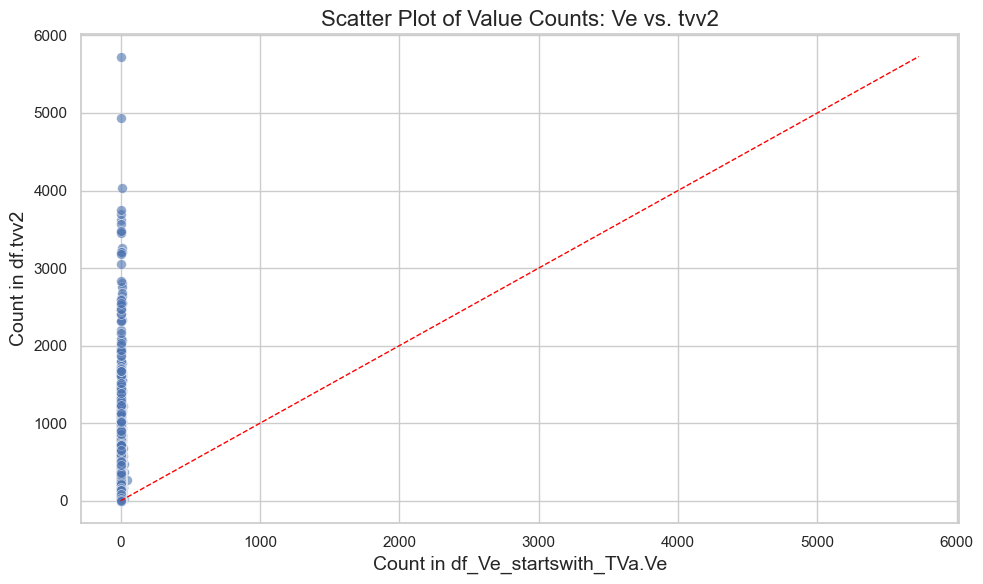

In [7]:
# Compute value counts for df_Ve_startswith_TVa.Ve
ve_counts = df_Ve_startswith_TVa['Ve'].value_counts()

# Compute value counts for df.tvv2
tvv2_counts = df['tvv2'].value_counts()

# Identify common unique values
common_values = ve_counts.index.intersection(tvv2_counts.index)

# Filter the counts to include only common values
ve_common = ve_counts[common_values]
tvv2_common = tvv2_counts[common_values]

# Create a DataFrame with counts from both sources
plot_df = pd.DataFrame({
    'Ve_Count': ve_common,
    'tvv2_Count': tvv2_common
})

# Set the style for the plot
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(
    data=plot_df,
    x='Ve_Count',
    y='tvv2_Count',
    s=50,
    alpha=0.6,
    edgecolor='w',
    linewidth=0.5
)

# Add title and labels
plt.title('Scatter Plot of Value Counts: Ve vs. tvv2', fontsize=16)
plt.xlabel('Count in df_Ve_startswith_TVa.Ve', fontsize=14)
plt.ylabel('Count in df.tvv2', fontsize=14)

# Optionally, add a diagonal line to indicate equality
max_count = max(plot_df['Ve_Count'].max(), plot_df['tvv2_Count'].max())
plt.plot([0, max_count], [0, max_count], color='red', linestyle='--', linewidth=1)

# Show the plot
plt.tight_layout()
plt.show()


one can see that a lot of values of df_Ve_startswith_TVa['Ve'] are also present in tvv, so they are propably simply errors in filling out the Ve column

In [13]:
# show the Values of Vdf_Ve_startswith_TVa['Ve'] that correspond to the values of df.tvv (here tvv2)
# with the highest value_counts()


# Compute value counts for df_Ve_startswith_TVa.Ve
ve_counts = df_Ve_startswith_TVa['Ve'].value_counts()

# Compute value counts for df.tvv2
tvv2_counts = df['tvv2'].value_counts()

# Identify common unique values between 'Ve' and 'tvv2'
common_values = ve_counts.index.intersection(tvv2_counts.index)

# Filter df_Ve_startswith_TVa to include only rows where 'Ve' is in common values
df_filtered_Ve = df_Ve_startswith_TVa[df_Ve_startswith_TVa['Ve'].isin(common_values)]

# Map the 'Ve' values in df_filtered_Ve to their corresponding counts in tvv2_counts
df_filtered_Ve = df_filtered_Ve.assign(counts=df_filtered_Ve['Ve'].map(tvv2_counts))

# Sort df_filtered_Ve by the counts (descending order) to prioritize the highest tvv2 value counts
df_sorted_Ve = df_filtered_Ve.sort_values(by='counts', ascending=False)

# Drop the 'counts' column if you don't need it
df_sorted_Ve = df_sorted_Ve.drop(columns='counts')

# Show the result
df_sorted_Ve


,ID,Country,VFN,Mp,Mh,Man,MMS,Tan,T,Va,Ve,Mk,Cn,Ct,Cr,r,m (kg),Mt,Enedc (g/km),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Ft,Fm,ec (cm3),ep (KW),z (Wh/km),IT,Ernedc (g/km),Erwltp (g/km),De,Vf,Status,year,Date of registration,Fuel consumption,ech,RLFI,Electric range (km),#identical occurences,tvv,T_str,Va_str,Ve_str
6829251,2801344,HR,NaN,PSA Group,AUTOMOBILES PEUGEOT,AUTOMOBILES PEUGEOT,AUTOMOBILES PEUGEOT,e2*2007/46*0534*13,M,4,M4DGZU-C1J000,PEUGEOT,3008,M1,M1,1.0,1835.0,1908.0,35.0,30.0,2675.0,1601.0,1610.0,PETROL,H,1598.0,133.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2020,NaN,NaN,NaN,NaN,NaN,1.0,M4M4DGZU-C1J000,M,4,M4DGZU-C1J000
9126582,56347527,HR,NaN,Stellantis,AUTOMOBILES PEUGEOT,AUTOMOBILES PEUGEOT,NaN,e2*2007/46*0534*13,M,4,M4DGZU-C1J000,PEUGEOT,3008,M1,M1,1.0,1835.0,1866.0,125.0,159.0,2675.0,1601.0,1610.0,PETROL,M,1598.0,133.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2021,2021-02-01,7.0,NaN,NaN,NaN,1.0,M4M4DGZU-C1J000,M,4,M4DGZU-C1J000
6872553,2729867,HR,IP-YHZ____ATN83143-VF3-0,PSA Group,AUTOMOBILES PEUGEOT,AUTOMOBILES PEUGEOT,AUTOMOBILES PEUGEOT,e2*2007/46*0534*15,M,C,MCYHZU-C2PC00,PEUGEOT,3008,M1,M1,1.0,1504.0,1568.0,104.0,137.0,2675.0,1601.0,1610.0,DIESEL,M,1499.0,96.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2020,NaN,NaN,NaN,NaN,NaN,1.0,MCMCYHZU-C2PC00,M,C,MCYHZU-C2PC00
6872554,2729868,HR,IP-YHZ____ATN83143-VF3-0,PSA Group,AUTOMOBILES PEUGEOT,AUTOMOBILES PEUGEOT,AUTOMOBILES PEUGEOT,e2*2007/46*0534*15,M,C,MCYHZU-C2PC00,PEUGEOT,3008,M1,M1,1.0,1504.0,1568.0,104.0,138.0,2675.0,1601.0,1610.0,DIESEL,M,1499.0,96.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2020,NaN,NaN,NaN,NaN,NaN,1.0,MCMCYHZU-C2PC00,M,C,MCYHZU-C2PC00
9126119,56346593,HR,IP-YHZ____ATN83143-VF3-0,Stellantis,AUTOMOBILES PEUGEOT,AUTOMOBILES PEUGEOT,NaN,e2*2007/46*0534*15,M,C,MCYHZU-C2PC00,PEUGEOT,3008,M1,M1,1.0,1504.0,1558.0,104.0,137.0,2675.0,1601.0,1610.0,DIESEL,M,1499.0,96.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2021,2021-01-27,5.2,NaN,NaN,NaN,3.0,MCMCYHZU-C2PC00,M,C,MCYHZU-C2PC00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520440,345476,PL,NaN,NaN,AUTOMOBILES CITROEN,AUTOMOBILES CITROEN,NaN,e3*2007/46*0046*10,Y,CUMFC,YCUMFC/HY,CITROEN,JUMPER,M1,NaN,1.0,2050.0,NaN,195.0,NaN,4035.0,1810.0,1790.0,DIESEL,M,2198.0,110.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2016,NaN,NaN,NaN,NaN,NaN,1.0,YCUMFCYCUMFC/HY,Y,CUMFC,YCUMFC/HY
2551164,446515,UK,NaN,NaN,RENAULT,RENAULT SAS,RENAULT,e2*2007/46*0546*05,RFB,BF2,RFBBF2MRB62A01000,RENAULT,MEGANE DYNAMIQUE S NAV TCE A,M1,NaN,1.0,1333.0,NaN,122.0,NaN,2670.0,1580.0,1583.0,PETROL,M,1197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,2017,NaN,NaN,NaN,NaN,NaN,1.0,RFBBF2RFBBF2MRB62A01000,RFB,BF2,RFBBF2MRB62A01000
2577902,463754,UK,NaN,NaN,RENAULT,RENAULT SAS,RENAULT,e11*2007/46*1106*04,L,FAR9,LFAR9MMJ1002612B10,RENAULT,TRAFIC LL29 SPORT NAV DCI,M1,NaN,1.0,2352.0,NaN,174.0,NaN,3498.0,1615.0,1628.0,DIESEL,M,1598.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,2017,NaN,NaN,NaN,NaN,NaN,1.0,LFAR9LFAR9MMJ1002612B10,L,FAR9,LFAR9MMJ1002612B10
2633651,437142,UK,NaN,NaN,RENAULT,RENAULT SAS,RENAULT,e2*2007/46*0475*06,RFE,HH2,RFEHH2A35ABB005000,RENAULT,KADJAR DYNAMIQUE S NAV DCI,M1,NaN,1.0,1469.0,NaN,103.0,NaN,2647.0,1562.0,1560.0,DIESEL,M,1461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,2017,NaN,NaN,NaN,NaN,NaN,1.0,RFEHH2RFEHH2A35ABB005000,RFE,HH2,RFEHH2A35ABB005000


In [14]:
# show the Values of df['tvv'] (here tvv2) that are common with Vdf_Ve_startswith_TVa['Ve'] 
# and have the highest value_counts()

# Compute value counts for df_Ve_startswith_TVa.Ve
ve_counts = df_Ve_startswith_TVa['Ve'].value_counts()

# Compute value counts for df.tvv2
tvv2_counts = df['tvv2'].value_counts()

# Identify common unique values between 'Ve' and 'tvv2'
common_values = ve_counts.index.intersection(tvv2_counts.index)

# Filter the DataFrame to include only rows where 'tvv2' contains common values
df_filtered_common = df[df['tvv2'].isin(common_values)]

# Sort the DataFrame based on the frequency of 'tvv2' (descending order)
df_sorted_by_counts = df_filtered_common.assign(counts=df_filtered_common['tvv2'].map(tvv2_counts)).sort_values(by='counts', ascending=False)

# Drop the 'counts' column if you don't need it anymore
#df_sorted_by_counts = df_sorted_by_counts.drop(columns='counts')

# Show the result
df_sorted_by_counts

,ID,Country,VFN,Mp,Mh,Man,MMS,Tan,T,Va,Ve,Mk,Cn,Ct,Cr,r,m (kg),Mt,Enedc (g/km),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Ft,Fm,ec (cm3),ep (KW),z (Wh/km),IT,Ernedc (g/km),Erwltp (g/km),De,Vf,Status,year,Date of registration,Fuel consumption,ech,RLFI,Electric range (km),#identical occurences,tvv,tvv2,counts
10853561,76120446,ES,NaN,Stellantis,AUTOMOBILES PEUGEOT,AUTOMOBILES PEUGEOT,NaN,e2*2007/46*0534*23,M,4,DGZU-C1J000,PEUGEOT,3008 GT PACK PLUG-IN HYBRID 225 E-EAT8,M1,M1,1.0,1838.0,1952.0,32.0,32.0,2675.0,1601.0,1610.0,PETROL/ELECTRIC,P,1598.0,133.0,157.0,NaN,NaN,NaN,NaN,NaN,P,2022,2022-09-27,NaN,NaN,NaN,61.0,1.0,M4DGZU-C1J000,M4DGZU-C1J000,5727
12024836,73319613,FI,IP-DGZ____EAT84552-VF3-0,Stellantis,AUTOMOBILES PEUGEOT,AUTOMOBILES PEUGEOT,NaN,e2*2007/46*0534*18,M,4,DGZU-C1J000,PEUGEOT,3008,M1,M1,1.0,1838.0,1962.0,NaN,32.0,2675.0,1601.0,1610.0,PETROL/ELECTRIC,P,1598.0,133.0,175.0,NaN,NaN,NaN,NaN,NaN,P,2022,2022-01-04,1.7,NaN,NaN,53.0,1.0,M4DGZU-C1J000,M4DGZU-C1J000,5727
7052155,10947941,NL,IP-DGZ____EAT84552-VF3-0,PSA Group,PSA,PSA AUTOMOBILES SA,AUTOMOBILES PEUGEOT,e2*2007/46*0534*14,M,4,DGZU-C1J000,PEUGEOT,3008,M1,M1,1.0,1835.0,1943.0,35.0,31.0,2680.0,1600.0,1610.0,PETROL/ELECTRIC,P,1598.0,30.0,155.0,NaN,NaN,NaN,NaN,NaN,P,2020,NaN,NaN,NaN,NaN,62.0,1.0,M4DGZU-C1J000,M4DGZU-C1J000,5727
7052154,10947940,NL,IP-DGZ____EAT84552-VF3-0,PSA Group,PSA,PSA AUTOMOBILES SA,AUTOMOBILES PEUGEOT,e2*2007/46*0534*14,M,4,DGZU-C1J000,PEUGEOT,3008,M1,M1,1.0,1835.0,1933.0,35.0,31.0,2680.0,1600.0,1610.0,PETROL/ELECTRIC,P,1598.0,30.0,155.0,NaN,NaN,NaN,NaN,NaN,P,2020,NaN,NaN,NaN,NaN,62.0,1.0,M4DGZU-C1J000,M4DGZU-C1J000,5727
12024831,73319603,FI,IP-DGZ____EAT84552-VF3-0,Stellantis,AUTOMOBILES PEUGEOT,AUTOMOBILES PEUGEOT,NaN,e2*2007/46*0534*17,M,4,DGZU-C1J000,PEUGEOT,3008,M1,M1,1.0,1835.0,1925.0,NaN,31.0,2675.0,1601.0,1610.0,PETROL/ELECTRIC,P,1598.0,133.0,175.0,NaN,NaN,NaN,NaN,NaN,P,2022,2022-04-14,1.7,NaN,NaN,53.0,1.0,M4DGZU-C1J000,M4DGZU-C1J000,5727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99099,271220,SK,NaN,NaN,AUTOMOBILES CITROEN,NaN,NaN,NaN,Y,BAMRB,YBAMRB,CITROEN,CITROEN JUMPER,M1,NaN,1.0,2120.0,NaN,NaN,NaN,NaN,NaN,NaN,DIESEL,M,2198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,2011,NaN,NaN,NaN,NaN,NaN,1.0,YBAMRBYBAMRB,YBAMRB,1
273227,212115,FR,NaN,Renault-Nissan Alliance,RENAULT,RENAULT SAS,RENAULT,e2*2007/46*0022*16,ML,J4,YF,RENAULT,MASTER,M1,NaN,1.0,2159.0,NaN,168.0,NaN,3682.0,1750.0,1730.0,DIESEL,M,2299.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2014,NaN,NaN,NaN,NaN,NaN,1.0,MLJ4YF,MLJ4YF,1
774553,285970,UK,NaN,NaN,AUTOMOBILES PEUGEOT,NaN,PEUGEOT,e8*2007/46*0005*02,7,JPHP,0,PEUGEOT,PARTNER TEPEE S HDI 92,M1,NaN,1.0,1550.0,NaN,NaN,NaN,NaN,NaN,NaN,DIESEL,M,1560.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,2011,NaN,NaN,NaN,NaN,NaN,1.0,7JPHP0,7JPHP0,1
7084186,11492523,FR,IP-04-YV1-2018-0051,Ford,VOLVO,VOLVO CAR CORPORATION,VOLVO CAR CORP,e4*2007/46*1315*08,Z,WA8,TDP?,VOLVO,V60,M1,M1,1.0,1752.0,1930.0,125.0,155.0,2872.0,1593.0,1593.0,DIESEL,M,1969.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2020,NaN,NaN,NaN,NaN,NaN,1.0,ZWA8TDP?,ZWA8TDP?,1


##### replace tvv with tvv2 (and drop tvv2)

In [6]:
df.tvv = df.tvv2

In [7]:
df = df.drop(['tvv2'], axis = 1)

### save with new tvv

replaced the old tvv with the new one which incorporates Tillmanns hint,  
i.e. replaces tvv with Ve where Ve startswith T + Va

In [12]:
df.to_parquet("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2.parquet")

#### read saved

In [43]:
df = pd.read_parquet("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2.parquet")

### tvv continued

In [11]:
df.tvv.value_counts()[:2000]

F2AX203T2EZAA151B                          12335
FMX21BSIAW50000                            10315
G3X61DPIAW50000                            10218
G5XTA61IAA5090A                             9312
G4C71AW0AC50000                             8837
                                           ...  
A1DPCAX0AC4FM6FM62S0324BF1CANN               988
Z-BCF094DB12BC1ZAWCABA5                      988
F4DGZT-R1E000                                988
FYSDRYAQ1QD7AD7DK002RT61B184BIAEM8FSB30      988
F5LMJF01DAW5E0V0                             987
Name: tvv, Length: 2000, dtype: int64

In [33]:
df[df["T"].notna() & df["Va"].notna() & df["Ve"].notna()].tvv.nunique()

394986

In [34]:
df[df["T"].notna() & df["Va"].notna() & df["Ve"].isna()].tvv.nunique()

0

In [35]:
df[df["T"].isna() | df["Va"].isna() | df["Ve"].isna()].shape[0]

245331

In [36]:
# df of rows with at least one of T, Va, Ve missing (tvv not calculated)
df_tvv_miss = df[df["T"].isna() | df["Va"].isna() | df["Ve"].isna()]

In [37]:
# are specific coutries overrepresented in having one of T Va Ve missing??
df_tvv_miss_share = df_tvv_miss["Country"].value_counts() / df_tvv_miss.shape[0]
df_share = df["Country"].value_counts() / df.shape[0]

df_tvv_miss_share / df_share


AT     0.069193
BE     0.243760
BG     0.300708
CY     0.020949
CZ     0.135888
DE     1.022641
DK     1.079316
EE     0.136425
ES     1.869549
FI     0.555569
FR     0.541574
GR     0.130275
HR     0.041315
HU     0.032850
IE     0.095444
IS     0.277941
IT     1.164432
LT     0.214267
LU     0.361182
LV     0.208934
MT     0.009484
NL     0.230495
NO     0.132048
PL     0.369641
PT     0.170816
RO     0.100531
SE     0.703559
SI     0.668812
SK    15.702041
UK     1.018256
Name: Country, dtype: float64

In [39]:
# Check out Slovakia (hugely overrrepresented in missing at least one of T, Va, Ve)
df[df["Country"] == "SK"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258416 entries, 12819 to 14108283
Data columns (total 42 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   ID                     258416 non-null  float32 
 1   Country                258416 non-null  category
 2   VFN                    95378 non-null   category
 3   Mp                     231249 non-null  category
 4   Mh                     258416 non-null  category
 5   Man                    252063 non-null  category
 6   MMS                    145269 non-null  category
 7   Tan                    231647 non-null  category
 8   T                      258351 non-null  category
 9   Va                     258213 non-null  category
 10  Ve                     189550 non-null  category
 11  Mk                     258416 non-null  category
 12  Cn                     258414 non-null  category
 13  Ct                     258412 non-null  category
 14  Cr            

## split electric and combustion

In [40]:
# split electric and pure combustion

df_electric = df[df["Electric range (km)"] > 0]
df_combustion = df[~(df["Electric range (km)"] > 0)]

In [41]:
# confrim split

len(df_combustion) + len(df_electric) == len(df)

True

## IT, Ernedc, Erwltp

### explore

In [ ]:
df.IT.value_counts()

e1 29               348575
E1 29               206902
e8 29 37            184344
e13 29 37           141103
e13 29              135410
                     ...  
e4 / e4 28               1
E2 E2 29                 1
E2 37 029                1
e4 17 19e4 29 28         1
no                       1
Name: IT, Length: 1928, dtype: int64

<Axes: >

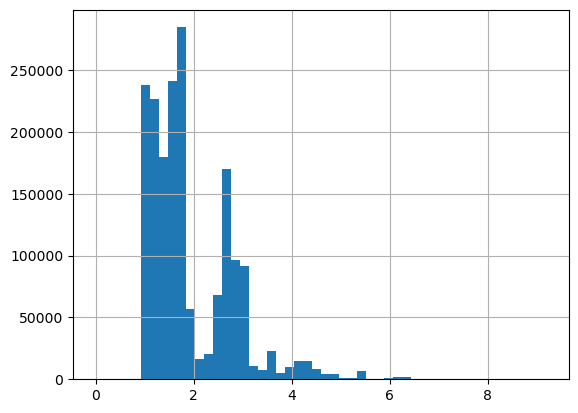

In [ ]:
df["Ernedc (g/km)"].hist(bins = 50)

(0.0, 5.0)

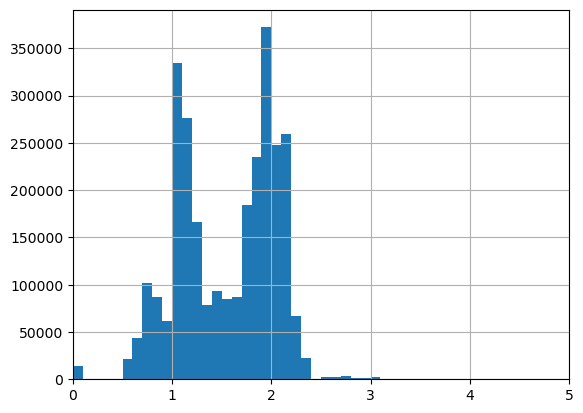

In [ ]:
df["Erwltp (g/km)"].hist(bins = 200)
plt.xlim(0,5)

### clean

#### f: remove spaces

In [11]:
def strip_and_count(series):
    # Convert to string, strip spaces while handling pd.NA, then convert back to category
    stripped_series = series.astype('string').apply(lambda x: x.strip() if pd.notna(x) else x)
    
    # Count how many elements were stripped (excluding pd.NA elements)
    stripped_count = (series.astype('string').fillna('') != stripped_series.fillna('')).sum()
    
    # Convert back to category
    stripped_series = stripped_series.astype('category')

    return stripped_series, stripped_count


In [44]:
df['IT'], c = strip_and_count(df['IT'])
print(f"{c} elements have been stripped")

94702 elements have been stripped


#### f: convert "E" to "e"

In [53]:
def E_to_e_and_count(series):
    # Convert to string, replace all 'E' with 'e' while handling pd.NA, then convert back to category
    modified_series = series.astype('string').apply(lambda x: x.replace('E', 'e') if pd.notna(x) else x)

    # Count how many elements were changed (excluding pd.NA elements)
    changed_count = (series.astype('string').fillna('') != modified_series.fillna('')).sum()

    # Convert back to category
    modified_series = modified_series.astype('category')

    return modified_series, changed_count



In [54]:
df['IT'], c = E_to_e_and_count(df['IT'])
print(f"{c} elements have been lowercased")

0 elements have been lowercased


In [47]:
df['IT'].nunique()

1373

In [48]:
vc = df['IT'].value_counts()
for n in range(20):
    print(n,": ",(vc>n).sum())

0 :  1373
1 :  1048
2 :  945
3 :  874
4 :  827
5 :  789
6 :  758
7 :  731
8 :  706
9 :  684
10 :  667
11 :  650
12 :  638
13 :  622
14 :  615
15 :  605
16 :  595
17 :  591
18 :  586
19 :  577


#### save/read

In [50]:
df.to_parquet("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT.parquet")

In [74]:
df = pd.read_parquet("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT.parquet")

#### f:filter blocks

In [49]:
import pandas as pd
import re

def filter_and_count_blocks(series):
    # Define the regex pattern:
    # Starts with 'e' + digits, followed by optional blocks separated by spaces with either digits or 'e' + digits
    pattern = re.compile(r'^e\d+( (\d+|e\d+))*$')

    # Count initial number of NA values in the series
    initial_na_count = series.isna().sum()

    # Convert to string, handle pd.NA, and apply the regex pattern
    filtered_series = series.astype('string').apply(lambda x: x if pd.notna(x) and pattern.match(x) else pd.NA)

    # Count the final number of NA values after filtering
    final_na_count = filtered_series.isna().sum()

    # The number of dropped lines is the difference between final and initial NA counts
    dropped_count = final_na_count - initial_na_count

    # Function to count the number of blocks
    def count_blocks(value):
        if pd.isna(value):
            return pd.NA
        # Split the valid string by spaces to count blocks
        return len(value.split())

    # Apply the block counting
    block_counts = filtered_series.apply(count_blocks)

    # Count how many strings have 1 block, 2 blocks, 3 blocks, etc.
    block_summary = block_counts.value_counts(dropna=False)

    # Return the filtered series, block summary, and count of dropped lines
    return filtered_series.astype('category'), block_summary, dropped_count



In [75]:
df['IT'], block_summary, block_count = filter_and_count_blocks(df['IT'])
print("\nBlock Summary:\n", block_summary, "\ncount", block_count)


Block Summary:
 <NA>    9790064
2       2537168
3       1963887
4         97814
5         49200
1          2657
6          1884
8           115
10            3
Name: IT, dtype: int64 
count 226030


In [76]:
df['IT'].nunique()

795

#### save/read

In [77]:
df.to_parquet("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT2.parquet")

In [91]:
df = pd.read_parquet("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT2.parquet")

#### save unique values for external analysis (ChatGPT)

In [63]:
# Save the unique values to a CSV file
unique_values = pd.Series(df['IT'].unique())
unique_values.to_csv('unique_values.csv', index=False)

print("Unique values have been saved to 'unique_values.csv'.")


Unique values have been saved to 'unique_values.csv'.


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442792 entries, 0 to 14442791
Data columns (total 42 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   ID                     Int64   
 1   Country                category
 2   VFN                    category
 3   Mp                     category
 4   Mh                     category
 5   Man                    category
 6   MMS                    category
 7   Tan                    category
 8   T                      category
 9   Va                     category
 10  Ve                     category
 11  Mk                     category
 12  Cn                     category
 13  Ct                     category
 14  Cr                     category
 15  r                      float32 
 16  m (kg)                 float32 
 17  Mt                     float32 
 18  Enedc (g/km)           float32 
 19  Ewltp (g/km)           float32 
 20  W (mm)                 float32 
 21  At1 (mm)               float3

#### f: split IT in 5 columns

In [93]:
import pandas as pd
import re

# Regular expression to match valid 'eXX XX', 'eX XX', 'eX X', 'eXX X' patterns
valid_pattern = re.compile(r'e\d{1,2} \d{1,2}')

def split_technologies(series):
    """
    Split combined 'eXX XX', 'eX XX', 'eX X', 'eXX X' codes into individual columns.
    Handles NA values properly and ensures categorical dtype is preserved.
    
    Parameters:
    series (pd.Series): The Series containing the combined codes (categorical).

    Returns:
    pd.DataFrame: A DataFrame with individual technology columns.
    """
    # Step 1: Convert series from categorical to string for manipulation
    series_str = series.astype('string')

    # Step 2: Define a function to split valid patterns
    def extract_codes(value):
        if pd.isna(value):
            return []
        # Find all valid matches for the pattern
        matches = valid_pattern.findall(value)
        return matches if matches else []
    
    # Step 3: Apply the extraction function to split the strings into valid components
    split_series = series_str.apply(extract_codes)
    
    # Step 4: Find the maximum number of technologies in any entry
    max_technologies = split_series.apply(len).max()

    # Step 5: Convert the list of codes into a DataFrame with separate columns
    tech_df = pd.DataFrame(split_series.tolist(), columns=[f'tech_{i+1}' for i in range(max_technologies)])
    
    # Step 6: Handle missing values by converting to category and replacing NaNs with a missing value label
    tech_df = tech_df.apply(lambda col: col.astype('category').cat.add_categories(['Missing']).fillna('Missing'))
    
    return tech_df

# Call the function to split technologies
tech_df = split_technologies(df['IT'])

# Display the resulting DataFrame with split technologies
print(tech_df)


           tech_1   tech_2   tech_3   tech_4   tech_5
0         Missing  Missing  Missing  Missing  Missing
1         Missing  Missing  Missing  Missing  Missing
2         Missing  Missing  Missing  Missing  Missing
3         Missing  Missing  Missing  Missing  Missing
4         Missing  Missing  Missing  Missing  Missing
...           ...      ...      ...      ...      ...
14442787  Missing  Missing  Missing  Missing  Missing
14442788  Missing  Missing  Missing  Missing  Missing
14442789    e6 37  Missing  Missing  Missing  Missing
14442790  Missing  Missing  Missing  Missing  Missing
14442791    e6 37  Missing  Missing  Missing  Missing

[14442792 rows x 5 columns]


#### f: Count unique in all 5 columns 

In [95]:
import pandas as pd
import re

# Regular expressions to match the different cases
pattern_ex_x = re.compile(r'e\d \d')        # eX X (e.g., "e1 2")
pattern_ex_xx = re.compile(r'e\d \d{2}')    # eX XX (e.g., "e1 23")
pattern_exx_x = re.compile(r'e\d{2} \d')    # eXX X (e.g., "e12 3")
pattern_exx_xx = re.compile(r'e\d{2} \d{2}')# eXX XX (e.g., "e12 34")

def classify_and_count(df):
    """
    Classify and count unique values across columns and determine how many match each pattern (eX X, eX XX, etc.).

    Parameters:
    df (pd.DataFrame): The DataFrame containing the split technology columns.

    Returns:
    dict: A dictionary with counts of unique values and the classification of each pattern.
    """
    # Step 1: Concatenate all columns into one Series for unique value counting
    combined_series = pd.concat([df[col] for col in df.columns])

    # Step 2: Get the unique values and sort them
    unique_values = sorted(combined_series.unique())

    # Step 3: Initialize counters for each category
    counts = {
        'eX X': 0,
        'eX XX': 0,
        'eXX X': 0,
        'eXX XX': 0,
        'Missing': 0,
        'Invalid': 0
    }

    # Step 4: Classify each unique value based on the patterns
    for value in unique_values:
        if pd.isna(value) or value == 'Missing':
            counts['Missing'] += 1
        elif pattern_ex_x.fullmatch(value):
            counts['eX X'] += 1
        elif pattern_ex_xx.fullmatch(value):
            counts['eX XX'] += 1
        elif pattern_exx_x.fullmatch(value):
            counts['eXX X'] += 1
        elif pattern_exx_xx.fullmatch(value):
            counts['eXX XX'] += 1
        else:
            counts['Invalid'] += 1

    # Step 5: Return the counts and sorted unique values for reference
    return {
        'sorted_unique_values': unique_values,
        'counts': counts
    }

# Example usage with the previously generated DataFrame (tech_df)
result = classify_and_count(tech_df)

# Display the result
print("Sorted unique values:\n", result['sorted_unique_values'])
print("\nCounts:\n", result['counts'])


Sorted unique values:
 ['Missing', 'e01 2', 'e1 0', 'e1 02', 'e1 08', 'e1 10', 'e1 12', 'e1 13', 'e1 14', 'e1 17', 'e1 18', 'e1 19', 'e1 2', 'e1 28', 'e1 29', 'e1 3', 'e1 32', 'e1 33', 'e1 37', 'e1 4', 'e1 7', 'e1 8', 'e1 9', 'e11 1', 'e11 11', 'e11 17', 'e11 19', 'e11 2', 'e11 20', 'e11 28', 'e11 29', 'e11 32', 'e12 17', 'e12 28', 'e12 29', 'e13 1', 'e13 13', 'e13 15', 'e13 17', 'e13 18', 'e13 19', 'e13 20', 'e13 21', 'e13 22', 'e13 25', 'e13 27', 'e13 28', 'e13 29', 'e13 3', 'e13 32', 'e13 33', 'e13 37', 'e13 38', 'e13 39', 'e13 7', 'e14 17', 'e16 15', 'e16 29', 'e17 19', 'e17 28', 'e17 29', 'e18 28', 'e19 1', 'e19 17', 'e19 19', 'e19 28', 'e19 29', 'e19 37', 'e19 9', 'e2 0', 'e2 12', 'e2 14', 'e2 17', 'e2 18', 'e2 19', 'e2 20', 'e2 22', 'e2 24', 'e2 28', 'e2 29', 'e2 32', 'e2 33', 'e2 37', 'e2 38', 'e2 4', 'e2 43', 'e23 29', 'e24 1', 'e24 10', 'e24 14', 'e24 17', 'e24 18', 'e24 19', 'e24 2', 'e24 25', 'e24 27', 'e24 28', 'e24 29', 'e24 3', 'e24 32', 'e24 37', 'e24 38', 'e24 39', 'e2

In [96]:
def get_value_counts(df):
    """
    Get value counts of all unique values across the 5 technology columns.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the split technology columns.

    Returns:
    pd.Series: A Series showing the frequency of each unique value across all columns.
    """
    # Step 1: Concatenate all columns into a single Series
    combined_series = pd.concat([df[col] for col in df.columns])

    # Step 2: Use value_counts() to count the occurrences of each unique value
    value_counts = combined_series.value_counts()

    return value_counts

# Example usage with the previously generated DataFrame (tech_df)
value_counts = get_value_counts(tech_df)

# Display the value counts
print(value_counts)


Missing    67536418
e1 29        626904
e13 29       332382
e8 29        220273
e1 2         189102
             ...   
e27 19            1
e16 15            1
e11 1             1
e4 34             1
e2 38             1
Length: 188, dtype: int64


In [117]:
for n in [2**x for x in range (20)]:
    print("number of unique values with value_count greater than ",n,": ",(value_counts>n).sum())

number of unique values with value_count greater than  1 :  153
number of unique values with value_count greater than  2 :  139
number of unique values with value_count greater than  4 :  126
number of unique values with value_count greater than  8 :  118
number of unique values with value_count greater than  16 :  114
number of unique values with value_count greater than  32 :  107
number of unique values with value_count greater than  64 :  103
number of unique values with value_count greater than  128 :  96
number of unique values with value_count greater than  256 :  92
number of unique values with value_count greater than  512 :  86
number of unique values with value_count greater than  1024 :  81
number of unique values with value_count greater than  2048 :  74
number of unique values with value_count greater than  4096 :  67
number of unique values with value_count greater than  8192 :  56
number of unique values with value_count greater than  16384 :  47
number of unique values

#### save/read

In [119]:
df.to_parquet("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT3.parquet")

In [ ]:
df = pd.read_parquet("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2_IT3.parquet")

## Brand/Manufacturer


In [ ]:
df.MMS.value_counts()

VOLKSWAGEN AG                                 448682
VOLKSWAGEN-VW                                 435404
AUDI                                          385966
BAYERISCHE MOTOREN WERKE AG                   347039
DAIMLER AG                                    313773
                                               ...  
ADAM OPEL GMBH S-D FE11 2A08B3UEAH5                1
ADAM OPEL GMBH S-D FE11 2A08B3UJGE5                1
ADAM OPEL GMBH S-D FE11 2A08B3UJGH5                1
JAGUAR JFALG8B  XJ6 3.2                 ST         1
FIAT GROUP AUTOMOBILES SPA 270XXF1B AA2            1
Name: MMS, Length: 11561, dtype: int64

## Mk (Make)


In [ ]:
df.Mk.value_counts().iloc[50:100]

FIAT - INNOCENTI        15275
TESLA                   12429
Ford                    11714
SSANGYONG                9940
BMW I                    9276
MERCEDESBENZ             9233
Seat                     8728
LANCIA                   8717
Hyundai                  8584
                         8254
?KODA                    6849
OPEL VAUXHALL            6304
FORD (D)                 6236
INFINITI                 5983
CHRYSLER                 5696
VOLKSWAGEN,VW            5682
Renault                  5606
BENTLEY                  5594
Mazda                    5466
VOLKSWAGENVWVW           5386
POLESTAR                 5007
FERRARI                  4149
SAAB                     3997
ASTON MARTIN             3907
Peugeot                  3658
Volvo                    3587
Land Rover               3552
Dacia                    3181
LAMBORGHINI              3157
Toyota                   3011
DODGE                    2948
FORD-CNG-TECHNIK         2876
Porsche                  2818
LOTUS     

## r (Total new registrations)

In [51]:
df.r.value_counts().iloc[:]

6439.0     1
4452.0     1
6189.0     1
12200.0    1
7929.0     1
11383.0    1
11337.0    1
7866.0     1
4544.0     1
3088.0     1
5450.0     1
5583.0     1
16562.0    1
6823.0     1
2116.0     1
3639.0     1
6489.0     1
5158.0     1
5349.0     1
3929.0     1
Name: r, dtype: int64

In [52]:
df.r.value_counts().head(20).index

Float64Index([ 1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0,
              12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0],
             dtype='float64')

In [54]:
# Get the 20 largest values from the 'r' column
df['r'].nlargest(20)


2708852    59092.0
1007934    44798.0
641314     41936.0
1008769    34433.0
2101980    33617.0
2707166    33160.0
1832214    32986.0
2707574    31606.0
1008824    31264.0
1813190    30965.0
981420     30703.0
1831850    29935.0
1908006    29576.0
2101977    28952.0
2707484    28677.0
1781694    28324.0
966340     27113.0
1831855    25752.0
966235     24660.0
1239413    23807.0
Name: r, dtype: float32

### The car that is registered most often: Fiat Panda

What does this number mean? Does that mean that the same car type with the same characteristics has been registered 59092 times? Strange...at least it has no date of registration. 

In [55]:
df.loc[2708852]

ID                              1847768.0
Country                                IT
VFN                                   NaN
Mp                          FCA ITALY SPA
Mh                             FIAT GROUP
Man                         FCA ITALY SPA
MMS                      FCA ITALY S.P.A.
Tan                       e3*2007/46*0064
T                                     312
Va                                  PXA1A
Ve                                   P0AB
Mk                                   FIAT
Cn                                  PANDA
Ct                                     M1
Cr                                     M1
r                                 59092.0
m (kg)                             1015.0
Mt                                    NaN
Enedc (g/km)                        119.0
Ewltp (g/km)                          NaN
W (mm)                             2300.0
At1 (mm)                           1409.0
At2 (mm)                           1407.0
Ft                                

In [15]:
df[df["Tan"] == "e3*2007/46*0064"]["r"].value_counts().iloc[:100]

1.0       97
2.0       12
6.0        7
5.0        6
3.0        6
          ..
60.0       1
529.0      1
1032.0     1
6650.0     1
118.0      1
Name: r, Length: 100, dtype: int64

In [16]:
df[df["Tan"] == "e3*2007/46*0064"]["tvv"].value_counts().iloc[:100]

312AXA1A00AW    7
312PXW2AP14H    6
312AXA1A00AN    6
312AXA1A00AR    6
312PXA1AP0AB    4
               ..
312PXU1AP12     1
312AXA1103AC    1
312AXA1103AD    1
312AXA1A00AV    1
312AYA1A22      1
Name: tvv, Length: 100, dtype: int64

### is "Date of registration" present in all years?

In [57]:
df[df["Date of registration"].isna()].year.value_counts()

2019.0    2588053
2020.0    2142188
2018.0    1240905
2016.0     444106
2015.0     431559
2017.0     424145
2014.0     398047
2013.0     380634
2011.0     310767
2012.0     307442
2010.0     272279
2021.0     236195
2022.0      30541
Name: year, dtype: int64

#### Calculate ratio of NA to non-NA

In [58]:
# Calculate the count of NaN values in 'Date of registration' per year
na_counts_per_year = df[df['Date of registration'].isna()]['year'].value_counts().sort_index()

# Calculate the count of non-NaN values in 'Date of registration' per year
non_na_counts_per_year = df[df['Date of registration'].notna()]['year'].value_counts().sort_index()

# Calculate the total counts per year (optional)
total_counts_per_year = df['year'].value_counts().sort_index()

# Align the series to ensure they have the same index (years)
na_counts_per_year, non_na_counts_per_year = na_counts_per_year.align(non_na_counts_per_year, fill_value=0)
na_counts_per_year, total_counts_per_year = na_counts_per_year.align(total_counts_per_year, fill_value=0)

# Compute the ratio of NaN to non-NaN values per year
ratio_na_non_na = na_counts_per_year / non_na_counts_per_year

# Compute the ratio of NaN to total counts per year (optional)
ratio_na_total = na_counts_per_year / total_counts_per_year

# Combine the results into a DataFrame for better visualization
result_df = pd.DataFrame({
    'NaN Counts': na_counts_per_year,
    'Non-NaN Counts': non_na_counts_per_year,
    'Total Counts': total_counts_per_year,
    'NaN to Non-NaN Ratio': ratio_na_non_na,
    'NaN to Total Ratio': ratio_na_total
}).fillna(0)

# Display the result
print(result_df)


        NaN Counts  Non-NaN Counts  Total Counts  NaN to Non-NaN Ratio  \
2010.0    272279.0             0.0        272279                   inf   
2011.0    310767.0             0.0        310767                   inf   
2012.0    307442.0             0.0        307442                   inf   
2013.0    380634.0             0.0        380634                   inf   
2014.0    398047.0             0.0        398047                   inf   
2015.0    431559.0             0.0        431559                   inf   
2016.0    444106.0             0.0        444106                   inf   
2017.0    424145.0             0.0        424145                   inf   
2018.0   1240905.0             0.0       1240905                   inf   
2019.0   2588053.0             0.0       2588053                   inf   
2020.0   2142188.0             0.0       2142188                   inf   
2021.0    236195.0       1651658.0       1887853              0.143005   
2022.0     30541.0       1780157.0    

#### See if r is only more than 1 when Dates kick in 

In [59]:
# Ensure 'year' column exists; if not, extract it from 'Date of registration' or the appropriate date column
# Assuming 'year' column already exists as per your statement

# Calculate the count where df.r == 1 per year
r_eq_1_counts = df[df['r'] == 1]['year'].value_counts().sort_index()

# Calculate the count where df.r != 1 per year
r_neq_1_counts = df[df['r'] != 1]['year'].value_counts().sort_index()

# Calculate total counts per year (optional but useful)
total_counts_per_year = df['year'].value_counts().sort_index()

# Align the series to ensure they have the same index (years)
r_eq_1_counts, r_neq_1_counts = r_eq_1_counts.align(r_neq_1_counts, fill_value=0)
r_eq_1_counts, total_counts_per_year = r_eq_1_counts.align(total_counts_per_year, fill_value=0)

# Compute the ratio of df.r == 1 to df.r != 1 per year
ratio_r_eq_1_to_r_neq_1 = r_eq_1_counts / r_neq_1_counts

# Compute the ratio of df.r == 1 to total counts per year (optional)
ratio_r_eq_1_to_total = r_eq_1_counts / total_counts_per_year

# Combine the results into a DataFrame for better visualization
result_df = pd.DataFrame({
    'r == 1 Counts': r_eq_1_counts,
    'r != 1 Counts': r_neq_1_counts,
    'Total Counts': total_counts_per_year,
    'r == 1 to r != 1 Ratio': ratio_r_eq_1_to_r_neq_1,
    'r == 1 to Total Ratio': ratio_r_eq_1_to_total
}).fillna(0)

# Display the result
print(result_df)


        r == 1 Counts  r != 1 Counts  Total Counts  r == 1 to r != 1 Ratio  \
2010.0         106601       165678.0        272279            6.434228e-01   
2011.0         118006       192761.0        310767            6.121882e-01   
2012.0         131191       176251.0        307442            7.443419e-01   
2013.0         158546       222088.0        380634            7.138882e-01   
2014.0         161585       236462.0        398047            6.833445e-01   
2015.0         170562       260997.0        431559            6.535018e-01   
2016.0         177948       266158.0        444106            6.685803e-01   
2017.0         260488       163657.0        424145            1.591670e+00   
2018.0        1240885           20.0       1240905            6.204425e+04   
2019.0        2588043           10.0       2588053            2.588043e+05   
2020.0        2142188            0.0       2142188                     inf   
2021.0        1887853            0.0       1887853              

#### Bingo! From 2018 on it's basically always 1, i.e they switched from groups/types to individual registrations.

## Tan

In [16]:
# Temporary copy of the 'Tan' column as strings
tan_temp = df['Tan'].astype(str)

# Masks for each category
begins_with_e = tan_temp.str.startswith('e', na=False)
not_begin_e = ~begins_with_e & df['Tan'].notna()
na_values = df['Tan'].isna()

# Counts for each category
count_begins_with_e = begins_with_e.sum()
count_not_begin_e = not_begin_e.sum()
count_na = na_values.sum()

# Print the counts
print("Values beginning with 'e':", count_begins_with_e)
print("Values not beginning with 'e' and not NA:", count_not_begin_e)
print("NA values:", count_na)

Values beginning with 'e': 13942187
Values not beginning with 'e' and not NA: 10062
NA values: 490543


In [17]:
# Number of unique combinations of 'tvv' and 'Tan'
unique_count = df.drop_duplicates(subset=['tvv', 'Tan']).shape[0]
print("Number of unique combinations:", unique_count)

Number of unique combinations: 989825


In [18]:
# Number of unique 'Tan' values
unique_tan = df['Tan'].nunique()
print("Number of unique 'Tan' values:", unique_tan)

# Number of unique 'tvv' values
unique_tvv = df['tvv'].nunique()
print("Number of unique 'tvv' values:", unique_tvv)


Number of unique 'Tan' values: 49909
Number of unique 'tvv' values: 394986


In [19]:
# Number of unique 'tvv' per 'Tan'
tvv_per_tan = df.groupby('Tan')['tvv'].nunique()
print("Number of unique 'tvv' per 'Tan':")
print(tvv_per_tan)

# Number of unique 'Tan' per 'tvv'
tan_per_tvv = df.groupby('tvv')['Tan'].nunique()
print("\nNumber of unique 'Tan' per 'tvv':")
print(tan_per_tvv)

Number of unique 'tvv' per 'Tan':
Tan
                         174
 e1*2007/46*1678*00       20
 e1*98/14*0170*27          1
(e13*2007/46*2315*02)      2
*                          2
                        ... 
zy045724                   0
zy045820                   1
zy046565                   0
Ãˆ13*2001/116*0109*47      1
Ð•34016508/11.12.2018      1
Name: tvv, Length: 49909, dtype: int64

Number of unique 'Tan' per 'tvv':
tvv
                   54
  D                 1
 '''''              1
 --                 1
 072EM1NZAAA520     1
                   ..
Î§XZACXZACVC0?      1
Î§XZACXZACVC??      1
Î§XZACXZACVD0?      1
Î§XZACXZACVD??      1
Ð¥3WY315B           0
Name: Tan, Length: 394986, dtype: int64


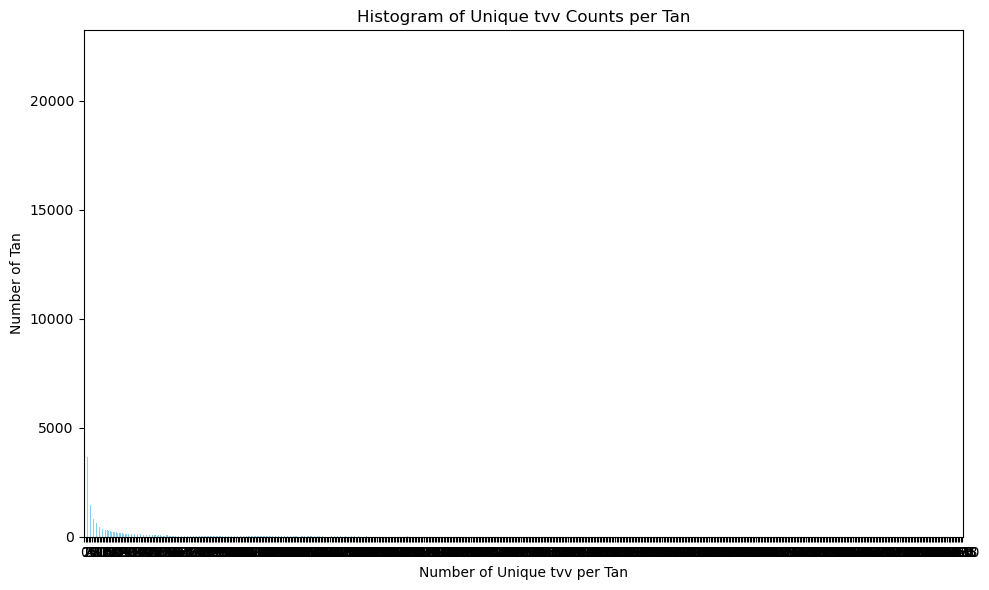

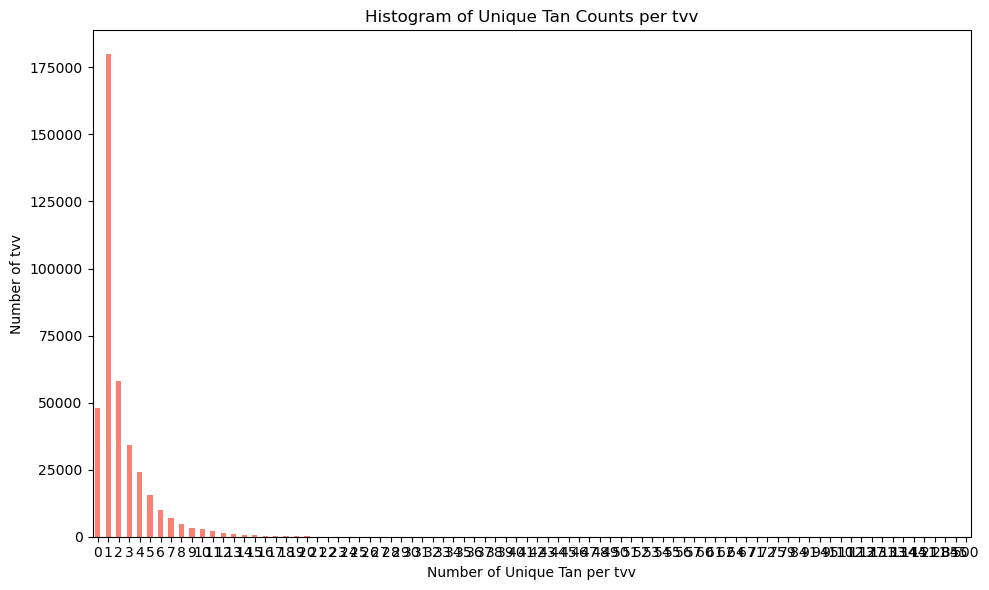

In [22]:
# 2 Histograms

# Calculate the number of unique 'tvv' per 'Tan'
tvv_per_tan = df.groupby('Tan')['tvv'].nunique()

# Calculate the number of unique 'Tan' per 'tvv'
tan_per_tvv = df.groupby('tvv')['Tan'].nunique()

# Histogram: Number of 'Tan's per number of unique 'tvv's
plt.figure(figsize=(10, 6))
tvv_counts = tvv_per_tan.value_counts().sort_index()
tvv_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Number of Unique tvv per Tan')
plt.ylabel('Number of Tan')
plt.title('Histogram of Unique tvv Counts per Tan')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Histogram: Number of 'tvv's per number of unique 'Tan's
plt.figure(figsize=(10, 6))
tan_counts = tan_per_tvv.value_counts().sort_index()
tan_counts.plot(kind='bar', color='salmon')
plt.xlabel('Number of Unique Tan per tvv')
plt.ylabel('Number of tvv')
plt.title('Histogram of Unique Tan Counts per tvv')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


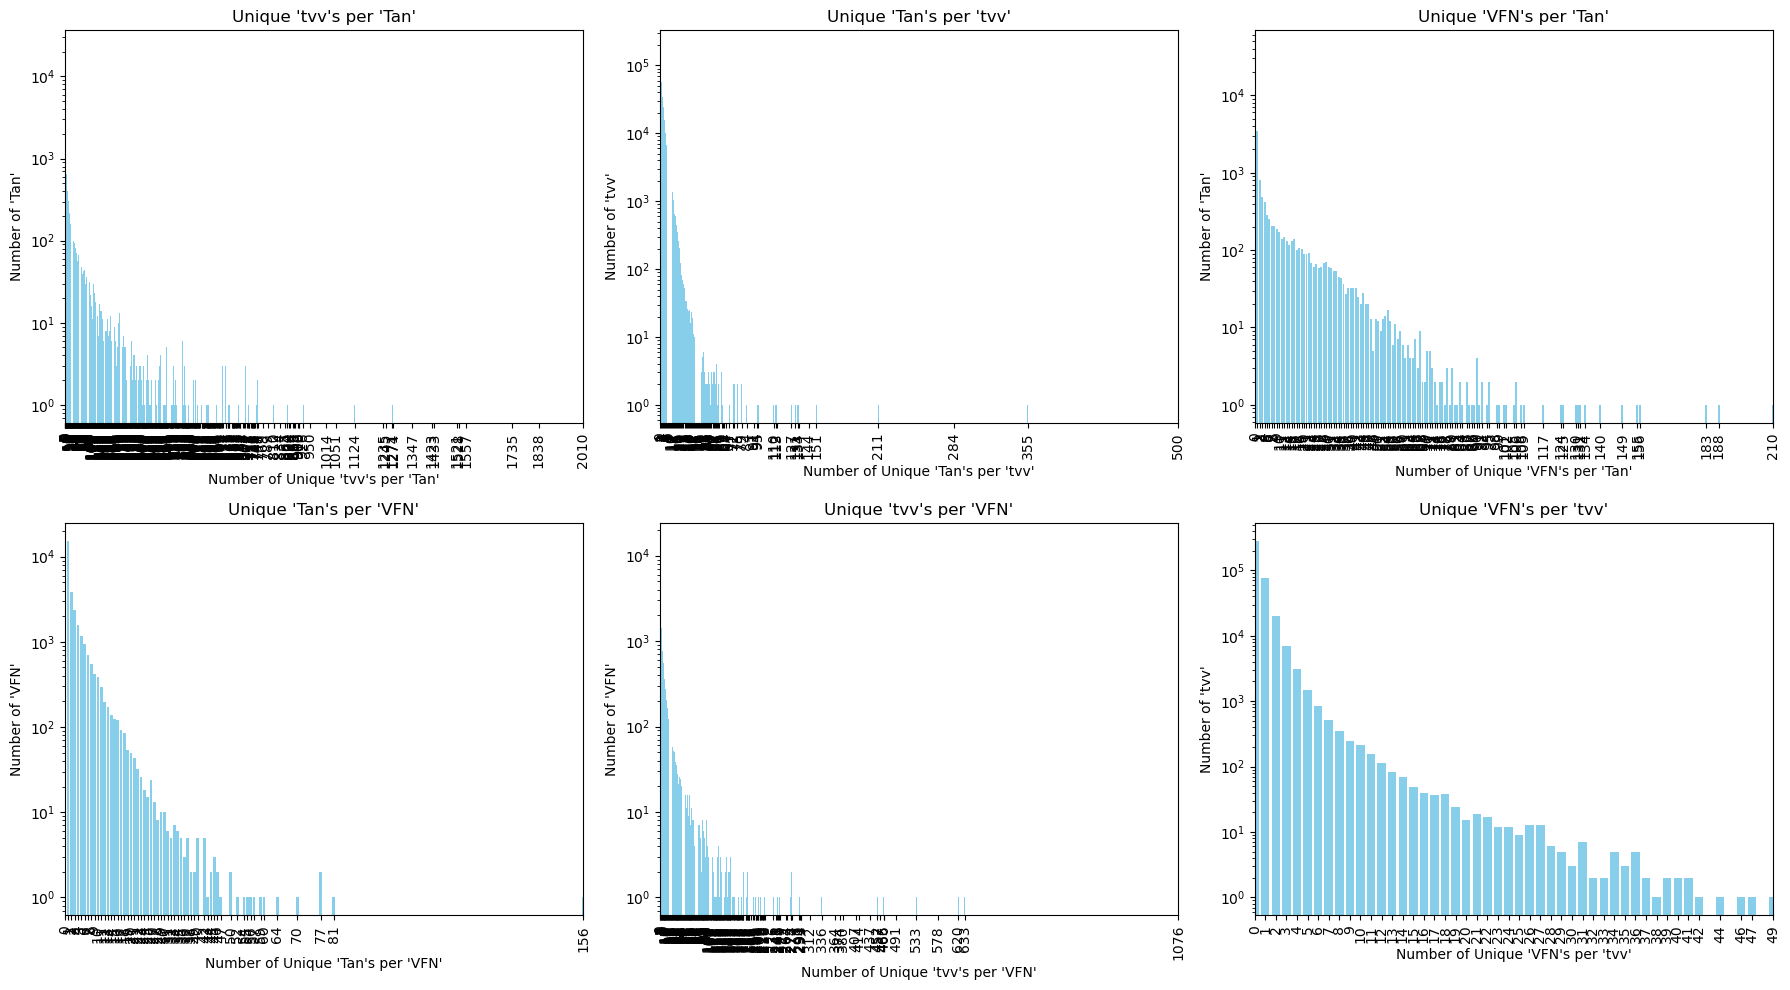

In [26]:
# 6 Histograms


# Compute counts for each combination
tvv_per_Tan = df.groupby('Tan')['tvv'].nunique()
Tan_per_tvv = df.groupby('tvv')['Tan'].nunique()
VFN_per_Tan = df.groupby('Tan')['VFN'].nunique()
Tan_per_VFN = df.groupby('VFN')['Tan'].nunique()
tvv_per_VFN = df.groupby('VFN')['tvv'].nunique()
VFN_per_tvv = df.groupby('tvv')['VFN'].nunique()

# Prepare data for histograms
data_list = [
    (tvv_per_Tan.value_counts().sort_index(), "Unique 'tvv's per 'Tan'", "Number of Unique 'tvv's per 'Tan'", "Number of 'Tan'"),
    (Tan_per_tvv.value_counts().sort_index(), "Unique 'Tan's per 'tvv'", "Number of Unique 'Tan's per 'tvv'", "Number of 'tvv'"),
    (VFN_per_Tan.value_counts().sort_index(), "Unique 'VFN's per 'Tan'", "Number of Unique 'VFN's per 'Tan'", "Number of 'Tan'"),
    (Tan_per_VFN.value_counts().sort_index(), "Unique 'Tan's per 'VFN'", "Number of Unique 'Tan's per 'VFN'", "Number of 'VFN'"),
    (tvv_per_VFN.value_counts().sort_index(), "Unique 'tvv's per 'VFN'", "Number of Unique 'tvv's per 'VFN'", "Number of 'VFN'"),
    (VFN_per_tvv.value_counts().sort_index(), "Unique 'VFN's per 'tvv'", "Number of Unique 'VFN's per 'tvv'", "Number of 'tvv'")
]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot histograms
for ax, (data, title, xlabel, ylabel) in zip(axes, data_list):
    ax.bar(data.index, data.values, color='skyblue')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Adjust x-axis limits to focus on main data
    max_x = data.index.max()
    ax.set_xlim(left=0, right=min(max_x, 50))  # Adjust '50' as needed
    # Use logarithmic scale for y-axis to handle wide range
    ax.set_yscale('log')
    # Adjust x-ticks to avoid clutter
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xticks(data.index)

plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

# Find 'Tan' values with more than 50 unique 'tvv's
tan_outliers = df.groupby('Tan')['tvv'].nunique()
tan_outliers = tan_outliers[tan_outliers > 50]
print("Tan values with more than 50 unique tvvs:")
print(tan_outliers)

# Find 'tvv' values with more than 50 unique 'Tan's
tvv_outliers = df.groupby('tvv')['Tan'].nunique()
tvv_outliers = tvv_outliers[tvv_outliers > 50]
print("\ntvv values with more than 50 unique Tan values:")
print(tvv_outliers)


Tan values with more than 50 unique tvvs:
Tan
                       174
*****                   97
TD-5AS-027-60/12        62
TD-5AS-027-71/12        76
TD-5AS-027-88/12/13     55
                      ... 
e9*2007/46*6666*27     156
e9*2007/46*6666*29     213
e9*2007/46*6666*30     181
e9*2007/46*6666*31     186
pc052b01                93
Name: tvv, Length: 4211, dtype: int64

tvv values with more than 50 unique Tan values:
tvv
                                       54
1111AB                                 60
1112CA                                 79
1KACCAYCX0FM5FM5A4051N7MGN1            51
1PAFCDLAX01SGNFM62Q0277MG              75
1PAFCEGAX01AGNFD62E0187MG              71
1PAFCFJAX01SGNFM62Q0177MG             500
5FPSXDPCAX0FD7SFD7CW0024BIVL1C18BD     95
77J9HP*7J9HP0                          72
77J9HP*7J9HP8                          55
B-KCA0DBAB12BK1E4AACJ5                 52
B-KCA0DBAB12BK1E4AACK5                 94
B-KCA0DBAB12BK1F2AACK5                151
BM/BRBR95B0         

In [25]:
df.loc[df["tvv"] == "1PAFCFJAX01SGNFM62Q0177MG"]

,ID,Country,VFN,Mp,Mh,Man,MMS,Tan,T,Va,Ve,Mk,Cn,Ct,Cr,r,m (kg),Mt,Enedc (g/km),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Ft,Fm,ec (cm3),ep (KW),z (Wh/km),IT,Ernedc (g/km),Erwltp (g/km),De,Vf,Status,year,Date of registration,Fuel consumption,ech,RLFI,Electric range (km),#identical occurences,Mp_standardized,tvv
13705,272732.0,UK,NaN,NaN,SEAT,SEAT,SEAT,NaN,1P,AFCFJAX01,SGNFM62Q0177MG,SEAT,LEON FR CR TDI,M1,NaN,10.0,1395.0,NaN,134.0,NaN,2578.0,1525.0,1509.0,PETROL,M,1968.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,2010,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1PAFCFJAX01SGNFM62Q0177MG
14001,272790.0,UK,NaN,NaN,SEAT,SEAT,SEAT,NaN,1P,AFCFJAX01,SGNFM62Q0177MG,SEAT,LEON FR CR TDI,M1,NaN,2.0,1395.0,NaN,134.0,NaN,2578.0,1525.0,1509.0,DIESEL,M,1968.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,2010,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1PAFCFJAX01SGNFM62Q0177MG
15250,273041.0,UK,NaN,NaN,SEAT,SEAT,SEAT,NaN,1P,AFCFJAX01,SGNFM62Q0177MG,SEAT,LEON FR CR TDI,M1,NaN,71.0,1395.0,NaN,134.0,NaN,2578.0,1525.0,1509.0,DIESEL,M,1968.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,2010,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1PAFCFJAX01SGNFM62Q0177MG
56785,275628.0,PL,NaN,VW GROUP PC,SEAT,SEAT SA,NaN,e9*2001/116*0052*29,1P,AFCFJAX01,SGNFM62Q0177MG,SEAT,LEON,M1,NaN,1.0,1395.0,NaN,134.0,NaN,2578.0,1525.0,1525.0,DIESEL,M,1968.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2012,NaN,NaN,NaN,NaN,NaN,1.0,Volkswagen Group,1PAFCFJAX01SGNFM62Q0177MG
56790,275629.0,PL,NaN,VW GROUP PC,SEAT,SEAT SA,NaN,e9*2001/116*0052*30,1P,AFCFJAX01,SGNFM62Q0177MG,SEAT,LEON,M1,NaN,2.0,1395.0,NaN,134.0,NaN,2578.0,1525.0,1509.0,DIESEL,M,1968.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2012,NaN,NaN,NaN,NaN,NaN,1.0,Volkswagen Group,1PAFCFJAX01SGNFM62Q0177MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921079,93416.0,FI,NaN,NaN,SEAT,SEAT,NaN,NaN,1P,AFCFJAX01,SGNFM62Q0177MG,SEAT,LEON,M1,NaN,1.0,1395.0,NaN,134.0,NaN,2578.0,1539.0,1523.0,DIESEL,M,1968.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,2010,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1PAFCFJAX01SGNFM62Q0177MG
2026852,345192.0,IT,NaN,VW GROUP PC,SEAT,SEAT SA,SEAT S.A.,e9*2001/116*0052*28,1P,AFCFJAX01,SGNFM62Q0177MG,SEAT,LEON,M1,NaN,1.0,1395.0,NaN,134.0,NaN,2578.0,1525.0,NaN,DIESEL,M,1968.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2013,NaN,NaN,NaN,NaN,NaN,1.0,Volkswagen Group,1PAFCFJAX01SGNFM62Q0177MG
2026856,345193.0,IT,NaN,VW GROUP PC,SEAT,SEAT SA,SEAT S.A.,e9*2001/116*0052*27,1P,AFCFJAX01,SGNFM62Q0177MG,SEAT,LEON,M1,NaN,1.0,1395.0,NaN,134.0,NaN,2578.0,1525.0,NaN,DIESEL,M,1968.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2013,NaN,NaN,NaN,NaN,NaN,1.0,Volkswagen Group,1PAFCFJAX01SGNFM62Q0177MG
2079157,123583.0,DK,NaN,VW GROUP PC,SEAT,SEAT SA,SEAT,e9*2001/116*0052*30,1P,AFCFJAX01,SGNFM62Q0177MG,SEAT,LEON,M1,NaN,3.0,1395.0,NaN,134.0,NaN,2578.0,1525.0,1509.0,DIESEL,M,1968.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,P,2012,NaN,NaN,NaN,NaN,NaN,1.0,Volkswagen Group,1PAFCFJAX01SGNFM62Q0177MG


## MMS

In [39]:
n = 5  # Specify the number of characters to consider

# Create a temporary copy of 'MMS' as strings
MMS_temp = df['MMS'].astype(str)

# Extract the first 'n' characters
MMS_first_n = MMS_temp.str[:n]

# Get the number of unique values
unique_count = MMS_first_n.nunique()

# Print the result
print(f"Number of unique 'MMS' values considering first {n} characters:", unique_count)

Number of unique 'MMS' values considering first 5 characters: 691


In [45]:
with pd.option_context('display.max_rows', None):
    print(pd.Series(MMS_first_n.value_counts()))

nan      6048284
VOLKS    1071389
BAYER     761244
DAIML     661898
SKODA     534277
AUDI      385966
MERCE     342898
AUDI      342161
RENAU     331220
VOLVO     322797
AUTOM     311108
FORD      309868
OPEL      200629
SEAT      189432
BMW       157610
PSA A     126759
BMW A     126247
TOYOT     124861
JAGUA     117413
FORD-      99179
FORD       96402
OPEL       93318
ADAM       90094
NISSA      88702
FCA I      88289
HYUND      84474
PEUGE      78736
KIA M      70283
FIAT       64789
PORSC      61099
VAUXH      56137
LAND       47291
CITRO      44627
SEAT       43988
MINI       42097
ALFA       38304
MAZDA      37642
FIAT       36185
DACIA      34818
Volks      32754
Bayer      32172
HONDA      28841
FCA U      28178
Merce      26434
SEAT,      23132
DR IN      21080
KIA        20177
ŠKODA      18310
Volvo      17253
MITSU      16460
DRING      16369
TOMAS      16084
BMW M      15902
Skoda      15883
           14341
Ford-      13975
CHRYS      13025
AA_IV      12950
Ford       115

In [47]:
# Create a temporary copy of 'MMS' as strings
MMS_temp = df['MMS'].astype(str)

# Select all rows where the first 3 characters of 'MMS' are "VW "
filtered_rows = df[MMS_temp.str.startswith("VW ", na=False)]

# Display the filtered rows
print(filtered_rows.shape[0])

3817


In [48]:
print(filtered_rows.Country.value_counts())

MT    2864
IT     948
PL       4
BE       1
AT       0
SK       0
SI       0
SE       0
RO       0
PT       0
NO       0
NL       0
LV       0
LU       0
LT       0
IS       0
IE       0
HU       0
HR       0
GR       0
FR       0
FI       0
ES       0
EE       0
DK       0
DE       0
CZ       0
CY       0
BG       0
UK       0
Name: Country, dtype: int64


## VFN

In [21]:
df.VFN.unique().size

29049

In [ ]:
df.VFN.value_counts()

IP-MQB37WZ_A0_0589-TMB-1    26282
IP-2018_1435-WDB-1          24253
IP-MQB48ZZ_A1_0843-WVW-1    23885
IP-MQB37AS_A3_0817-WVW-1    23675
IP-0000529-WBA-1            22414
                            ...  
IP-A03A5MT_2_15_01-MMC-2        1
IP-A03A5MT_2_15_01-MMC_1        1
IP-A03A5MT_2_15_15_01           1
IP-A03A5MY_2_15_01-MMC-1        1
ÏP-C519_2019_00007-WF0-1        1
Name: VFN, Length: 29048, dtype: int64

In [50]:
MMS_temp = df['VFN'].astype(str)

# Select all rows where the first 3 characters of 'MMS' are "VW "
filtered_rows = df[MMS_temp.str.startswith("IP", na=False)]

# Display the filtered rows
print(filtered_rows.nunique())

ID                       5366156
Country                       28
VFN                        27945
Mp                            35
Mh                           136
Man                          173
MMS                          730
Tan                         9189
T                           1800
Va                          8376
Ve                         64269
Mk                           356
Cn                         16220
Ct                             6
Cr                             2
r                              2
m (kg)                      2198
Mt                          2349
Enedc (g/km)                 361
Ewltp (g/km)                 434
W (mm)                       823
At1 (mm)                    1381
At2 (mm)                    1393
Ft                             9
Fm                             6
ec (cm3)                     249
ep (KW)                      399
z (Wh/km)                    666
IT                          1647
Ernedc (g/km)                 55
Erwltp (g/

In [51]:
df.VFN.value_counts()

IP-MQB37WZ_A0_0589-TMB-1    26282
IP-2018_1435-WDB-1          24253
IP-MQB48ZZ_A1_0843-WVW-1    23885
IP-MQB37AS_A3_0817-WVW-1    23675
IP-0000529-WBA-1            22414
                            ...  
IP-A03A5MT_2_15_01-MMC-2        1
IP-A03A5MT_2_15_01-MMC_1        1
IP-A03A5MT_2_15_15_01           1
IP-A03A5MY_2_15_01-MMC-1        1
ÏP-C519_2019_00007-WF0-1        1
Name: VFN, Length: 29048, dtype: int64

In [53]:
df[df.VFN == "IP-2018_1435-WDB-1"].Mk.value_counts()

MERCEDES-BENZ    19858
MERCEDES BENZ     3525
MERCEDESBENZ       379
MERCEDES           371
Mercedes-Benz      103
                 ...  
FORD/CHAUSSON        0
FORD/CAPRON          0
FORD/BENIMAR         0
FORD/BARSTNER        0
ŠKODA                0
Name: Mk, Length: 1745, dtype: int64

In [49]:
# Display the share of NA to non-NA per year
grouped = df.groupby('year')['VFN'].agg(['count', 'size'])
grouped['NA_to_NonNA_Share'] = (grouped['size'] - grouped['count']) / grouped['count']

print(grouped['NA_to_NonNA_Share'])

year
2010            inf
2011            inf
2012            inf
2013            inf
2014            inf
2015            inf
2016            inf
2017    1028.478155
2018       7.508557
2019       1.069062
2020       0.166917
2021       0.069556
2022       0.073264
2023       0.039586
Name: NA_to_NonNA_Share, dtype: float64


In [6]:
# Check how many additional dupes can be removed after the merge
drop_cols=['Date of registration', 'ID', "year", "#identical occurences"]
group_cols = [col for col in df.columns if col not in drop_cols]

df.duplicated(subset = group_cols).sum()

126641

In [20]:
# Group by 'ID' and 'year' and count occurrences
duplicate_counts = df.groupby(['ID', 'year']).size().reset_index(name='count')

# Filter rows where count is greater than 1 (indicating duplicates)
duplicate_rows = duplicate_counts[duplicate_counts['count'] > 1]

# Display the duplicate rows
print(duplicate_rows)


Empty DataFrame
Columns: [ID, year, count]
Index: []


In [4]:
# Count the occurrences of each ID
id_counts = df['ID'].value_counts()

# Filter to find only the IDs that occur more than once (duplicates)
duplicate_ids = id_counts[id_counts > 1]

# Get the total number of duplicate IDs
total_duplicates = duplicate_ids.sum()

# Display the total number of duplicate IDs
print(f"Total duplicate IDs: {total_duplicates}")


Total duplicate IDs: 4530534


In [6]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442792 entries, 0 to 14442791
Data columns (total 42 columns):
 #   Column                 Non-Null Count     Dtype   
---  ------                 --------------     -----   
 0   ID                     14442792 non-null  Int64   
 1   Country                14442792 non-null  category
 2   VFN                    8420449 non-null   category
 3   Mp                     11975727 non-null  category
 4   Mh                     14439036 non-null  category
 5   Man                    14132024 non-null  category
 6   MMS                    8394508 non-null   category
 7   Tan                    13952249 non-null  category
 8   T                      14380755 non-null  category
 9   Va                     14342308 non-null  category
 10  Ve                     14217569 non-null  category
 11  Mk                     14399884 non-null  category
 12  Cn                     14393422 non-null  category
 13  Ct                     14418082 non-null

# Reduce df

In [7]:
df.VFN.value_counts()

IP-MQB37WZ_A0_0589-TMB-1    26282
IP-2018_1435-WDB-1          24253
IP-MQB48ZZ_A1_0843-WVW-1    23885
IP-MQB37AS_A3_0817-WVW-1    23675
IP-0000529-WBA-1            22414
                            ...  
IP-A03A5MT_2_15_01-MMC-2        1
IP-A03A5MT_2_15_01-MMC_1        1
IP-A03A5MT_2_15_15_01           1
IP-A03A5MY_2_15_01-MMC-1        1
ÏP-C519_2019_00007-WF0-1        1
Name: VFN, Length: 29048, dtype: int64

In [6]:
df_all = df

In [7]:
df_VFN1 = df_all[df_all.VFN == "IP-MQB48ZZ_A1_0843-WVW-1"].copy()
df = df_VFN1

In [62]:
df_VFN2 = df_all[df_all.VFN == "IP-0000529-WBA-1"].copy()
df = df_VFN2

In [63]:
df.head()

,ID,Country,VFN,Mp,Mh,Man,MMS,Tan,T,Va,Ve,Mk,Cn,Ct,Cr,r,m (kg),Mt,Enedc (g/km),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Ft,Fm,ec (cm3),ep (KW),z (Wh/km),IT,Ernedc (g/km),Erwltp (g/km),De,Vf,Status,year,Date of registration,Fuel consumption,ech,RLFI,Electric range (km),#identical occurences,tvv
6807436,11550571,IT,IP-0000529-WBA-1,BMW Group,BMW AG,BAYERISCHE MOTOREN WERKE AG,BAYERISCHE MOTOREN WERKE AG,e1*2007/46*2018*03,F1H,7K31,IAW500LS,BMW,118I,M1,M1,1.0,1395.0,1525.0,113.0,131.0,2670.0,1561.0,1562.0,PETROL,M,1499.0,100.0,NaN,E24 17 19 28 29,3.0,2.1,NaN,NaN,P,2020,NaN,NaN,NaN,NaN,NaN,3.0,F1H7K31IAW500LS
6808250,11551719,IT,IP-0000529-WBA-1,BMW Group,BMW AG,BAYERISCHE MOTOREN WERKE AG,BAYERISCHE MOTOREN WERKE AG,e1*2007/46*2018*03,F1H,7K31,IAW500L0,BMW,118I,M1,M1,1.0,1395.0,1502.0,113.0,131.0,2670.0,1565.0,1565.0,PETROL,M,1499.0,100.0,NaN,E24 17 19 28 29,3.0,2.1,NaN,NaN,P,2020,NaN,NaN,NaN,NaN,NaN,4.0,F1H7K31IAW500L0
6808530,11552159,IT,IP-0000529-WBA-1,BMW Group,BMW AG,BAYERISCHE MOTOREN WERKE AG,BAYERISCHE MOTOREN WERKE AG,e1*2007/46*2018*03,F1H,7K31,IAW500LS,BMW,118I,M1,M1,1.0,1395.0,1534.0,115.0,141.0,2670.0,1561.0,1562.0,PETROL,M,1499.0,100.0,NaN,E24 17 19 28 29,3.0,2.1,NaN,NaN,P,2020,NaN,NaN,NaN,NaN,NaN,1.0,F1H7K31IAW500LS
6809015,11552934,IT,IP-0000529-WBA-1,BMW Group,BMW AG,BAYERISCHE MOTOREN WERKE AG,BAYERISCHE MOTOREN WERKE AG,e1*2007/46*2018*03,F1H,7K31,IAW500LS,BMW,118I,M1,M1,1.0,1395.0,1553.0,113.0,138.0,2670.0,1561.0,1562.0,PETROL,M,1499.0,100.0,NaN,E24 17 19 28 29,3.0,2.1,NaN,NaN,P,2020,NaN,NaN,NaN,NaN,NaN,1.0,F1H7K31IAW500LS
6811585,11556830,PL,IP-0000529-WBA-1,BMW Group,BMW AG,BAYERISCHE MOTOREN WERKE AG,BAYERISCHE MOTOREN WERKE AG,e1*2007/46*2018*03,F1H,7K31,IAW500B0,BMW,118I,M1,M1,1.0,1470.0,1486.0,111.0,155.0,2670.0,1563.0,1563.0,PETROL,M,1499.0,100.0,NaN,NaN,1.8,NaN,NaN,NaN,P,2020,NaN,NaN,NaN,NaN,NaN,6.0,F1H7K31IAW500B0


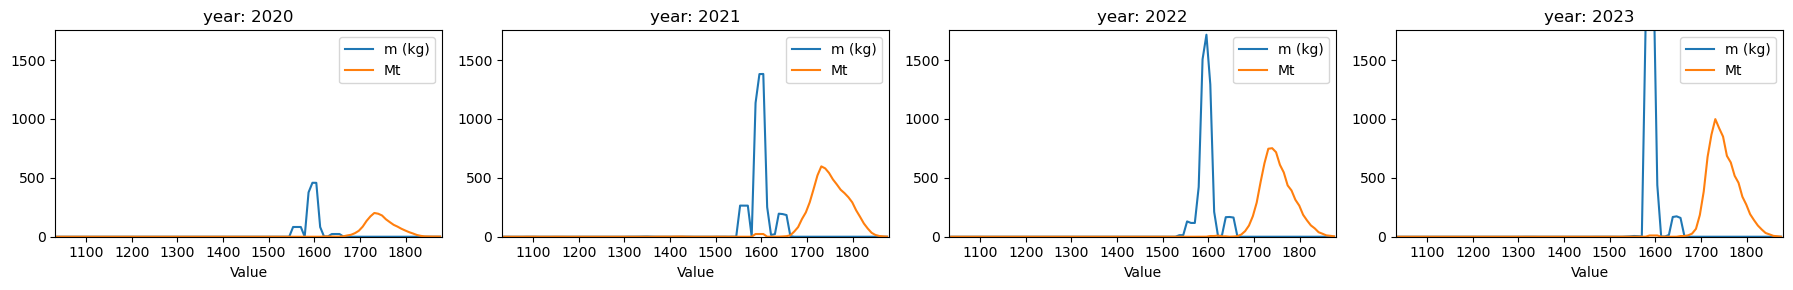

In [9]:
# Generate list of attributes
excluded_cols = ["ID", "r", "year", "#identical occurences"]
all_nan_cols = df.columns[df.isna().all()].tolist()
include_cols =['m (kg)',
 'Mt',
 #'W (mm)',
 #'At1 (mm)',
 #'At2 (mm)',
 #'ec (cm3)',
 #'ep (KW)',
 #'z (Wh/km)'
 ]

attributes = [col for col in include_cols if (col not in excluded_cols) and (col not in all_nan_cols)]

# Call the function with dataframe, attributes, and facet by year
plot_normalized_histograms(df, attributes, row_var="year", bins = 100, norm = False, iqrfactor = 2.3, ylimfactor = 0.7, plot_type="line")

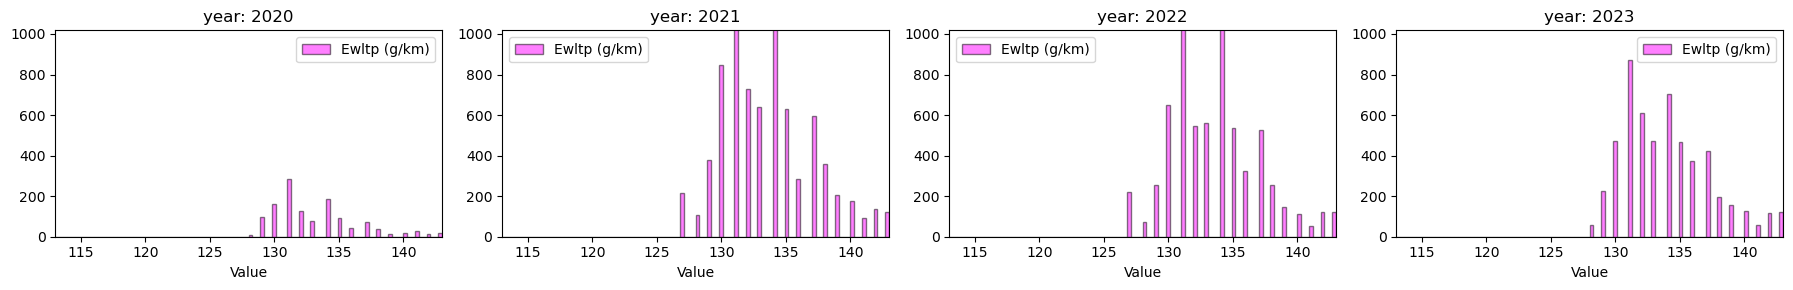

In [65]:
# Generate list of attributes
#excluded_cols = ["ID", "r", "year", "#identical occurences"]
#all_nan_cols = df_combustion.columns[df_combustion.isna().all()].tolist()
attributes =["Ewltp (g/km)"]
#attributes = [col for col in df_combustion.select_dtypes(include=['number']).columns 
#              if (col not in excluded_cols) and (col not in all_nan_cols)]

# Call the function with dataframe, attributes, and facet by year
plot_normalized_histograms(df, attributes, row_var="year", bins = 100, palette = ("magenta", "teal"),
                           norm = False, iqrfactor = 1.5, ylimfactor = 1.7)

## f: plot_lm_per_year

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_lm_per_year(
    df,
    explanatory_vars,
    target_var,
    row_var='year',
    col_wrap=5,
    height=3,
    aspect=1.5,
    exclude_zeros=True,
    iqrfactor=1.5,
    ylimfactor=1,
    palette=None,
    norm=False,
    plot_residuals=False
):
    """
    Plots scatter plots with regression lines (lm plots) between explanatory variables and target variable
    across different facets (e.g., years).
    Data can be preprocessed to exclude zeros, outliers, and normalized if required.

    Parameters:
    - df: The DataFrame containing the data.
    - explanatory_vars: A list of column names used as explanatory variables.
    - target_var: The column name of the target variable.
    - row_var: The column used to facet the data (default is 'year').
    - col_wrap: Number of columns per row in the grid (default is 5).
    - height: Height of each subplot (default is 3).
    - aspect: Aspect ratio of each subplot (default is 1.5).
    - exclude_zeros: Boolean indicating whether to exclude zeros (default is True).
    - iqrfactor: Factor to determine outlier threshold (default = 1.5).
    - ylimfactor: Factor to multiply ylim of all graphs with (default = 1).
    - palette: Palette for the plots.
    - norm: Boolean indicating whether to normalize the data or not.
    - plot_residuals: Boolean indicating whether to plot residuals (default = False).
    """
    # Create a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    
    # Prepare dictionaries to store processed data
    data_dict = {}
    
    # Preprocess explanatory variables and target variable
    for var in explanatory_vars + [target_var]:
        column = df_copy[var]
        
        # Exclude zeros if required
        if exclude_zeros:
            column = column.replace(0, np.nan)
        
        # Remove NaNs for processing
        non_nan_values = column.dropna()
        
        # Check if non_nan_values is empty
        if non_nan_values.empty:
            print(f"No valid data for variable '{var}' after excluding zeros and NaNs.")
            continue
        
        # Calculate IQR (Interquartile Range)
        q1 = np.percentile(non_nan_values, 25)
        q3 = np.percentile(non_nan_values, 75)
        iqr = q3 - q1
        
        # Define upper and lower bounds for outliers
        lower_bound = q1 - iqrfactor * iqr
        upper_bound = q3 + iqrfactor * iqr
        
        # Exclude outliers
        column[(column < lower_bound) | (column > upper_bound)] = np.nan
        
        # Optionally normalize the data
        if norm:
            data_min = non_nan_values.min()
            data_max = non_nan_values.max()
            # Avoid division by zero
            if data_max - data_min == 0:
                print(f"Cannot normalize variable '{var}' because data_max equals data_min.")
                normalized_column = pd.Series(np.nan, index=column.index)
            else:
                normalized_column = (column - data_min) / (data_max - data_min)
            data_dict[var] = normalized_column
        else:
            data_dict[var] = column
    
    # Check if data_dict is empty
    if not data_dict:
        print("No valid data available for plotting after preprocessing.")
        return
    
    # Create a DataFrame from the data_dict
    df_processed = pd.DataFrame(data_dict)
    df_processed[row_var] = df_copy[row_var]
    
    # Get unique values of row_var to create facets
    facet_values = df_processed[row_var].unique()
    n_facets = len(facet_values)
    n_cols = col_wrap
    n_rows = int(np.ceil(n_facets / n_cols))
    
    # Get a color palette if none is passed
    if palette is None:
        palette = sns.color_palette("tab10", len(explanatory_vars))
    
    # Create the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * aspect * height, n_rows * height))
    axes = axes.flatten()
    
    # For each facet (e.g., year), plot the lm plots
    for i, (facet_value, ax) in enumerate(zip(facet_values, axes)):
        # Subset the data for this facet
        df_facet = df_processed[df_processed[row_var] == facet_value]
        
        # Flag to check if any data was plotted
        plotted = False
        
        # Plot lmplot for each explanatory variable
        for var, color in zip(explanatory_vars, palette):
            data_x = df_facet[var]
            data_y = df_facet[target_var]
            # Drop NaNs
            mask = data_x.notna() & data_y.notna()
            data_x = data_x[mask]
            data_y = data_y[mask]
            
            if data_x.empty or data_y.empty:
                continue  # Skip if no data to plot
            
            # Scatter plot with regression line
            sns.regplot(
                x=data_x,
                y=data_y,
                ax=ax,
                color=color,
                label=var,
                scatter_kws={'alpha': 0.5},
                line_kws={'color': color}
            )
            
            plotted = True
            
            # Optionally plot residuals
            if plot_residuals:
                # Calculate residuals
                import statsmodels.api as sm
                X = sm.add_constant(data_x)
                model = sm.OLS(data_y, X).fit()
                residuals = data_y - model.predict(X)
                # Plot residuals
                ax2 = ax.twinx()
                ax2.plot(data_x, residuals, 'o', color=color, alpha=0.3, label=f'{var} residuals')
                ax2.axhline(0, color='gray', linestyle='--')
                ax2.set_ylabel('Residuals')
        
        if plotted:
            ax.set_title(f"{row_var}: {facet_value}")
            ax.legend()
            ax.set_xlabel('Normalized Value' if norm else var)
            ax.set_ylabel(target_var)
        else:
            ax.set_visible(False)  # Hide the subplot if nothing was plotted
    
    # Remove unused subplots if any
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [35]:
df.columns

Index(['ID', 'Country', 'VFN', 'Mp', 'Mh', 'Man', 'MMS', 'Tan', 'T', 'Va',
       'Ve', 'Mk', 'Cn', 'Ct', 'Cr', 'r', 'm (kg)', 'Mt', 'Enedc (g/km)',
       'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ft', 'Fm',
       'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT', 'Ernedc (g/km)',
       'Erwltp (g/km)', 'De', 'Vf', 'Status', 'year', 'Date of registration',
       'Fuel consumption ', 'ech', 'RLFI', 'Electric range (km)',
       '#identical occurences', 'tvv'],
      dtype='object')

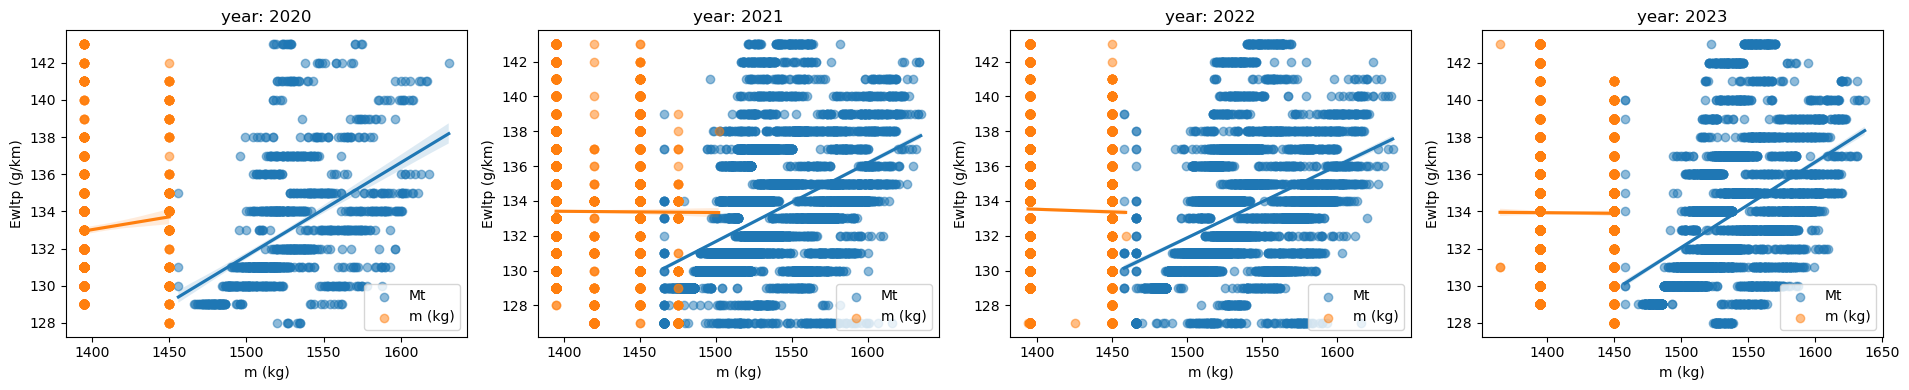

In [67]:
plot_lm_per_year(
    df=df,
    explanatory_vars=['Mt','m (kg)'],
    target_var='Ewltp (g/km)',
    row_var='year',
    col_wrap=4,
    height=4,
    aspect=1.2,
    exclude_zeros=True,
    iqrfactor=1.5,
    norm=False,
    plot_residuals=False
)

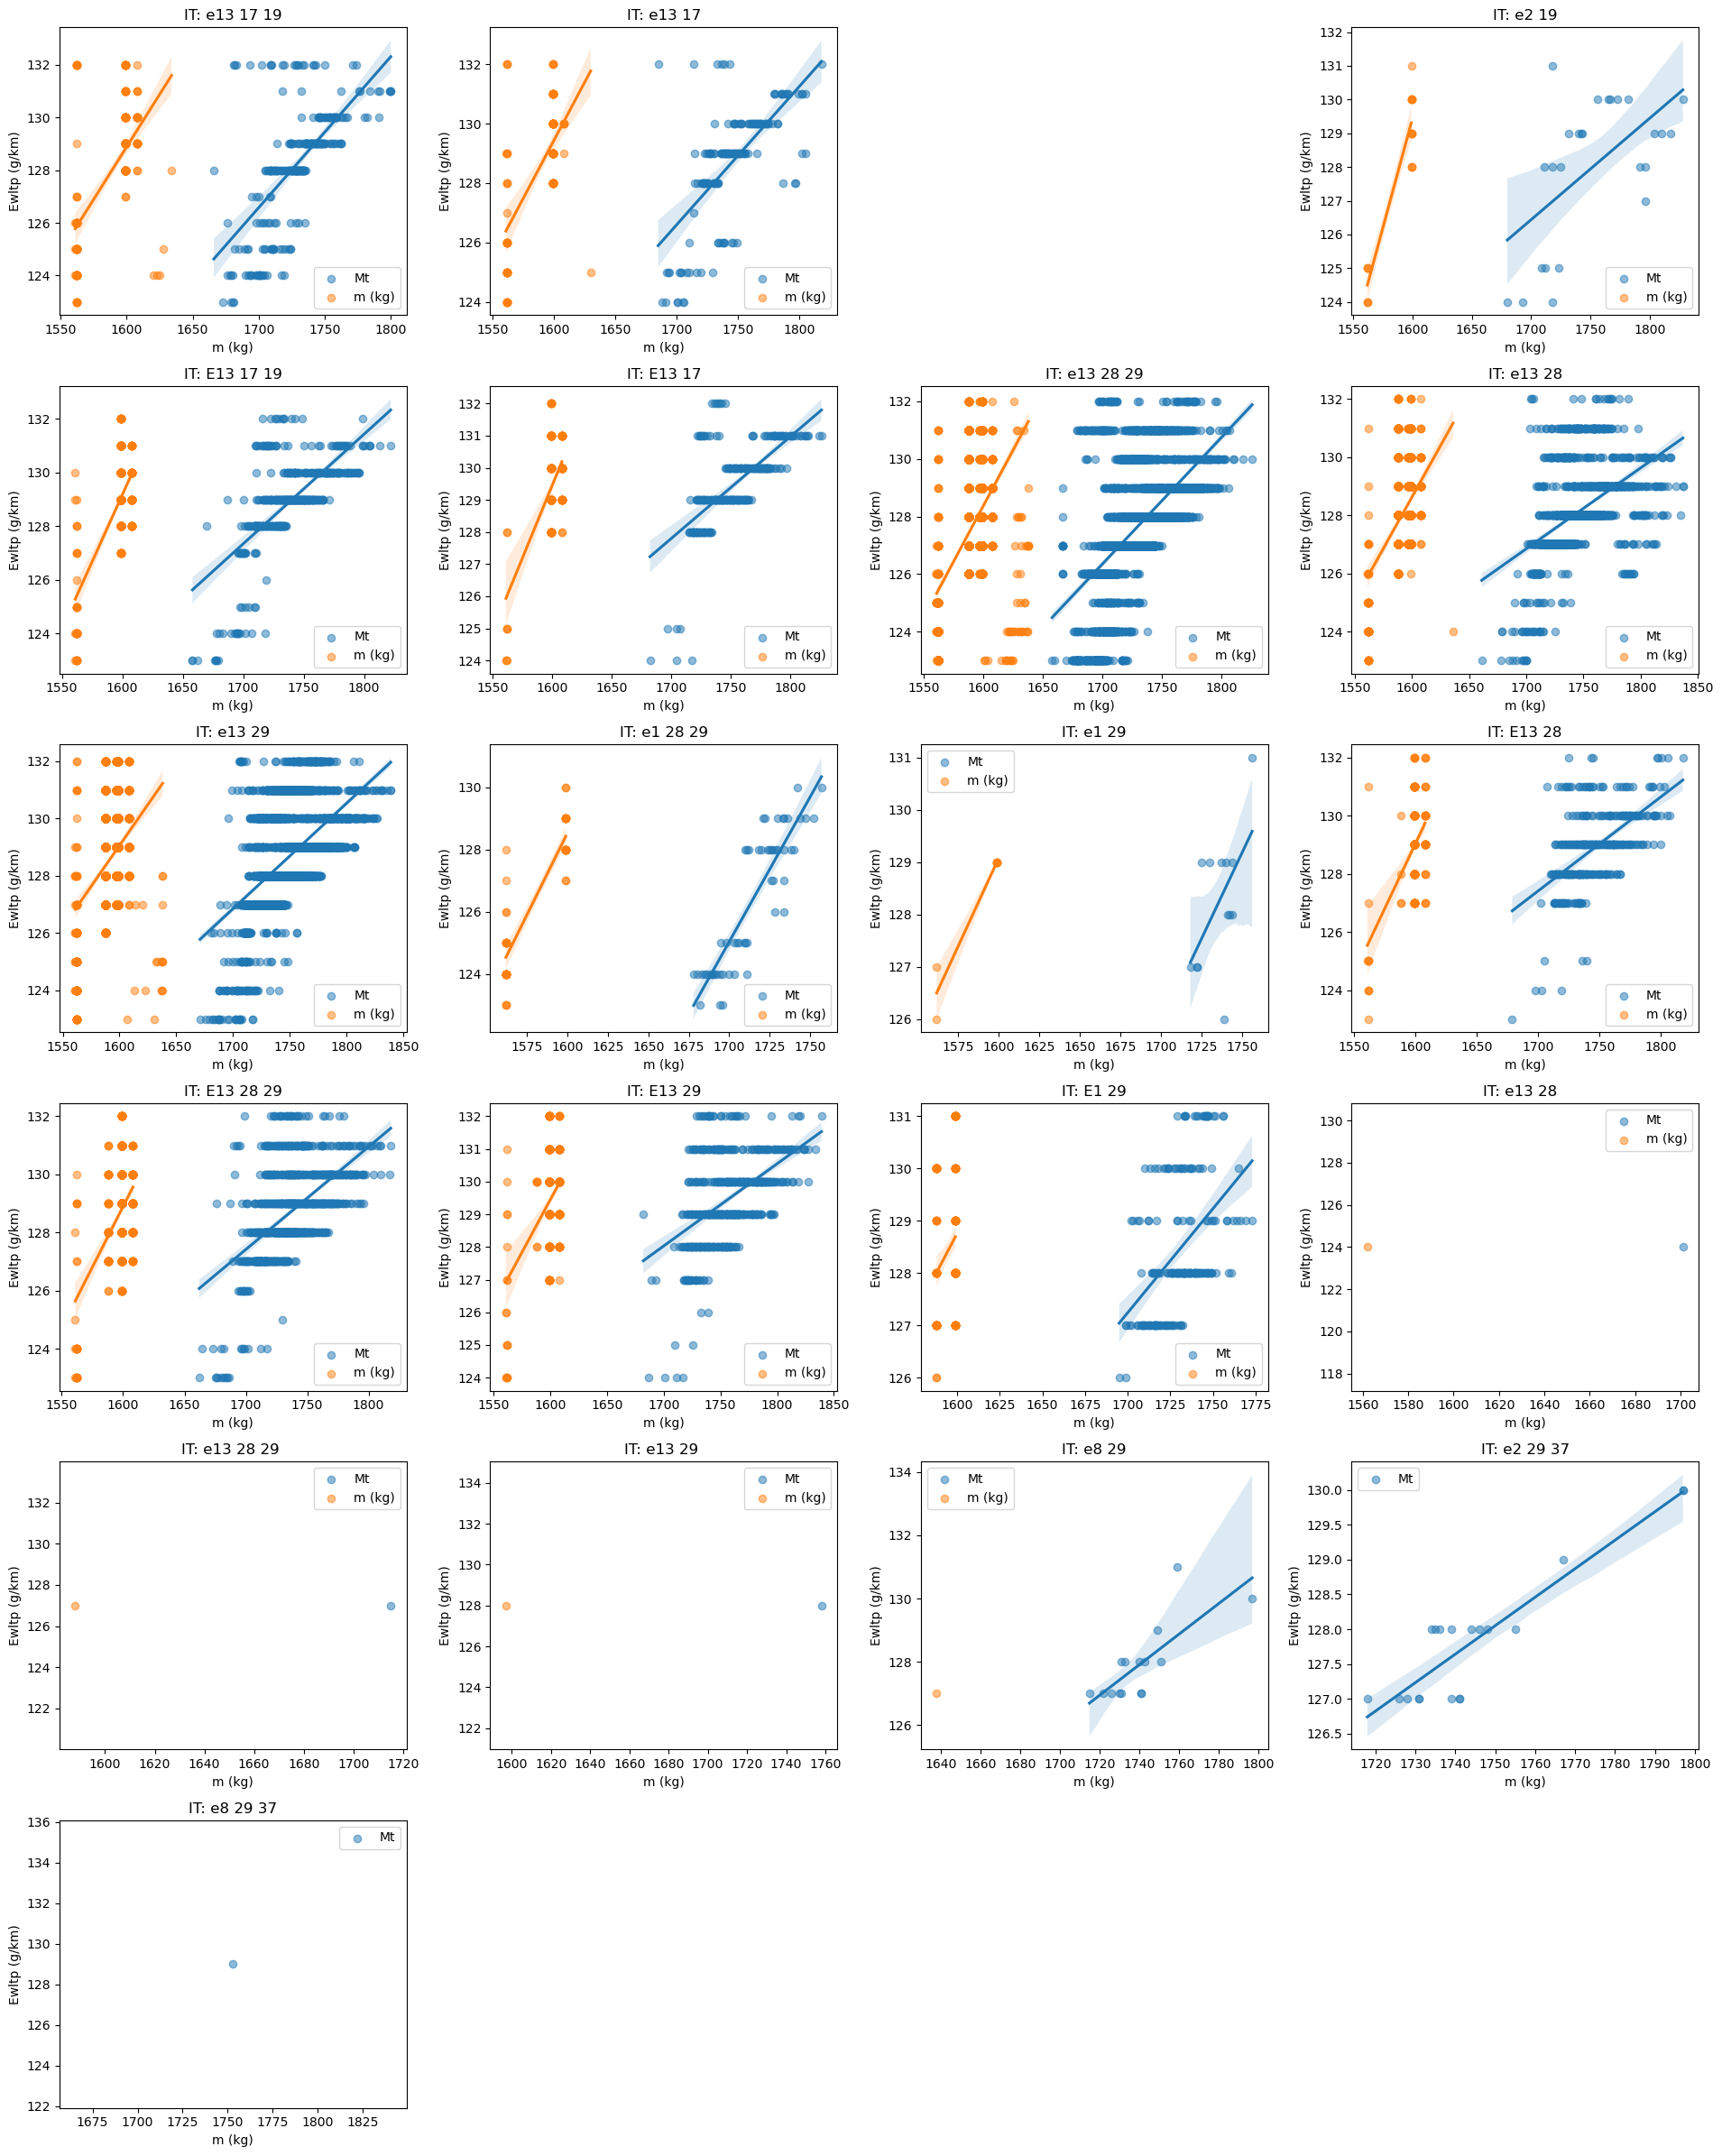

In [47]:
plot_lm_per_year(
    df=df,
    explanatory_vars=['Mt','m (kg)'],
    target_var='Ewltp (g/km)',
    row_var='IT',
    col_wrap=4,
    height=4,
    aspect=1.2,
    exclude_zeros=True,
    iqrfactor=1.5,
    norm=False,
    plot_residuals=False
)